In [1]:
import h3
import geopandas as gpd
import h3pandas
import matplotlib.pyplot as plt
import pandas as pd
import shapely
shapely.speedups.disable()
from shapely.ops import unary_union
from shapely.geometry import mapping, Polygon
import pandas as pd
import plotly.express as px
import geopandas as gpd
import pyproj
from shapely import wkt
import geopandas  as gpd
import matplotlib.pyplot as plt
import pandas
import libpysal
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import contextily as ctx
from cenpy import products
from sklearn.neighbors import BallTree
import numpy as np
from scipy.spatial.distance import cdist
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
import contextily

# Adding in Python Data and creating Hex Grids 

In [2]:
pythons = pd.read_csv('raw_data/PythonSightings.csv')
pythons['ObsDate'] = pd.to_datetime(pythons['ObsDate'], format='%m/%d/%Y')
pythons1620 = pythons.loc[(pythons['ObsDate'] >= '01/01/2016') & (pythons['ObsDate'] < '01/01/2021')]
pythons1620 = pythons1620[['objectid', 'ObsDate', 'Latitude','Longitude']]
pythons1620.dropna(inplace=True)

In [3]:
pythons1620

objectid    ObsDate  Latitude  Longitude
2244   4455294 2016-01-17  26.09410  -80.51183
2245   4455354 2016-01-20  25.50858  -80.55805
2246   4456193 2016-01-26  26.70519  -81.74914
2247   4456212 2016-01-26  26.85639  -82.00524
2248   4457001 2016-01-30  25.46334  -80.33154
...        ...        ...       ...        ...
7526   8821451 2020-09-21  28.27322  -81.62104
7527   8821481 2020-07-18  27.63630  -81.82753
7528   8821693 2020-12-04  26.85742  -82.21788
7532   9319776 2017-01-23  25.76230  -80.82164
7533   9320005 2017-04-08  25.79314  -80.85599

[4587 rows x 4 columns]

In [4]:
pythons1620["ObsDate"] = pythons1620["ObsDate"].dt.strftime("%B")

In [5]:
pythons1620

objectid    ObsDate  Latitude  Longitude
2244   4455294    January  26.09410  -80.51183
2245   4455354    January  25.50858  -80.55805
2246   4456193    January  26.70519  -81.74914
2247   4456212    January  26.85639  -82.00524
2248   4457001    January  25.46334  -80.33154
...        ...        ...       ...        ...
7526   8821451  September  28.27322  -81.62104
7527   8821481       July  27.63630  -81.82753
7528   8821693   December  26.85742  -82.21788
7532   9319776    January  25.76230  -80.82164
7533   9320005      April  25.79314  -80.85599

[4587 rows x 4 columns]

In [6]:
geoPython1620 = gpd.GeoDataFrame(pythons1620, geometry=gpd.points_from_xy(pythons1620.Longitude, pythons1620.Latitude))
geoPython1620 = geoPython1620.set_crs(epsg=4326, inplace=True)
geoPython1620

objectid    ObsDate  Latitude  Longitude                    geometry
2244   4455294    January  26.09410  -80.51183  POINT (-80.51183 26.09410)
2245   4455354    January  25.50858  -80.55805  POINT (-80.55805 25.50858)
2246   4456193    January  26.70519  -81.74914  POINT (-81.74914 26.70519)
2247   4456212    January  26.85639  -82.00524  POINT (-82.00524 26.85639)
2248   4457001    January  25.46334  -80.33154  POINT (-80.33154 25.46334)
...        ...        ...       ...        ...                         ...
7526   8821451  September  28.27322  -81.62104  POINT (-81.62104 28.27322)
7527   8821481       July  27.63630  -81.82753  POINT (-81.82753 27.63630)
7528   8821693   December  26.85742  -82.21788  POINT (-82.21788 26.85742)
7532   9319776    January  25.76230  -80.82164  POINT (-80.82164 25.76230)
7533   9320005      April  25.79314  -80.85599  POINT (-80.85599 25.79314)

[4587 rows x 5 columns]

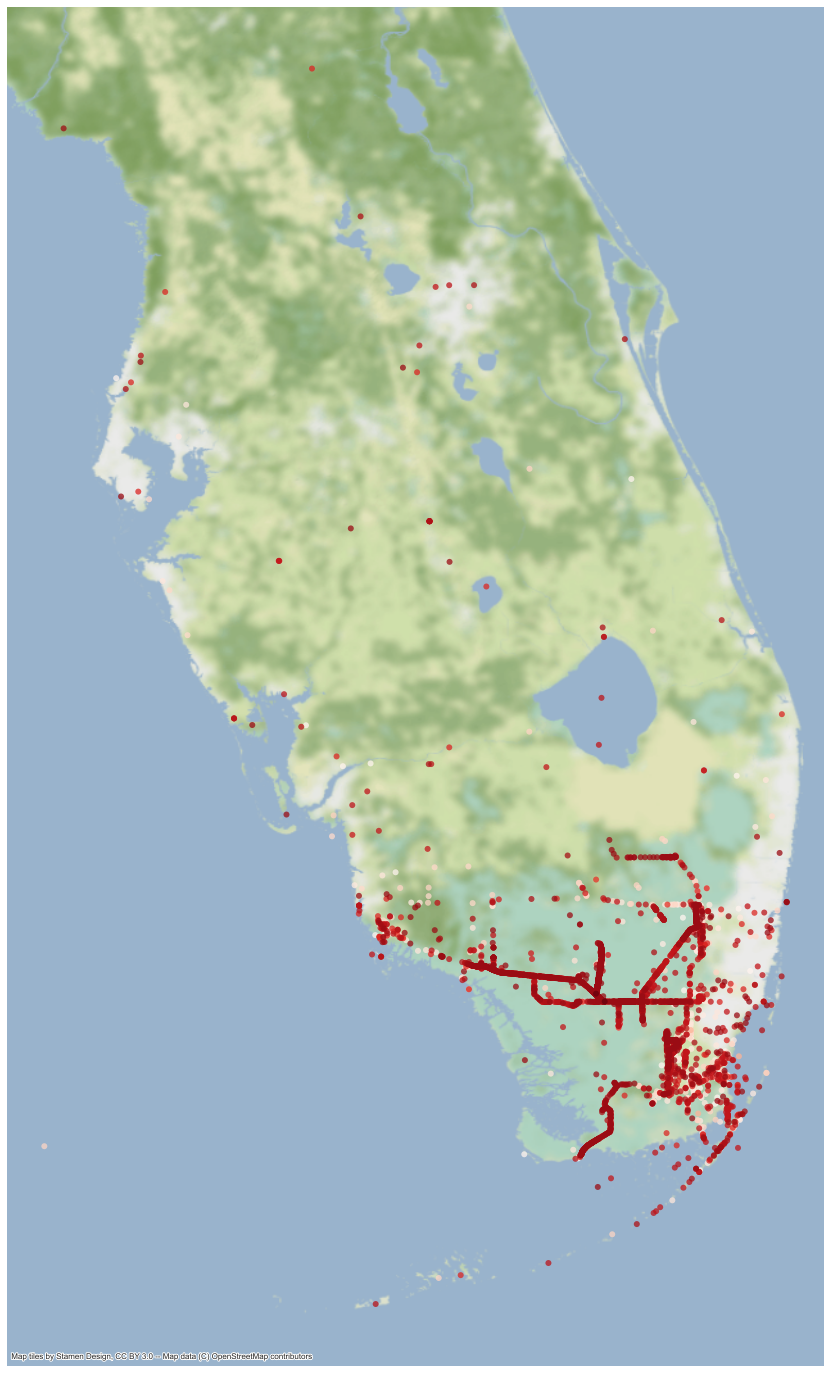

In [262]:
f, ax = plt.subplots(1, figsize=(25, 25))
geoPython1620.plot(
    column='objectid', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=geoPython1620.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [263]:
counties = gpd.read_file('raw_data/geojson-fl-counties-fips.json')
counties = counties.to_crs(epsg=4326)
counties

id          GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry  
0   POLYGON ((-82.31170 28.96039, -82.42700 29.021...  
1   MULTIPOLYGON (((-80.25058 25.34193, -80.25492 ...  
2   POLYGON ((-81.65739 28.55312, -81.65811 28.682...  
3   POLYGON ((-80.67786 27.20599, -80.67861 27.448...  
4   POLYGON ((-81.95419 28.96005, -81.95358 28.820...  
..                                                ...  
62  POLYGON ((-84.00739 30.67210, -83.88032 30.665...  
63  POLYGON ((-80.63131 28.65519, -80.61679 28.634...  
64  POLYGON ((-82.40515 29.33026, -82.40459 29.278...  
65  POLYGON ((-81.56376 26.51332, -81.27177 26.517...  
66  POLYGON ((-86.91929 30.37067, -87.15539 30.327...  

[67 rows x 8 columns]

In [264]:
joined = gpd.sjoin(geoPython1620, counties, op='within', how='left')

joined

objectid    ObsDate  Latitude  Longitude                    geometry  \
2244   4455294    January  26.09410  -80.51183  POINT (-80.51183 26.09410)   
2245   4455354    January  25.50858  -80.55805  POINT (-80.55805 25.50858)   
2246   4456193    January  26.70519  -81.74914  POINT (-81.74914 26.70519)   
2247   4456212    January  26.85639  -82.00524  POINT (-82.00524 26.85639)   
2248   4457001    January  25.46334  -80.33154  POINT (-80.33154 25.46334)   
...        ...        ...       ...        ...                         ...   
7526   8821451  September  28.27322  -81.62104  POINT (-81.62104 28.27322)   
7527   8821481       July  27.63630  -81.82753  POINT (-81.82753 27.63630)   
7528   8821693   December  26.85742  -82.21788  POINT (-82.21788 26.85742)   
7532   9319776    January  25.76230  -80.82164  POINT (-80.82164 25.76230)   
7533   9320005      April  25.79314  -80.85599  POINT (-80.85599 25.79314)   

      index_right     id          GEO_ID STATE COUNTY        NAME    LSAD  \
2244         27.0  12011  0500000US12011    12    011     Broward  County   
2245         57.0  12086  0500000US12086    12    086  Miami-Dade  County   
2246         29.0  12071  0500000US12071    12    071         Lee  County   
2247         28.0  12015  0500000US12015    12    015   Charlotte  County   
2248          NaN    NaN             NaN   NaN    NaN         NaN     NaN   
...           ...    ...             ...   ...    ...         ...     ...   
7526         15.0  12097  0500000US12097    12    097     Osceola  County   
7527         38.0  12049  0500000US12049    12    049      Hardee  County   
7528         28.0  12015  0500000US12015    12    015   Charlotte  County   
7532         57.0  12086  0500000US12086    12    086  Miami-Dade  County   
7533         57.0  12086  0500000US12086    12    086  Miami-Dade  County   

      CENSUSAREA  
2244    1209.785  
2245    1897.716  
2246     784.513  
2247     680.279  
2248         NaN  
...          ...  
7526    1327.453  
7527     637.783  
7528     680.279  
7532    1897.716  
7533    1897.716  

[4587 rows x 13 columns]

In [265]:
grouped = joined.groupby('NAME', as_index=False)

count = grouped.agg(pythonCount=('objectid','count'))
count.sort_values(by='pythonCount', ascending=False)

#count = count[count['NAME'].isin(['Miami-Dade', 'Collier', 'Broward', 'Monroe'])]

count

NAME  pythonCount
0        Brevard            2
1        Broward          475
2      Charlotte            7
3        Collier          901
4         Glades            1
5         Hardee            1
6         Hendry            5
7       Hernando            1
8      Highlands            2
9   Hillsborough            2
10          Lake            1
11           Lee           10
12          Levy            1
13       Manatee            5
14        Marion            1
15        Martin            2
16    Miami-Dade         2717
17        Monroe          306
18    Okeechobee            3
19        Orange            5
20       Osceola            3
21    Palm Beach           41
22         Pasco            5
23      Pinellas            2
24          Polk           10
25      Sarasota            1
26     St. Lucie            2

In [11]:
pythonsPerCounty = counties.merge(count, on='NAME', how="outer")
pythonsPerCounty.fillna(0, inplace=True)

pythonsPerCounty['pythonCount'] = pythonsPerCounty['pythonCount'].astype(int)
pythonsPerCounty

id          GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry  pythonCount  
0   POLYGON ((-82.31170 28.96039, -82.42700 29.021...            1  
1   MULTIPOLYGON (((-80.25058 25.34193, -80.25492 ...          306  
2   POLYGON ((-81.65739 28.55312, -81.65811 28.682...            5  
3   POLYGON ((-80.67786 27.20599, -80.67861 27.448...            2  
4   POLYGON ((-81.95419 28.96005, -81.95358 28.820...            0  
..                                                ...          ...  
62  POLYGON ((-84.00739 30.67210, -83.88032 30.665...            0  
63  POLYGON ((-80.63131 28.65519, -80.61679 28.634...            2  
64  POLYGON ((-82.40515 29.33026, -82.40459 29.278...            1  
65  POLYGON ((-81.56376 26.51332, -81.27177 26.517...          901  
66  POLYGON ((-86.91929 30.37067, -87.15539 30.327...            0  

[67 rows x 9 columns]

In [12]:
pythonsPerCounty['pythonCount'] = pythonsPerCounty['pythonCount'].astype(int)
pythonsPerCounty

id          GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry  pythonCount  
0   POLYGON ((-82.31170 28.96039, -82.42700 29.021...            1  
1   MULTIPOLYGON (((-80.25058 25.34193, -80.25492 ...          306  
2   POLYGON ((-81.65739 28.55312, -81.65811 28.682...            5  
3   POLYGON ((-80.67786 27.20599, -80.67861 27.448...            2  
4   POLYGON ((-81.95419 28.96005, -81.95358 28.820...            0  
..                                                ...          ...  
62  POLYGON ((-84.00739 30.67210, -83.88032 30.665...            0  
63  POLYGON ((-80.63131 28.65519, -80.61679 28.634...            2  
64  POLYGON ((-82.40515 29.33026, -82.40459 29.278...            1  
65  POLYGON ((-81.56376 26.51332, -81.27177 26.517...          901  
66  POLYGON ((-86.91929 30.37067, -87.15539 30.327...            0  

[67 rows x 9 columns]

In [13]:
pythonsPerCounty.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
county_hex = h3fy(pythonsPerCounty, resolution=5, return_geoms=True)

C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\tobler\util\util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hexids = pandas.Series(
C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\tobler\util\util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hexids = pandas.Series(
C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\tobler\util\util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hexids = pandas.Series(
C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\tobler\util\util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version

<AxesSubplot:>

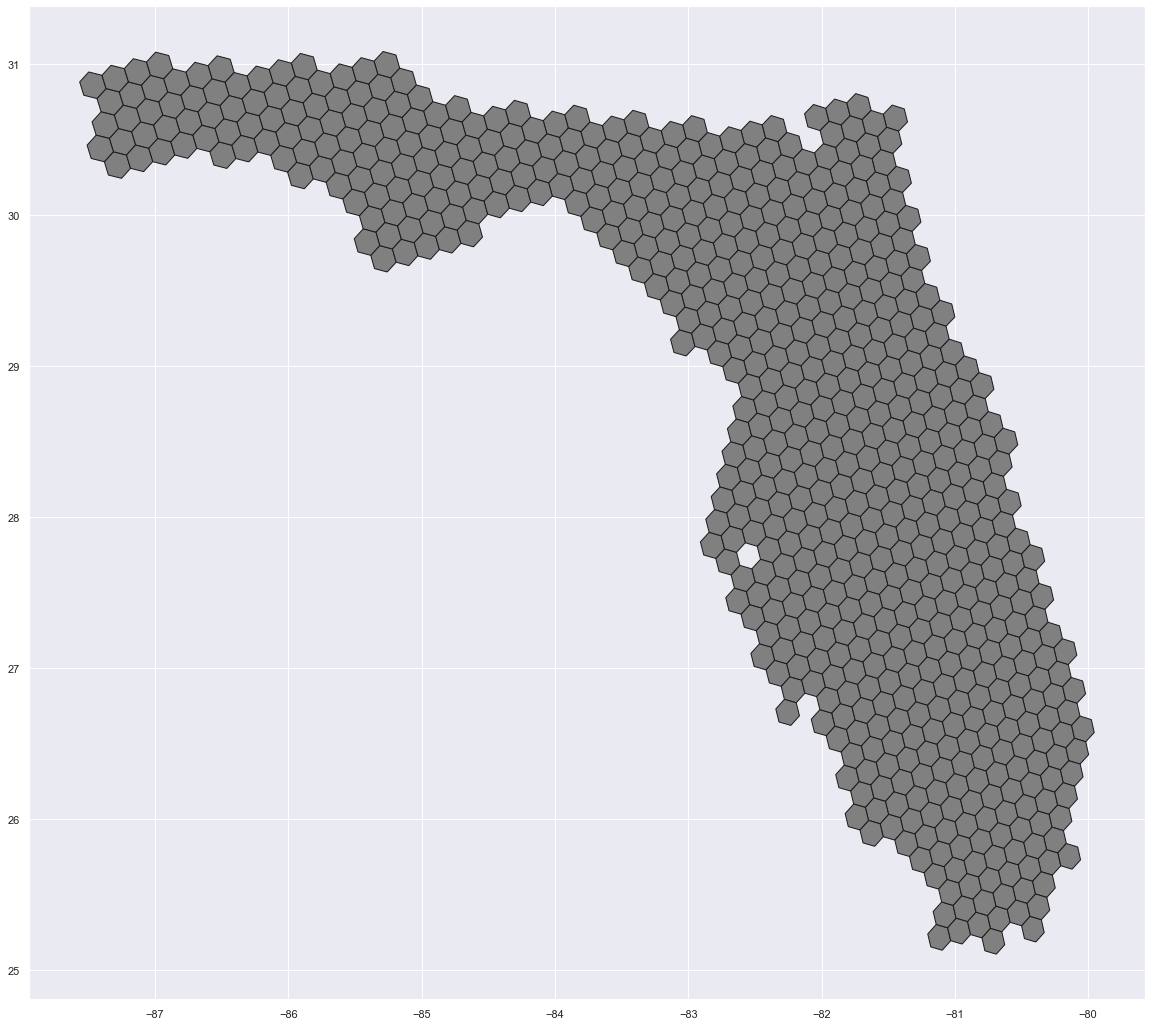

In [15]:
fig, ax = plt.subplots(figsize=(20,20))

county_hex.plot(ax=ax, facecolor='Grey', edgecolor='k',alpha=1,linewidth=1)

In [16]:
python_hexWIP = gpd.sjoin(geoPython1620, county_hex, op='within', how='left')

In [17]:
python_hexWIP

objectid    ObsDate  Latitude  Longitude                    geometry  \
2244   4455294    January  26.09410  -80.51183  POINT (-80.51183 26.09410)   
2245   4455354    January  25.50858  -80.55805  POINT (-80.55805 25.50858)   
2246   4456193    January  26.70519  -81.74914  POINT (-81.74914 26.70519)   
2247   4456212    January  26.85639  -82.00524  POINT (-82.00524 26.85639)   
2248   4457001    January  25.46334  -80.33154  POINT (-80.33154 25.46334)   
...        ...        ...       ...        ...                         ...   
7526   8821451  September  28.27322  -81.62104  POINT (-81.62104 28.27322)   
7527   8821481       July  27.63630  -81.82753  POINT (-81.82753 27.63630)   
7528   8821693   December  26.85742  -82.21788  POINT (-82.21788 26.85742)   
7532   9319776    January  25.76230  -80.82164  POINT (-80.82164 25.76230)   
7533   9320005      April  25.79314  -80.85599  POINT (-80.85599 25.79314)   

          index_right  
2244  8544a1affffffff  
2245  8544125bfffffff  
2246  85441363fffffff  
2247  8544132ffffffff  
2248  8544a193fffffff  
...               ...  
7526  8544a987fffffff  
7527  8544ad33fffffff  
7528  85441327fffffff  
7532  85441247fffffff  
7533  8544127bfffffff  

[4587 rows x 6 columns]

In [18]:
grouped = python_hexWIP.groupby(['index_right'])['objectid'].agg('count').reset_index()

In [19]:
grouped = grouped.rename(columns={"index_right": "hex_id", "objectid": "pythonsPerHex"})
grouped.sort_values(by='pythonsPerHex', ascending=False)

hex_id  pythonsPerHex
22   8544127bfffffff            512
12   8544124ffffffff            338
10   85441247fffffff            306
8    8544123bfffffff            287
11   8544124bfffffff            287
..               ...            ...
80   8544a8c3fffffff              1
81   8544a8dbfffffff              1
82   8544a903fffffff              1
84   8544a90ffffffff              1
115  8544f4cbfffffff              1

[116 rows x 2 columns]

In [20]:
pythons_hex = county_hex.merge(grouped, on='hex_id', how="outer")

In [21]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-82.68701 30.26137, -82.62019 30.323...   
1    8544f6abfffffff  POLYGON ((-81.29118 29.48500, -81.22528 29.546...   
2    8544e66ffffffff  POLYGON ((-83.76528 30.14076, -83.69824 30.203...   
3    8544f577fffffff  POLYGON ((-82.84619 30.22348, -82.77934 30.285...   
4    8544a1abfffffff  POLYGON ((-80.33361 25.88563, -80.27016 25.947...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-82.44148 27.95665, -82.37611 28.019...   
641  8544e0cffffffff  POLYGON ((-84.65382 30.20194, -84.58652 30.265...   
642  8544a9c7fffffff  POLYGON ((-81.24709 28.11964, -81.18201 28.181...   
643  8544f063fffffff  POLYGON ((-81.57898 30.51895, -81.51235 30.579...   
644  85441337fffffff  POLYGON ((-82.22996 26.62130, -82.16542 26.684...   

     pythonsPerHex  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4             15.0  
..             ...  
640            2.0  
641            NaN  
642            NaN  
643            NaN  
644            NaN  

[645 rows x 3 columns]

In [22]:
pythons_hex.fillna(0, inplace=True)

In [23]:
pythons_hex['pythonsPerHex'] = pythons_hex['pythonsPerHex'].astype(int)

In [24]:
pythons_hex.sort_values(by='pythonsPerHex', ascending=False)

hex_id                                           geometry  \
361  8544127bfffffff  POLYGON ((-80.78107 25.76680, -80.71751 25.829...   
506  8544124ffffffff  POLYGON ((-80.67295 25.65879, -80.60949 25.721...   
557  85441247fffffff  POLYGON ((-80.82220 25.61873, -80.75871 25.681...   
370  8544124bfffffff  POLYGON ((-80.56520 25.55087, -80.50184 25.613...   
194  8544123bfffffff  POLYGON ((-81.18965 25.79445, -81.12593 25.857...   
..               ...                                                ...   
233  85441b63fffffff  POLYGON ((-82.97441 29.21617, -82.90814 29.279...   
234  8544ad9bfffffff  POLYGON ((-81.73050 26.89229, -81.66597 26.955...   
235  8544ad93fffffff  POLYGON ((-81.88329 26.85212, -81.81873 26.915...   
236  8544e097fffffff  POLYGON ((-85.30405 30.03695, -85.23672 30.101...   
644  85441337fffffff  POLYGON ((-82.22996 26.62130, -82.16542 26.684...   

     pythonsPerHex  
361            512  
506            338  
557            306  
370            287  
194            287  
..             ...  
233              0  
234              0  
235              0  
236              0  
644              0  

[645 rows x 3 columns]

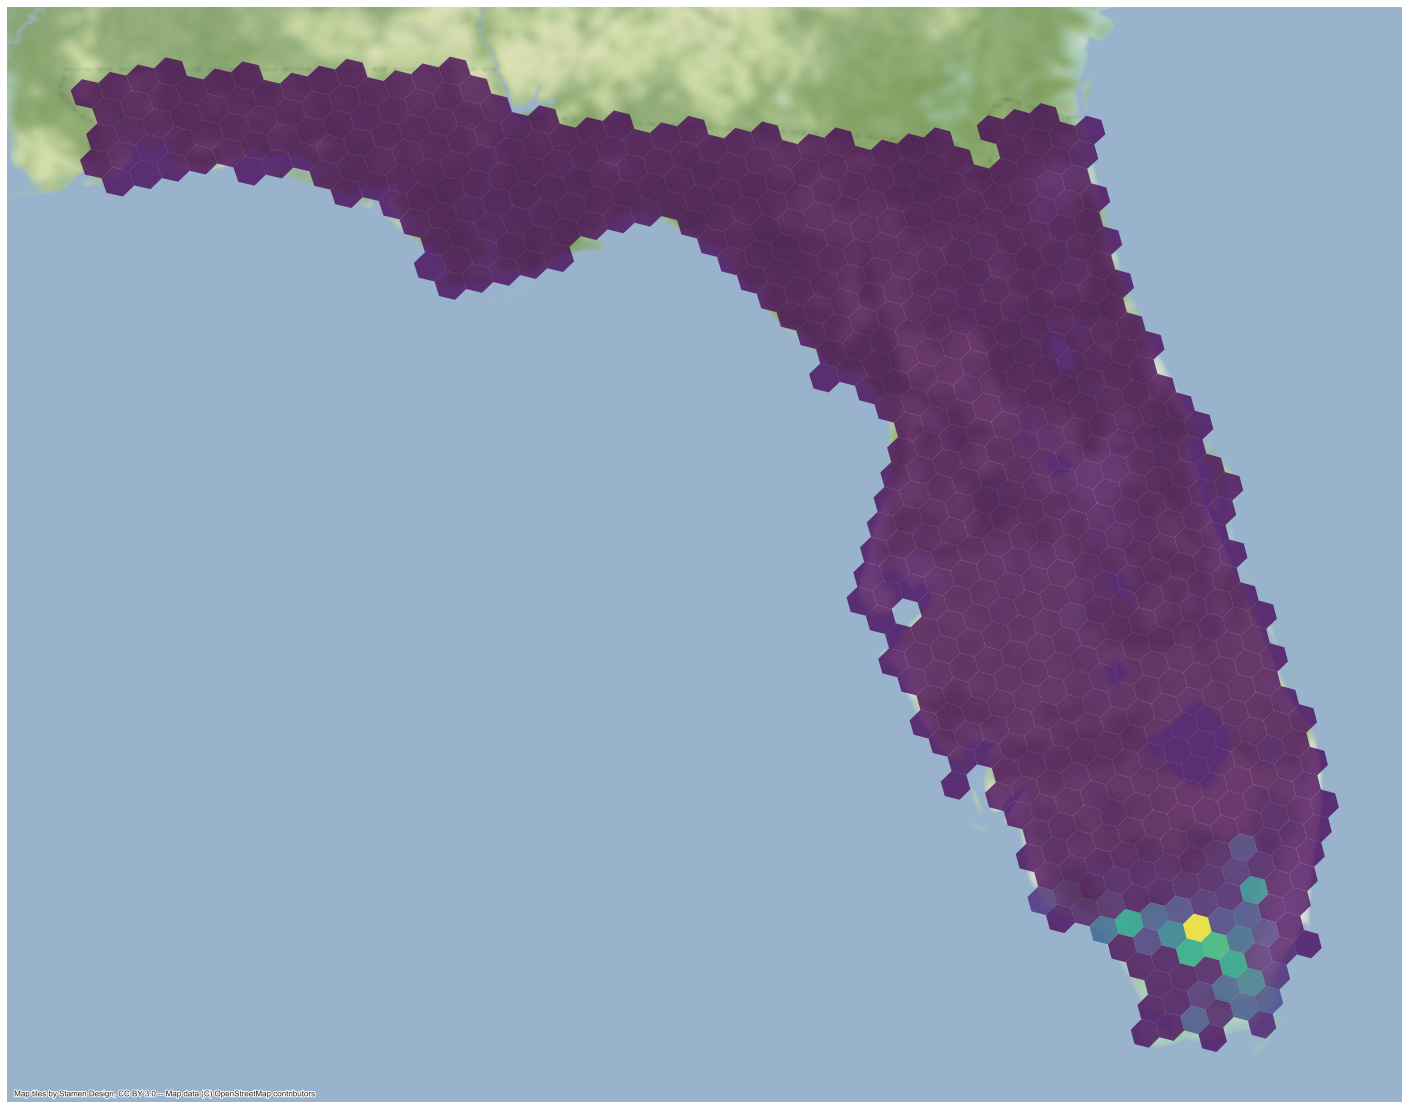

In [25]:
f, ax = plt.subplots(1, figsize=(25, 25))
pythons_hex.plot(
    column='pythonsPerHex', 
    cmap='viridis',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=pythons_hex.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [26]:
pythons_hex.groupby('pythonsPerHex').count()

hex_id  geometry
pythonsPerHex                  
0                 529       529
1                  46        46
2                  15        15
3                   2         2
4                   2         2
5                   1         1
7                   5         5
8                   3         3
9                   2         2
10                  2         2
11                  1         1
13                  2         2
15                  1         1
16                  2         2
19                  1         1
21                  2         2
26                  1         1
27                  1         1
29                  1         1
33                  1         1
40                  1         1
41                  1         1
43                  1         1
54                  1         1
63                  1         1
65                  1         1
72                  1         1
75                  1         1
80                  1         1
93                  1         1
101                 1         1
104                 1         1
116                 1         1
120                 1         1
132                 1         1
147                 1         1
155                 1         1
189                 1         1
202                 1         1
225                 1         1
287                 2         2
306                 1         1
338                 1         1
512                 1         1

In [27]:
pythons_hex = pythons_hex.to_crs(epsg=3857)

In [28]:
hexcentroid = pythons_hex.centroid
hexcentroid = hexcentroid.reset_index(drop=True)
hexcentroid

0      POINT (-9207516.672 3548365.864)
1      POINT (-9051940.009 3448539.849)
2      POINT (-9327679.828 3532866.582)
3      POINT (-9225254.523 3543487.626)
4      POINT (-8945144.691 2995470.907)
                     ...               
640    POINT (-9180095.721 3254413.310)
641    POINT (-9426702.725 3540788.136)
642    POINT (-9046993.801 3274926.409)
643    POINT (-9084038.825 3581581.452)
644    POINT (-9156490.624 3086977.903)
Length: 645, dtype: geometry

In [29]:
hexcentroid.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Configuring python data to respective month sightings were recorded in

In [30]:
group = python_hexWIP.groupby(['index_right', 'ObsDate'])['objectid'].agg('count').reset_index()

In [31]:
group

index_right   ObsDate  objectid
0    8544120bfffffff      July         1
1    8544120ffffffff     April         3
2    8544120ffffffff    August        14
3    8544120ffffffff  December         2
4    8544120ffffffff  February         3
..               ...       ...       ...
540  8544ae87fffffff   October         1
541  8544ae97fffffff      June         1
542  8544aebbfffffff   October         1
543  8544f473fffffff      June         1
544  8544f4cbfffffff  February         1

[545 rows x 3 columns]

In [32]:
months = group.pivot(index='index_right', columns='ObsDate', values='objectid', )

In [33]:
months

ObsDate          April  August  December  February  January  July  June  \
index_right                                                               
8544120bfffffff    NaN     NaN       NaN       NaN      NaN   1.0   NaN   
8544120ffffffff    3.0    14.0       2.0       3.0      3.0  16.0   4.0   
8544121bfffffff    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
85441223fffffff    2.0     4.0       2.0       1.0      1.0   9.0   1.0   
85441227fffffff    NaN     1.0       NaN       NaN      NaN   NaN   NaN   
...                ...     ...       ...       ...      ...   ...   ...   
8544ae87fffffff    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
8544ae97fffffff    NaN     NaN       NaN       NaN      NaN   NaN   1.0   
8544aebbfffffff    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
8544f473fffffff    NaN     NaN       NaN       NaN      NaN   NaN   1.0   
8544f4cbfffffff    NaN     NaN       NaN       1.0      NaN   NaN   NaN   

ObsDate          March  May  November  October  September  
index_right                                                
8544120bfffffff    NaN  NaN       NaN      NaN        NaN  
8544120ffffffff    2.0  2.0       NaN      7.0        9.0  
8544121bfffffff    NaN  NaN       1.0      NaN        NaN  
85441223fffffff    NaN  1.0       3.0      2.0        1.0  
85441227fffffff    NaN  NaN       NaN      NaN        1.0  
...                ...  ...       ...      ...        ...  
8544ae87fffffff    NaN  NaN       NaN      1.0        NaN  
8544ae97fffffff    NaN  NaN       NaN      NaN        NaN  
8544aebbfffffff    NaN  NaN       NaN      1.0        NaN  
8544f473fffffff    NaN  NaN       NaN      NaN        NaN  
8544f4cbfffffff    NaN  NaN       NaN      NaN        NaN  

[116 rows x 12 columns]

In [34]:
months.fillna(0, inplace=True)

In [35]:
month = ['April', 'August', 'December', 'February', 'January', 'July', 'June', 'March', 'May', 'November', 'October', 'September']

In [36]:
month

['April',
 'August',
 'December',
 'February',
 'January',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September']

In [37]:
def function(x):
    months[x] = months[x].astype(int)
    return months

In [38]:
function(month)    

ObsDate          April  August  December  February  January  July  June  \
index_right                                                               
8544120bfffffff      0       0         0         0        0     1     0   
8544120ffffffff      3      14         2         3        3    16     4   
8544121bfffffff      0       0         0         0        0     0     0   
85441223fffffff      2       4         2         1        1     9     1   
85441227fffffff      0       1         0         0        0     0     0   
...                ...     ...       ...       ...      ...   ...   ...   
8544ae87fffffff      0       0         0         0        0     0     0   
8544ae97fffffff      0       0         0         0        0     0     1   
8544aebbfffffff      0       0         0         0        0     0     0   
8544f473fffffff      0       0         0         0        0     0     1   
8544f4cbfffffff      0       0         0         1        0     0     0   

ObsDate          March  May  November  October  September  
index_right                                                
8544120bfffffff      0    0         0        0          0  
8544120ffffffff      2    2         0        7          9  
8544121bfffffff      0    0         1        0          0  
85441223fffffff      0    1         3        2          1  
85441227fffffff      0    0         0        0          1  
...                ...  ...       ...      ...        ...  
8544ae87fffffff      0    0         0        1          0  
8544ae97fffffff      0    0         0        0          0  
8544aebbfffffff      0    0         0        1          0  
8544f473fffffff      0    0         0        0          0  
8544f4cbfffffff      0    0         0        0          0  

[116 rows x 12 columns]

In [39]:
months = months.rename_axis("hex_id")

In [40]:
months

ObsDate          April  August  December  February  January  July  June  \
hex_id                                                                    
8544120bfffffff      0       0         0         0        0     1     0   
8544120ffffffff      3      14         2         3        3    16     4   
8544121bfffffff      0       0         0         0        0     0     0   
85441223fffffff      2       4         2         1        1     9     1   
85441227fffffff      0       1         0         0        0     0     0   
...                ...     ...       ...       ...      ...   ...   ...   
8544ae87fffffff      0       0         0         0        0     0     0   
8544ae97fffffff      0       0         0         0        0     0     1   
8544aebbfffffff      0       0         0         0        0     0     0   
8544f473fffffff      0       0         0         0        0     0     1   
8544f4cbfffffff      0       0         0         1        0     0     0   

ObsDate          March  May  November  October  September  
hex_id                                                     
8544120bfffffff      0    0         0        0          0  
8544120ffffffff      2    2         0        7          9  
8544121bfffffff      0    0         1        0          0  
85441223fffffff      0    1         3        2          1  
85441227fffffff      0    0         0        0          1  
...                ...  ...       ...      ...        ...  
8544ae87fffffff      0    0         0        1          0  
8544ae97fffffff      0    0         0        0          0  
8544aebbfffffff      0    0         0        1          0  
8544f473fffffff      0    0         0        0          0  
8544f4cbfffffff      0    0         0        0          0  

[116 rows x 12 columns]

In [41]:
months = months.rename(columns={"ObsDate": "hex_id"})

In [42]:
months

ObsDate          April  August  December  February  January  July  June  \
hex_id                                                                    
8544120bfffffff      0       0         0         0        0     1     0   
8544120ffffffff      3      14         2         3        3    16     4   
8544121bfffffff      0       0         0         0        0     0     0   
85441223fffffff      2       4         2         1        1     9     1   
85441227fffffff      0       1         0         0        0     0     0   
...                ...     ...       ...       ...      ...   ...   ...   
8544ae87fffffff      0       0         0         0        0     0     0   
8544ae97fffffff      0       0         0         0        0     0     1   
8544aebbfffffff      0       0         0         0        0     0     0   
8544f473fffffff      0       0         0         0        0     0     1   
8544f4cbfffffff      0       0         0         1        0     0     0   

ObsDate          March  May  November  October  September  
hex_id                                                     
8544120bfffffff      0    0         0        0          0  
8544120ffffffff      2    2         0        7          9  
8544121bfffffff      0    0         1        0          0  
85441223fffffff      0    1         3        2          1  
85441227fffffff      0    0         0        0          1  
...                ...  ...       ...      ...        ...  
8544ae87fffffff      0    0         0        1          0  
8544ae97fffffff      0    0         0        0          0  
8544aebbfffffff      0    0         0        1          0  
8544f473fffffff      0    0         0        0          0  
8544f4cbfffffff      0    0         0        0          0  

[116 rows x 12 columns]

In [43]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  
0                0  
1                0  
2                0  
3                0  
4               15  
..             ...  
640              2  
641              0  
642              0  
643              0  
644              0  

[645 rows x 3 columns]

In [44]:
months

ObsDate          April  August  December  February  January  July  June  \
hex_id                                                                    
8544120bfffffff      0       0         0         0        0     1     0   
8544120ffffffff      3      14         2         3        3    16     4   
8544121bfffffff      0       0         0         0        0     0     0   
85441223fffffff      2       4         2         1        1     9     1   
85441227fffffff      0       1         0         0        0     0     0   
...                ...     ...       ...       ...      ...   ...   ...   
8544ae87fffffff      0       0         0         0        0     0     0   
8544ae97fffffff      0       0         0         0        0     0     1   
8544aebbfffffff      0       0         0         0        0     0     0   
8544f473fffffff      0       0         0         0        0     0     1   
8544f4cbfffffff      0       0         0         1        0     0     0   

ObsDate          March  May  November  October  September  
hex_id                                                     
8544120bfffffff      0    0         0        0          0  
8544120ffffffff      2    2         0        7          9  
8544121bfffffff      0    0         1        0          0  
85441223fffffff      0    1         3        2          1  
85441227fffffff      0    0         0        0          1  
...                ...  ...       ...      ...        ...  
8544ae87fffffff      0    0         0        1          0  
8544ae97fffffff      0    0         0        0          0  
8544aebbfffffff      0    0         0        1          0  
8544f473fffffff      0    0         0        0          0  
8544f4cbfffffff      0    0         0        0          0  

[116 rows x 12 columns]

In [45]:
pythons_hex = pythons_hex.merge(months, on='hex_id', how="outer")

In [46]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
1                0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
2                0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
3                0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
642              0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
643              0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   
644              0    NaN     NaN       NaN       NaN      NaN   NaN   NaN   

     March  May  November  October  September  
0      NaN  NaN       NaN      NaN        NaN  
1      NaN  NaN       NaN      NaN        NaN  
2      NaN  NaN       NaN      NaN        NaN  
3      NaN  NaN       NaN      NaN        NaN  
4      0.0  1.0       2.0      4.0        2.0  
..     ...  ...       ...      ...        ...  
640    0.0  0.0       0.0      0.0        1.0  
641    NaN  NaN       NaN      NaN        NaN  
642    NaN  NaN       NaN      NaN        NaN  
643    NaN  NaN       NaN      NaN        NaN  
644    NaN  NaN       NaN      NaN        NaN  

[645 rows x 15 columns]

In [47]:
pythons_hex.fillna(0, inplace=True)

In [48]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     March  May  November  October  September  
0      0.0  0.0       0.0      0.0        0.0  
1      0.0  0.0       0.0      0.0        0.0  
2      0.0  0.0       0.0      0.0        0.0  
3      0.0  0.0       0.0      0.0        0.0  
4      0.0  1.0       2.0      4.0        2.0  
..     ...  ...       ...      ...        ...  
640    0.0  0.0       0.0      0.0        1.0  
641    0.0  0.0       0.0      0.0        0.0  
642    0.0  0.0       0.0      0.0        0.0  
643    0.0  0.0       0.0      0.0        0.0  
644    0.0  0.0       0.0      0.0        0.0  

[645 rows x 15 columns]

In [49]:
pythons_hex.sort_values(by='pythonsPerHex', ascending=False)

hex_id                                           geometry  \
361  8544127bfffffff  POLYGON ((-8992507.664 2970226.717, -8985432.5...   
506  8544124ffffffff  POLYGON ((-8980471.229 2956881.151, -8973407.3...   
557  85441247fffffff  POLYGON ((-8997086.009 2951935.157, -8990018.4...   
370  8544124bfffffff  POLYGON ((-8968476.701 2943560.217, -8961424.0...   
194  8544123bfffffff  POLYGON ((-9037991.037 2973644.524, -9030897.7...   
..               ...                                                ...   
233  85441b63fffffff  POLYGON ((-9236669.071 3403189.109, -9229291.4...   
234  8544ad9bfffffff  POLYGON ((-9098197.207 3110020.758, -9091013.7...   
235  8544ad93fffffff  POLYGON ((-9115206.155 3105007.839, -9108019.6...   
236  8544e097fffffff  POLYGON ((-9496002.883 3508299.987, -9488508.1...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
361            512   25.0    70.0      12.0      18.0     37.0  86.0  50.0   
506            338   52.0    32.0      31.0       5.0     24.0  22.0  38.0   
557            306   10.0    52.0      15.0       2.0     15.0  60.0  35.0   
370            287    6.0    90.0       5.0       6.0     22.0  46.0  13.0   
194            287    7.0    72.0      10.0       2.0      8.0  98.0   9.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
233              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
234              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
235              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
236              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     March   May  November  October  September  
361    4.0  43.0      27.0     87.0       53.0  
506   16.0  42.0      11.0     29.0       36.0  
557    7.0  20.0      24.0     47.0       19.0  
370    6.0  10.0      20.0     21.0       42.0  
194    1.0   2.0       9.0     29.0       40.0  
..     ...   ...       ...      ...        ...  
233    0.0   0.0       0.0      0.0        0.0  
234    0.0   0.0       0.0      0.0        0.0  
235    0.0   0.0       0.0      0.0        0.0  
236    0.0   0.0       0.0      0.0        0.0  
644    0.0   0.0       0.0      0.0        0.0  

[645 rows x 15 columns]

# Configuring the county each sighting was in, merged with the Hex 

In [50]:
pythonWIPforCounty = pythons_hex.copy(deep=True)

In [51]:
pythonWIPforCounty['centroids'] = hexcentroid

In [52]:
pythonWIPforCounty

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     March  May  November  October  September  \
0      0.0  0.0       0.0      0.0        0.0   
1      0.0  0.0       0.0      0.0        0.0   
2      0.0  0.0       0.0      0.0        0.0   
3      0.0  0.0       0.0      0.0        0.0   
4      0.0  1.0       2.0      4.0        2.0   
..     ...  ...       ...      ...        ...   
640    0.0  0.0       0.0      0.0        1.0   
641    0.0  0.0       0.0      0.0        0.0   
642    0.0  0.0       0.0      0.0        0.0   
643    0.0  0.0       0.0      0.0        0.0   
644    0.0  0.0       0.0      0.0        0.0   

                            centroids  
0    POINT (-9207516.672 3548365.864)  
1    POINT (-9051940.009 3448539.849)  
2    POINT (-9327679.828 3532866.582)  
3    POINT (-9225254.523 3543487.626)  
4    POINT (-8945144.691 2995470.907)  
..                                ...  
640  POINT (-9180095.721 3254413.310)  
641  POINT (-9426702.725 3540788.136)  
642  POINT (-9046993.801 3274926.409)  
643  POINT (-9084038.825 3581581.452)  
644  POINT (-9156490.624 3086977.903)  

[645 rows x 16 columns]

In [53]:
pythonWIPforCounty.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [54]:
pythonWIPforCounty = pythonWIPforCounty.drop('geometry', axis=1)

In [55]:
pythonWIPforCounty = pythonWIPforCounty.rename(columns={"centroids": "geometry"})

In [56]:
pythonWIPforCounty.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [57]:
pythonWIPforCounty

hex_id  pythonsPerHex  April  August  December  February  \
0    8544f563fffffff              0    0.0     0.0       0.0       0.0   
1    8544f6abfffffff              0    0.0     0.0       0.0       0.0   
2    8544e66ffffffff              0    0.0     0.0       0.0       0.0   
3    8544f577fffffff              0    0.0     0.0       0.0       0.0   
4    8544a1abfffffff             15    0.0     1.0       1.0       0.0   
..               ...            ...    ...     ...       ...       ...   
640  85441a13fffffff              2    0.0     0.0       0.0       0.0   
641  8544e0cffffffff              0    0.0     0.0       0.0       0.0   
642  8544a9c7fffffff              0    0.0     0.0       0.0       0.0   
643  8544f063fffffff              0    0.0     0.0       0.0       0.0   
644  85441337fffffff              0    0.0     0.0       0.0       0.0   

     January  July  June  March  May  November  October  September  \
0        0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
1        0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
2        0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
3        0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
4        0.0   0.0   4.0    0.0  1.0       2.0      4.0        2.0   
..       ...   ...   ...    ...  ...       ...      ...        ...   
640      0.0   0.0   1.0    0.0  0.0       0.0      0.0        1.0   
641      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
642      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
643      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   
644      0.0   0.0   0.0    0.0  0.0       0.0      0.0        0.0   

                             geometry  
0    POINT (-9207516.672 3548365.864)  
1    POINT (-9051940.009 3448539.849)  
2    POINT (-9327679.828 3532866.582)  
3    POINT (-9225254.523 3543487.626)  
4    POINT (-8945144.691 2995470.907)  
..                                ...  
640  POINT (-9180095.721 3254413.310)  
641  POINT (-9426702.725 3540788.136)  
642  POINT (-9046993.801 3274926.409)  
643  POINT (-9084038.825 3581581.452)  
644  POINT (-9156490.624 3086977.903)  

[645 rows x 15 columns]

In [58]:
counties = counties.to_crs(epsg=3857)

<AxesSubplot:>

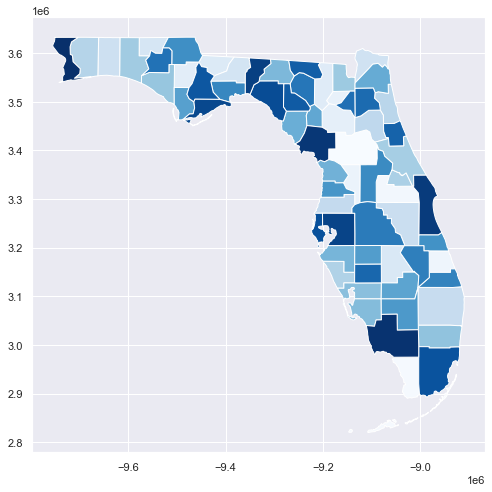

In [59]:
counties.plot(cmap="Blues")  

<AxesSubplot:>

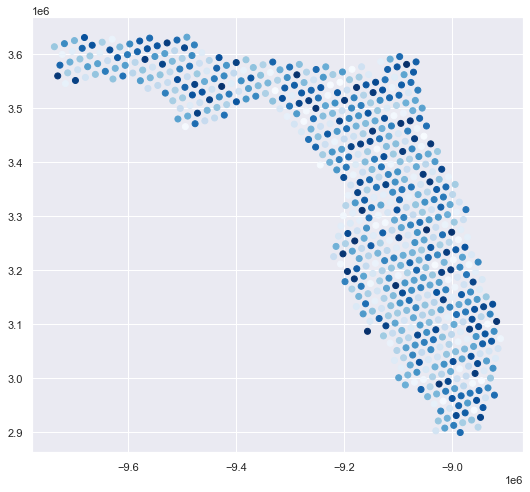

In [60]:
pythonWIPforCounty.plot(cmap="Blues")

In [61]:
counties.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
sjoinedCountyHex = gpd.sjoin(pythonWIPforCounty, counties, op='within', how='left')

In [63]:
sjoinedCountyHex

hex_id  pythonsPerHex  April  August  December  February  \
0    8544f563fffffff              0    0.0     0.0       0.0       0.0   
1    8544f6abfffffff              0    0.0     0.0       0.0       0.0   
2    8544e66ffffffff              0    0.0     0.0       0.0       0.0   
3    8544f577fffffff              0    0.0     0.0       0.0       0.0   
4    8544a1abfffffff             15    0.0     1.0       1.0       0.0   
..               ...            ...    ...     ...       ...       ...   
640  85441a13fffffff              2    0.0     0.0       0.0       0.0   
641  8544e0cffffffff              0    0.0     0.0       0.0       0.0   
642  8544a9c7fffffff              0    0.0     0.0       0.0       0.0   
643  8544f063fffffff              0    0.0     0.0       0.0       0.0   
644  85441337fffffff              0    0.0     0.0       0.0       0.0   

     January  July  June  March  ...  September  \
0        0.0   0.0   0.0    0.0  ...        0.0   
1        0.0   0.0   0.0    0.0  ...        0.0   
2        0.0   0.0   0.0    0.0  ...        0.0   
3        0.0   0.0   0.0    0.0  ...        0.0   
4        0.0   0.0   4.0    0.0  ...        2.0   
..       ...   ...   ...    ...  ...        ...   
640      0.0   0.0   1.0    0.0  ...        1.0   
641      0.0   0.0   0.0    0.0  ...        0.0   
642      0.0   0.0   0.0    0.0  ...        0.0   
643      0.0   0.0   0.0    0.0  ...        0.0   
644      0.0   0.0   0.0    0.0  ...        0.0   

                             geometry  index_right     id          GEO_ID  \
0    POINT (-9207516.672 3548365.864)           54  12047  0500000US12047   
1    POINT (-9051940.009 3448539.849)           53  12035  0500000US12035   
2    POINT (-9327679.828 3532866.582)           59  12123  0500000US12123   
3    POINT (-9225254.523 3543487.626)           48  12121  0500000US12121   
4    POINT (-8945144.691 2995470.907)           27  12011  0500000US12011   
..                                ...          ...    ...             ...   
640  POINT (-9180095.721 3254413.310)           61  12057  0500000US12057   
641  POINT (-9426702.725 3540788.136)           44  12129  0500000US12129   
642  POINT (-9046993.801 3274926.409)           15  12097  0500000US12097   
643  POINT (-9084038.825 3581581.452)           13  12089  0500000US12089   
644  POINT (-9156490.624 3086977.903)           29  12071  0500000US12071   

     STATE COUNTY          NAME    LSAD CENSUSAREA  
0       12    047      Hamilton  County    513.790  
1       12    035       Flagler  County    485.461  
2       12    123        Taylor  County   1043.305  
3       12    121      Suwannee  County    688.552  
4       12    011       Broward  County   1209.785  
..     ...    ...           ...     ...        ...  
640     12    057  Hillsborough  County   1020.214  
641     12    129       Wakulla  County    606.419  
642     12    097       Osceola  County   1327.453  
643     12    089        Nassau  County    648.639  
644     12    071           Lee  County    784.513  

[645 rows x 23 columns]

In [64]:
sjoinedCountyHex = sjoinedCountyHex[['hex_id','NAME']]

In [65]:
sjoinedCountyHex

hex_id          NAME
0    8544f563fffffff      Hamilton
1    8544f6abfffffff       Flagler
2    8544e66ffffffff        Taylor
3    8544f577fffffff      Suwannee
4    8544a1abfffffff       Broward
..               ...           ...
640  85441a13fffffff  Hillsborough
641  8544e0cffffffff       Wakulla
642  8544a9c7fffffff       Osceola
643  8544f063fffffff        Nassau
644  85441337fffffff           Lee

[645 rows x 2 columns]

In [66]:
pythons_hex = pythons_hex.merge(sjoinedCountyHex, on='hex_id', how="outer")

In [67]:
pythons_hex = pythons_hex.set_geometry('geometry')

In [68]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     March  May  November  October  September          NAME  
0      0.0  0.0       0.0      0.0        0.0      Hamilton  
1      0.0  0.0       0.0      0.0        0.0       Flagler  
2      0.0  0.0       0.0      0.0        0.0        Taylor  
3      0.0  0.0       0.0      0.0        0.0      Suwannee  
4      0.0  1.0       2.0      4.0        2.0       Broward  
..     ...  ...       ...      ...        ...           ...  
640    0.0  0.0       0.0      0.0        1.0  Hillsborough  
641    0.0  0.0       0.0      0.0        0.0       Wakulla  
642    0.0  0.0       0.0      0.0        0.0       Osceola  
643    0.0  0.0       0.0      0.0        0.0        Nassau  
644    0.0  0.0       0.0      0.0        0.0           Lee  

[645 rows x 16 columns]

# Binarize the County feature to the hex_id through One Hot Encode 

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [70]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()
encoder_df = encoder.fit_transform(pythons_hex[['NAME']])
column_name = encoder.get_feature_names_out(['NAME'])

In [71]:
one_hot_encoded_frame =  pd.DataFrame(encoder_df.todense(), columns= column_name)

In [72]:
one_hot_encoded_frame

NAME_Alachua  NAME_Baker  NAME_Bay  NAME_Bradford  NAME_Brevard  \
0             0.0         0.0       0.0            0.0           0.0   
1             0.0         0.0       0.0            0.0           0.0   
2             0.0         0.0       0.0            0.0           0.0   
3             0.0         0.0       0.0            0.0           0.0   
4             0.0         0.0       0.0            0.0           0.0   
..            ...         ...       ...            ...           ...   
640           0.0         0.0       0.0            0.0           0.0   
641           0.0         0.0       0.0            0.0           0.0   
642           0.0         0.0       0.0            0.0           0.0   
643           0.0         0.0       0.0            0.0           0.0   
644           0.0         0.0       0.0            0.0           0.0   

     NAME_Broward  NAME_Calhoun  NAME_Charlotte  NAME_Citrus  NAME_Clay  ...  \
0             0.0           0.0             0.0          0.0        0.0  ...   
1             0.0           0.0             0.0          0.0        0.0  ...   
2             0.0           0.0             0.0          0.0        0.0  ...   
3             0.0           0.0             0.0          0.0        0.0  ...   
4             1.0           0.0             0.0          0.0        0.0  ...   
..            ...           ...             ...          ...        ...  ...   
640           0.0           0.0             0.0          0.0        0.0  ...   
641           0.0           0.0             0.0          0.0        0.0  ...   
642           0.0           0.0             0.0          0.0        0.0  ...   
643           0.0           0.0             0.0          0.0        0.0  ...   
644           0.0           0.0             0.0          0.0        0.0  ...   

     NAME_St. Johns  NAME_St. Lucie  NAME_Sumter  NAME_Suwannee  NAME_Taylor  \
0               0.0             0.0          0.0            0.0          0.0   
1               0.0             0.0          0.0            0.0          0.0   
2               0.0             0.0          0.0            0.0          1.0   
3               0.0             0.0          0.0            1.0          0.0   
4               0.0             0.0          0.0            0.0          0.0   
..              ...             ...          ...            ...          ...   
640             0.0             0.0          0.0            0.0          0.0   
641             0.0             0.0          0.0            0.0          0.0   
642             0.0             0.0          0.0            0.0          0.0   
643             0.0             0.0          0.0            0.0          0.0   
644             0.0             0.0          0.0            0.0          0.0   

     NAME_Union  NAME_Volusia  NAME_Wakulla  NAME_Walton  NAME_Washington  
0           0.0           0.0           0.0          0.0              0.0  
1           0.0           0.0           0.0          0.0              0.0  
2           0.0           0.0           0.0          0.0              0.0  
3           0.0           0.0           0.0          0.0              0.0  
4           0.0           0.0           0.0          0.0              0.0  
..          ...           ...           ...          ...              ...  
640         0.0           0.0           0.0          0.0              0.0  
641         0.0           0.0           1.0          0.0              0.0  
642         0.0           0.0           0.0          0.0              0.0  
643         0.0           0.0           0.0          0.0              0.0  
644         0.0           0.0           0.0          0.0              0.0  

[645 rows x 67 columns]

In [73]:
pythons_hex = pythons_hex.join(one_hot_encoded_frame)

In [74]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_St. Johns  NAME_St. Lucie  NAME_Sumter  NAME_Suwannee  \
0    ...             0.0             0.0          0.0            0.0   
1    ...             0.0             0.0          0.0            0.0   
2    ...             0.0             0.0          0.0            0.0   
3    ...             0.0             0.0          0.0            1.0   
4    ...             0.0             0.0          0.0            0.0   
..   ...             ...             ...          ...            ...   
640  ...             0.0             0.0          0.0            0.0   
641  ...             0.0             0.0          0.0            0.0   
642  ...             0.0             0.0          0.0            0.0   
643  ...             0.0             0.0          0.0            0.0   
644  ...             0.0             0.0          0.0            0.0   

     NAME_Taylor NAME_Union  NAME_Volusia  NAME_Wakulla  NAME_Walton  \
0            0.0        0.0           0.0           0.0          0.0   
1            0.0        0.0           0.0           0.0          0.0   
2            1.0        0.0           0.0           0.0          0.0   
3            0.0        0.0           0.0           0.0          0.0   
4            0.0        0.0           0.0           0.0          0.0   
..           ...        ...           ...           ...          ...   
640          0.0        0.0           0.0           0.0          0.0   
641          0.0        0.0           0.0           1.0          0.0   
642          0.0        0.0           0.0           0.0          0.0   
643          0.0        0.0           0.0           0.0          0.0   
644          0.0        0.0           0.0           0.0          0.0   

     NAME_Washington  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
..               ...  
640              0.0  
641              0.0  
642              0.0  
643              0.0  
644              0.0  

[645 rows x 83 columns]

# Adding in Bird Sanctuary Data in a shapefile

In [75]:
birdSanctuaries = gpd.read_file('raw_data/Designated_Bird_Sanctuaries_in_Florida.shp')

In [76]:
birdSanctuaries = birdSanctuaries.to_crs(epsg=3857)
birdSanctuaries

OBJECTID                                   Name      County     ORDER_NO  \
0           1    Casselberry Restricted Hunting Area    Seminole    RHA 19-01   
1           2     Belle Isle Restricted Hunting Area      Orange    RHA 18-01   
2           3                        Harbour Heights   Charlotte  16E (73-24)   
3           4                    El Jobean-Gulf Cove   Charlotte    16E-75.48   
4           5                              Englewood   Charlotte   165 (67-2)   
..        ...                                    ...         ...          ...   
127       128                                Halifax     Volusia  16E (74-54)   
128       129                        10948 Acme Road  Palm Beach  165 (70-02)   
129       130                            Switzerland   St. Johns      BS 89-4   
130       131                    St. Augustine Beach   St. Johns    16E-75.68   
131       132  Hunter's Lake Restricted Hunting Area    Hernando    RHA 19-02   

    Notes                                           geometry  
0    None  MULTIPOLYGON (((-9052832.044 3327998.637, -905...  
1    None  POLYGON ((-9057844.695 3309165.527, -9057632.4...  
2    None  MULTIPOLYGON (((-9134635.212 3122016.620, -913...  
3    None  MULTIPOLYGON (((-9151979.702 3117818.260, -915...  
4    None  POLYGON ((-9163927.896 3116717.514, -9163958.0...  
..    ...                                                ...  
127  None  POLYGON ((-9021104.313 3409721.150, -9021109.7...  
128  None  POLYGON ((-8929850.618 3083116.892, -8929393.0...  
129  None  POLYGON ((-9080162.043 3518722.739, -9080160.6...  
130  None  POLYGON ((-9046417.283 3484021.793, -9046411.0...  
131  None  MULTIPOLYGON (((-9195888.721 3304102.273, -919...  

[132 rows x 6 columns]

In [77]:
birdSanctuaries.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

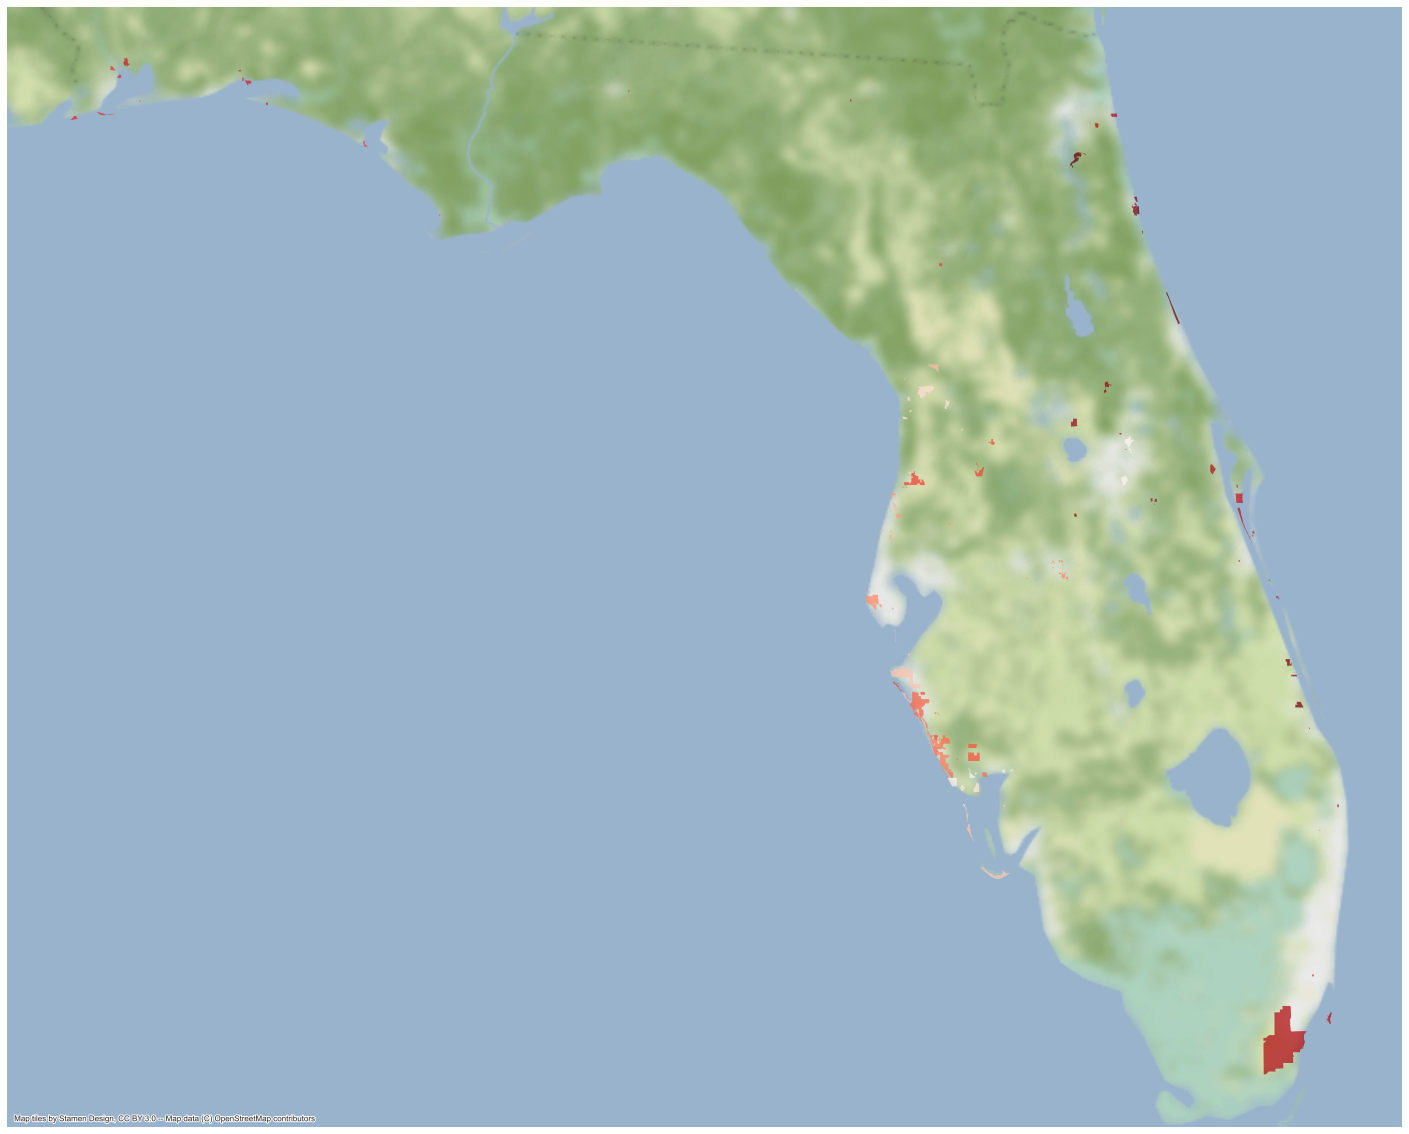

In [78]:
f, ax = plt.subplots(1, figsize=(25, 25))
birdSanctuaries.plot(
    column='OBJECTID', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=birdSanctuaries.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [79]:
#birdCentroid = birdSanctuaries.centroid
#birdCentroid = birdCentroid.reset_index(drop=True)

In [80]:
#birdCentroid = birdCentroid.to_crs(epsg=3857)

In [81]:
#birdCentroid.crs

In [82]:
distance = hexcentroid.geometry.apply(lambda x: birdSanctuaries.distance(x).min())

In [83]:
distance 

0      24590.999913
1      20792.596119
2      54501.551173
3      11530.446650
4      11968.838333
           ...     
640     7851.180500
641    38092.289337
642    20772.138403
643    41317.206195
644      214.656868
Length: 645, dtype: float64

In [84]:
pythons_hex['distanceToBirdSanctuaries'] = distance 

In [85]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_St. Lucie  NAME_Sumter  NAME_Suwannee  NAME_Taylor  NAME_Union  \
0    ...             0.0          0.0            0.0          0.0         0.0   
1    ...             0.0          0.0            0.0          0.0         0.0   
2    ...             0.0          0.0            0.0          1.0         0.0   
3    ...             0.0          0.0            1.0          0.0         0.0   
4    ...             0.0          0.0            0.0          0.0         0.0   
..   ...             ...          ...            ...          ...         ...   
640  ...             0.0          0.0            0.0          0.0         0.0   
641  ...             0.0          0.0            0.0          0.0         0.0   
642  ...             0.0          0.0            0.0          0.0         0.0   
643  ...             0.0          0.0            0.0          0.0         0.0   
644  ...             0.0          0.0            0.0          0.0         0.0   

    NAME_Volusia  NAME_Wakulla  NAME_Walton  NAME_Washington  \
0            0.0           0.0          0.0              0.0   
1            0.0           0.0          0.0              0.0   
2            0.0           0.0          0.0              0.0   
3            0.0           0.0          0.0              0.0   
4            0.0           0.0          0.0              0.0   
..           ...           ...          ...              ...   
640          0.0           0.0          0.0              0.0   
641          0.0           1.0          0.0              0.0   
642          0.0           0.0          0.0              0.0   
643          0.0           0.0          0.0              0.0   
644          0.0           0.0          0.0              0.0   

     distanceToBirdSanctuaries  
0                 24590.999913  
1                 20792.596119  
2                 54501.551173  
3                 11530.446650  
4                 11968.838333  
..                         ...  
640                7851.180500  
641               38092.289337  
642               20772.138403  
643               41317.206195  
644                 214.656868  

[645 rows x 84 columns]

# Adding in Eagle Nests 

In [86]:
eagleNests = gpd.read_file('raw_data/Eagle_Nesting.geojson')
eagleNests = eagleNests.to_crs(epsg=3857)
eagleNests

OBJECTID NestID   County NestTownsh NestRange NestSectio  GazPage  \
0         2549  AL001  Alachua        12S       22E         17       72   
1         2550  AL002  Alachua        11S       21E         25       66   
2         2551  AL003  Alachua        11S       22E         29       72   
3         2552  AL004  Alachua        11S       21E         25       66   
4         2553  AL005  Alachua        11S       22E         04       66   
...        ...    ...      ...        ...       ...        ...      ...   
2609      5158  VO133  Volusia        16S       32E         12       75   
2610      5159  VO134  Volusia        15S       33E         37       75   
2611      5160  VO135  Volusia        16S       33E         08       75   
2612      5161  VO136  Volusia        18S       35E         75       81   
2613      5162  VO137  Volusia        19S       33E         29       81   

      LastKnownA  LastSurvey     LatDec  ...  Act10 Active11 Active12  \
0           2011        2014  29.453500  ...      *        Y        *   
1           1994        2011  29.503333  ...      *        -        *   
2           2014        2014  29.499500  ...      *        Y        *   
3           1991        2011  29.505000  ...      *        -        *   
4           2014        2014  29.562000  ...      *        Y        *   
...          ...         ...        ...  ...    ...      ...      ...   
2609           0        2016  29.127000  ...      *        *        *   
2610        2016        2016  29.222667  ...      *        *        *   
2611        2016        2016  29.124333  ...      *        *        *   
2612        2016        2016  28.918667  ...      *        *        *   
2613        2016        2016  28.808500  ...      *        *        *   

     Active13 Active14 Active15           last_edited_date Active16 Active17  \
0           *        N        *  2017-09-19T23:51:32+00:00        *     None   
1           *        *        *  2017-09-19T23:51:32+00:00        *     None   
2           *        Y        *  2017-09-19T23:51:32+00:00        *     None   
3           *        *        *  2017-09-19T23:51:32+00:00        *     None   
4           *        Y        *  2017-09-19T23:51:32+00:00        *     None   
...       ...      ...      ...                        ...      ...      ...   
2609        *        *        *  2017-09-19T23:51:32+00:00        U     None   
2610        *        *        *  2017-09-19T23:51:32+00:00        Y     None   
2611        *        *        *  2017-09-19T23:51:32+00:00        Y     None   
2612        *        *        *  2017-09-19T23:51:32+00:00        Y     None   
2613        *        *        *  2017-09-19T23:51:32+00:00        Y     None   

                              geometry  
0     POINT (-9142744.029 3433494.022)  
1     POINT (-9146380.391 3439866.362)  
2     POINT (-9143152.126 3439376.110)  
3     POINT (-9146565.961 3440079.582)  
4     POINT (-9140870.077 3447372.362)  
...                                ...  
2609  POINT (-9022184.983 3391820.241)  
2610  POINT (-9021832.472 3404017.153)  
2611  POINT (-9018158.928 3391480.420)  
2612  POINT (-9002166.028 3365298.191)  
2613  POINT (-9021053.235 3351294.881)  

[2614 rows x 33 columns]

In [87]:
eagleNests.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [88]:
pythons_hex.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
eagle_hex = gpd.sjoin(eagleNests, pythons_hex, op='within', how='left')

In [90]:
eagle_hex

OBJECTID NestID   County NestTownsh NestRange NestSectio  GazPage  \
0         2549  AL001  Alachua        12S       22E         17       72   
1         2550  AL002  Alachua        11S       21E         25       66   
2         2551  AL003  Alachua        11S       22E         29       72   
3         2552  AL004  Alachua        11S       21E         25       66   
4         2553  AL005  Alachua        11S       22E         04       66   
...        ...    ...      ...        ...       ...        ...      ...   
2609      5158  VO133  Volusia        16S       32E         12       75   
2610      5159  VO134  Volusia        15S       33E         37       75   
2611      5160  VO135  Volusia        16S       33E         08       75   
2612      5161  VO136  Volusia        18S       35E         75       81   
2613      5162  VO137  Volusia        19S       33E         29       81   

      LastKnownA  LastSurvey     LatDec  ...  NAME_St. Lucie NAME_Sumter  \
0           2011        2014  29.453500  ...             0.0         0.0   
1           1994        2011  29.503333  ...             0.0         0.0   
2           2014        2014  29.499500  ...             0.0         0.0   
3           1991        2011  29.505000  ...             0.0         0.0   
4           2014        2014  29.562000  ...             0.0         0.0   
...          ...         ...        ...  ...             ...         ...   
2609           0        2016  29.127000  ...             0.0         0.0   
2610        2016        2016  29.222667  ...             NaN         NaN   
2611        2016        2016  29.124333  ...             0.0         0.0   
2612        2016        2016  28.918667  ...             0.0         0.0   
2613        2016        2016  28.808500  ...             0.0         0.0   

     NAME_Suwannee NAME_Taylor NAME_Union NAME_Volusia NAME_Wakulla  \
0              0.0         0.0        0.0          0.0          0.0   
1              0.0         0.0        0.0          0.0          0.0   
2              0.0         0.0        0.0          0.0          0.0   
3              0.0         0.0        0.0          0.0          0.0   
4              0.0         0.0        0.0          0.0          0.0   
...            ...         ...        ...          ...          ...   
2609           0.0         0.0        0.0          1.0          0.0   
2610           NaN         NaN        NaN          NaN          NaN   
2611           0.0         0.0        0.0          1.0          0.0   
2612           0.0         0.0        0.0          1.0          0.0   
2613           0.0         0.0        0.0          0.0          0.0   

     NAME_Walton NAME_Washington distanceToBirdSanctuaries  
0            0.0             0.0              40967.072231  
1            0.0             0.0              23057.963207  
2            0.0             0.0              23057.963207  
3            0.0             0.0              23057.963207  
4            0.0             0.0              39254.916303  
...          ...             ...                       ...  
2609         0.0             0.0              22214.535732  
2610         NaN             NaN                       NaN  
2611         0.0             0.0              22214.535732  
2612         0.0             0.0              38992.914731  
2613         0.0             0.0              25619.489497  

[2614 rows x 117 columns]

In [91]:
grouped = eagle_hex.groupby(['hex_id'])['OBJECTID'].agg('count').reset_index()

grouped = grouped.rename(columns={"OBJECTID": "eagleNestsPerHex"})
grouped.sort_values(by='eagleNestsPerHex', ascending=False)

hex_id  eagleNestsPerHex
357  8544f44ffffffff                61
353  8544f43bfffffff                46
356  8544f44bfffffff                40
160  8544a963fffffff                36
165  8544a977fffffff                35
..               ...               ...
277  8544e0a3fffffff                 1
278  8544e0b7fffffff                 1
279  8544e0cffffffff                 1
280  8544e193fffffff                 1
0    8544120bfffffff                 1

[414 rows x 2 columns]

In [92]:
pythons_hex = pythons_hex.merge(grouped, on='hex_id', how="outer")

pythons_hex.fillna(0, inplace=True)

pythons_hex['eagleNestsPerHex'] = pythons_hex['eagleNestsPerHex'].astype(int)

pythons_hex.sort_values(by='distanceToBirdSanctuaries', ascending=False)

hex_id                                           geometry  \
98   8544f597fffffff  POLYGON ((-9276049.873 3445551.568, -9268639.2...   
115  8544e64bfffffff  POLYGON ((-9289268.706 3459713.497, -9281847.1...   
122  8544ac83fffffff  POLYGON ((-9024295.117 3028811.835, -9017178.6...   
584  8544acabfffffff  POLYGON ((-9027336.657 3079193.982, -9020193.4...   
53   8544e64ffffffff  POLYGON ((-9302533.703 3473895.645, -9295101.1...   
..               ...                                                ...   
570  8544a187fffffff  POLYGON ((-8951924.155 2948470.862, -8944875.3...   
546  8544a183fffffff  POLYGON ((-8940009.154 2935167.096, -8932971.6...   
5    8544a197fffffff  POLYGON ((-8956523.944 2930264.040, -8949482.5...   
242  8544a903fffffff  POLYGON ((-9052210.963 3296671.787, -9044947.1...   
92   85441e57fffffff  POLYGON ((-9174503.197 3122092.893, -9167289.0...   

     pythonsPerHex  April  August  December  February  January  July  June  \
98               0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
115              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
122              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
584              1    0.0     0.0       0.0       0.0      1.0   0.0   0.0   
53               0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
570             41    4.0     6.0       4.0       0.0      2.0   6.0   4.0   
546             43    2.0     5.0       3.0       5.0      4.0   2.0   3.0   
5              189    8.0    30.0      12.0       5.0     12.0  45.0  19.0   
242              1    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
92               0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Sumter  NAME_Suwannee  NAME_Taylor  NAME_Union  NAME_Volusia  \
98   ...          0.0            0.0          0.0         0.0           0.0   
115  ...          0.0            0.0          1.0         0.0           0.0   
122  ...          0.0            0.0          0.0         0.0           0.0   
584  ...          0.0            0.0          0.0         0.0           0.0   
53   ...          0.0            0.0          1.0         0.0           0.0   
..   ...          ...            ...          ...         ...           ...   
570  ...          0.0            0.0          0.0         0.0           0.0   
546  ...          0.0            0.0          0.0         0.0           0.0   
5    ...          0.0            0.0          0.0         0.0           0.0   
242  ...          0.0            0.0          0.0         0.0           0.0   
92   ...          0.0            0.0          0.0         0.0           0.0   

    NAME_Wakulla  NAME_Walton  NAME_Washington  distanceToBirdSanctuaries  \
98           0.0          0.0              0.0              103604.616382   
115          0.0          0.0              0.0              101533.310470   
122          0.0          0.0              0.0              100462.866605   
584          0.0          0.0              0.0              100269.158117   
53           0.0          0.0              0.0               99668.197791   
..           ...          ...              ...                        ...   
570          0.0          0.0              0.0                   0.000000   
546          0.0          0.0              0.0                   0.000000   
5            0.0          0.0              0.0                   0.000000   
242          0.0          0.0              0.0                   0.000000   
92           0.0          0.0              0.0                   0.000000   

     eagleNestsPerHex  
98                  0  
115                 5  
122                 0  
584                 0  
53                  8  
..                ...  
570                 0  
546                 0  
5                   0  
242                 8  
92                 10  

[645 rows x 8

In [93]:
distance = hexcentroid.geometry.apply(lambda x: eagleNests.distance(x).min())

In [94]:
pythons_hex['distanceToEagleNests'] = distance 

In [95]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Suwannee  NAME_Taylor  NAME_Union  NAME_Volusia  NAME_Wakulla  \
0    ...            0.0          0.0         0.0           0.0           0.0   
1    ...            0.0          0.0         0.0           0.0           0.0   
2    ...            0.0          1.0         0.0           0.0           0.0   
3    ...            1.0          0.0         0.0           0.0           0.0   
4    ...            0.0          0.0         0.0           0.0           0.0   
..   ...            ...          ...         ...           ...           ...   
640  ...            0.0          0.0         0.0           0.0           0.0   
641  ...            0.0          0.0         0.0           0.0           1.0   
642  ...            0.0          0.0         0.0           0.0           0.0   
643  ...            0.0          0.0         0.0           0.0           0.0   
644  ...            0.0          0.0         0.0           0.0           0.0   

    NAME_Walton  NAME_Washington  distanceToBirdSanctuaries  eagleNestsPerHex  \
0           0.0              0.0               24590.999913                 2   
1           0.0              0.0               20792.596119                 0   
2           0.0              0.0               54501.551173                 0   
3           0.0              0.0               11530.446650                 0   
4           0.0              0.0               11968.838333                 3   
..          ...              ...                        ...               ...   
640         0.0              0.0                7851.180500                 7   
641         0.0              0.0               38092.289337                 1   
642         0.0              0.0               20772.138403                27   
643         0.0              0.0               41317.206195                 1   
644         0.0              0.0                 214.656868                 6   

     distanceToEagleNests  
0             4422.448039  
1            10673.143969  
2            16996.059482  
3            10354.216996  
4             2206.060865  
..                    ...  
640           4208.080581  
641           7548

# Bird Nests 2000

In [96]:
nests2000 = gpd.read_file('raw_data/ESI_Bird_Nests_2000.geojson')
nests2000 = nests2000.to_crs(epsg=3857)
nests2000

OBJECTID  RARNUM  BIOGWIS_RA  SPECIES_ID  SEASON_ID     EL_RAR  EL_SPE  \
0            1      44          44          86          2    BIRD_44  B00086   
1            2      45          45          86          2    BIRD_45  B00086   
2            3      47          47          60          1    BIRD_47  B00060   
3            4      47          47          66          1    BIRD_47  B00066   
4            5      47          47          67          1    BIRD_47  B00067   
...        ...     ...         ...         ...        ...        ...     ...   
5690      5691    1092        1092          73          1  BIRD_1092  B00073   
5691      5692    1092        1092          73          1  BIRD_1092  B00073   
5692      5693    1092        1092         142          1  BIRD_1092  B00142   
5693      5694    1092        1092         142          1  BIRD_1092  B00142   
5694      5695    1092        1092         142          1  BIRD_1092  B00142   

     EL_SPE_SEA  GEO_SRC  SEASON_SRC  ... ACTIVE_SEP ACTIVE_OCT ACTIVE_NOV  \
0      B0008602       32          37  ...                                    
1      B0008602       32          37  ...                                    
2      B0006001       32          37  ...                                    
3      B0006601       32          37  ...                                    
4      B0006701       32          37  ...                                    
...         ...      ...         ...  ...        ...        ...        ...   
5690   B0007301       32          37  ...                                    
5691   B0007301       32          37  ...                                    
5692   B0014201       32          37  ...                                    
5693   B0014201       32          37  ...                                    
5694   B0014201       32          37  ...                                    

     ACTIVE_DEC                                           ESI_INFO  \
0                Least tern; Status: Threatened (FL); Present: ...   
1                Least tern; Status: Threatened (FL); Present: ...   
2                Red knot; Status:  ; Present: Jan Feb Mar Apr ...   
3                Western sandpiper; Status:  ; Present: Jan Feb...   
4                Sanderling; Status:  ; Present: Jan Feb Mar Ap...   
...         ...                                                ...   
5690             Ruddy turnstone; Status:  ; Present: Jan Feb M...   
5691             Ruddy turnstone; Status:  ; Present: Jan Feb M...   
5692             Black-necked stilt; Status:  ; Present: Jan Fe...   
5693             Black-necked stilt; Status:  ; Present: Jan Fe...   
5694             Black-necked stilt; Status:  ; Present: Jan Fe...   

     created_user created_date last_edited_user last_edited_date  \
0            None         None             None             None   
1            None         None             None             None   
2            None         None             None             None   
3            None         None             None             None   
4            None         None             None             None   
...           ...          ...              ...              ...   
5690         None         None             None             None   
5691         None         None             None             None   
5692         None         None             None             None   
5693         None         None             None             None   
5694         None         None             None             None   

                              geometry  
0     POINT (-9031140.824 3436915.309)  
1     POINT (-9025017.959 3421579.699)  
2     POINT (-9022561.266 3415974.752)  
3     POINT (-9022561.266 3415974.752)  
4     POINT (-9022561.266 3415974.752)  
...                                ...  
5690  POINT (-9355737.145 3513657.556)  
5691  POINT (-9355542.202 3513735.550)  
5692  POINT (-9355749.251 3513796.345)  
5693  POINT (-9355737.145 3513657.556)  

In [97]:
nests2000

OBJECTID  RARNUM  BIOGWIS_RA  SPECIES_ID  SEASON_ID     EL_RAR  EL_SPE  \
0            1      44          44          86          2    BIRD_44  B00086   
1            2      45          45          86          2    BIRD_45  B00086   
2            3      47          47          60          1    BIRD_47  B00060   
3            4      47          47          66          1    BIRD_47  B00066   
4            5      47          47          67          1    BIRD_47  B00067   
...        ...     ...         ...         ...        ...        ...     ...   
5690      5691    1092        1092          73          1  BIRD_1092  B00073   
5691      5692    1092        1092          73          1  BIRD_1092  B00073   
5692      5693    1092        1092         142          1  BIRD_1092  B00142   
5693      5694    1092        1092         142          1  BIRD_1092  B00142   
5694      5695    1092        1092         142          1  BIRD_1092  B00142   

     EL_SPE_SEA  GEO_SRC  SEASON_SRC  ... ACTIVE_SEP ACTIVE_OCT ACTIVE_NOV  \
0      B0008602       32          37  ...                                    
1      B0008602       32          37  ...                                    
2      B0006001       32          37  ...                                    
3      B0006601       32          37  ...                                    
4      B0006701       32          37  ...                                    
...         ...      ...         ...  ...        ...        ...        ...   
5690   B0007301       32          37  ...                                    
5691   B0007301       32          37  ...                                    
5692   B0014201       32          37  ...                                    
5693   B0014201       32          37  ...                                    
5694   B0014201       32          37  ...                                    

     ACTIVE_DEC                                           ESI_INFO  \
0                Least tern; Status: Threatened (FL); Present: ...   
1                Least tern; Status: Threatened (FL); Present: ...   
2                Red knot; Status:  ; Present: Jan Feb Mar Apr ...   
3                Western sandpiper; Status:  ; Present: Jan Feb...   
4                Sanderling; Status:  ; Present: Jan Feb Mar Ap...   
...         ...                                                ...   
5690             Ruddy turnstone; Status:  ; Present: Jan Feb M...   
5691             Ruddy turnstone; Status:  ; Present: Jan Feb M...   
5692             Black-necked stilt; Status:  ; Present: Jan Fe...   
5693             Black-necked stilt; Status:  ; Present: Jan Fe...   
5694             Black-necked stilt; Status:  ; Present: Jan Fe...   

     created_user created_date last_edited_user last_edited_date  \
0            None         None             None             None   
1            None         None             None             None   
2            None         None             None             None   
3            None         None             None             None   
4            None         None             None             None   
...           ...          ...              ...              ...   
5690         None         None             None             None   
5691         None         None             None             None   
5692         None         None             None             None   
5693         None         None             None             None   
5694         None         None             None             None   

                              geometry  
0     POINT (-9031140.824 3436915.309)  
1     POINT (-9025017.959 3421579.699)  
2     POINT (-9022561.266 3415974.752)  
3     POINT (-9022561.266 3415974.752)  
4     POINT (-9022561.266 3415974.752)  
...                                ...  
5690  POINT (-9355737.145 3513657.556)  
5691  POINT (-9355542.202 3513735.550)  
5692  POINT (-9355749.251 3513796.345)  
5693  POINT (-9355737.145 3513657.556)  

In [98]:
distance = hexcentroid.geometry.apply(lambda x: nests2000.distance(x).min())

In [99]:
distance

0      108520.434520
1       10950.561499
2       20379.310294
3       99854.201794
4       19083.982586
           ...      
640      8758.388839
641     47066.555264
642     58371.293434
643      7743.226128
644      2815.448791
Length: 645, dtype: float64

In [100]:
pythons_hex['distanceToBirdNests2000'] = distance 

In [101]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Taylor  NAME_Union  NAME_Volusia  NAME_Wakulla  NAME_Walton  \
0    ...          0.0         0.0           0.0           0.0          0.0   
1    ...          0.0         0.0           0.0           0.0          0.0   
2    ...          1.0         0.0           0.0           0.0          0.0   
3    ...          0.0         0.0           0.0           0.0          0.0   
4    ...          0.0         0.0           0.0           0.0          0.0   
..   ...          ...         ...           ...           ...          ...   
640  ...          0.0         0.0           0.0           0.0          0.0   
641  ...          0.0         0.0           0.0           1.0          0.0   
642  ...          0.0         0.0           0.0           0.0          0.0   
643  ...          0.0         0.0           0.0           0.0          0.0   
644  ...          0.0         0.0           0.0           0.0          0.0   

    NAME_Washington  distanceToBirdSanctuaries  eagleNestsPerHex  \
0               0.0               24590.999913                 2   
1               0.0               20792.596119                 0   
2               0.0               54501.551173                 0   
3               0.0               11530.446650                 0   
4               0.0               11968.838333                 3   
..              ...                        ...               ...   
640             0.0                7851.180500                 7   
641             0.0               38092.289337                 1   
642             0.0               20772.138403                27   
643             0.0               41317.206195                 1   
644             0.0                 214.656868                 6   

     distanceToEagleNests  distanceToBirdNests2000  
0             4422.448039            108520.434520  
1            10673.143969             10950.561499  
2            16996.059482             20379.310294  
3            10354.216996             99854.201794  
4             2206.060865             19083.982586  
..                    ...                      ...  
640           4208.080581              8758.388839 

# Land Mammal Habitats 

In [102]:
mammalHabitats = gpd.read_file('raw_data/ESI_Land_Mammal_Habitat_Areas.geojson')
mammalHabitats = mammalHabitats.to_crs(epsg=3857)
mammalHabitats

OBJECTID    RARNUM  SPECIES_ID  SEASON_ID             EL_RAR  EL_SPE  \
0          2  20031264         103          1  T_MAMMAL_20031264  T00103   
1          3  20032198         103          1  T_MAMMAL_20032198  T00103   
2          4  20032253          38          1  T_MAMMAL_20032253  T00038   
3          5  20130902          25          1  T_MAMMAL_20130902  T00025   
4          6  20131093          77          1  T_MAMMAL_20131093  T00077   
5          7  20130925          73          1  T_MAMMAL_20130925  T00073   
6          8  20032260           8          1  T_MAMMAL_20032260  T00008   
7          9  20032273          76          1  T_MAMMAL_20032273  T00076   
8         10  20120175          67          1  T_MAMMAL_20120175  T00067   
9         11  20031613          12          1  T_MAMMAL_20031613  T00012   
10        12  20032234           8          1  T_MAMMAL_20032234  T00008   
11        13  20032234          38          1  T_MAMMAL_20032234  T00038   
12        14  20131187          72          1  T_MAMMAL_20131187  T00072   
13        15  20131187          71          1  T_MAMMAL_20131187  T00071   
14        16  20120045         205          1  T_MAMMAL_20120045  T00205   
15        17  20120412          80          1  T_MAMMAL_20120412  T00080   
16        18  20032254         204          1  T_MAMMAL_20032254  T00204   
17        19  20120273          69          1  T_MAMMAL_20120273  T00069   
18        20  20032258           8          1  T_MAMMAL_20032258  T00008   
19        21  20031773          78          1  T_MAMMAL_20031773  T00078   
20        22  20032334          38          1  T_MAMMAL_20032334  T00038   
21        23  20032189         204          1  T_MAMMAL_20032189  T00204   
22        24  20120392          75          1  T_MAMMAL_20120392  T00075   
23        25  20120030         103          1  T_MAMMAL_20120030  T00103   
24        26  20031832          68          1  T_MAMMAL_20031832  T00068   
25        27  20032383           8          1  T_MAMMAL_20032383  T00008   
26        28  20032259           8          1  T_MAMMAL_20032259  T00008   
27        29  20031822         105          1  T_MAMMAL_20031822  T00105   
28        30  20031830          68          1  T_MAMMAL_20031830  T00068   
29        31  20031767          78          1  T_MAMMAL_20031767  T00078   

      EL_SPE_SEA   GEO_SRC  SEASON_SRC  CONCENTRA  ... T_MAMMAL_RARNUM  \
0   T00103012003  20030163    20030040             ...        20031264   
1   T00103012003  20030137    20030137  POTENTIAL  ...        20032198   
2   T00038012003  20030168    20030040       HIGH  ...        20032253   
3   T00025012013  20130063    20130087             ...        20130902   
4   T00077012013  20130060    20130087             ...        20131093   
5   T00073012013  20130088    20130087             ...        20130925   
6   T00008012003  20030133    20030133       HIGH  ...        20032260   
7   T00076012003  40060168    20030040             ...        20032273   
8   T00067012012  20120096    20120096             ...        20120175   
9   T00012012003  20030169    20030040        POT  ...        20031613   
10  T00008012003  20030168    20030040        MED  ...        20032234   
11  T00038012003  20030168    20030040        MED  ...        20032234   
12  T00072012013  20130059    20130087             ...        20131187   
13  T00071012013  20130061    20130087             ...        20131187   
14  T00205012012  20120103    20120104             ...        20120045   
15  T00080012012  20120027    20120027             ...        20120412   
16  T00204012003  20030168    20030040       HIGH  ...        20032254   
17  T00069012012  20120023    20120023             ...        20120273   
18  T00008012003  20030133    20030133        MED  ...        20032258   
19  T00078012003  20030169    20030040             ...        20031773   
20  T00038012003  20030168    20030040        MED  ...        20032334   
21  T00204012003  2

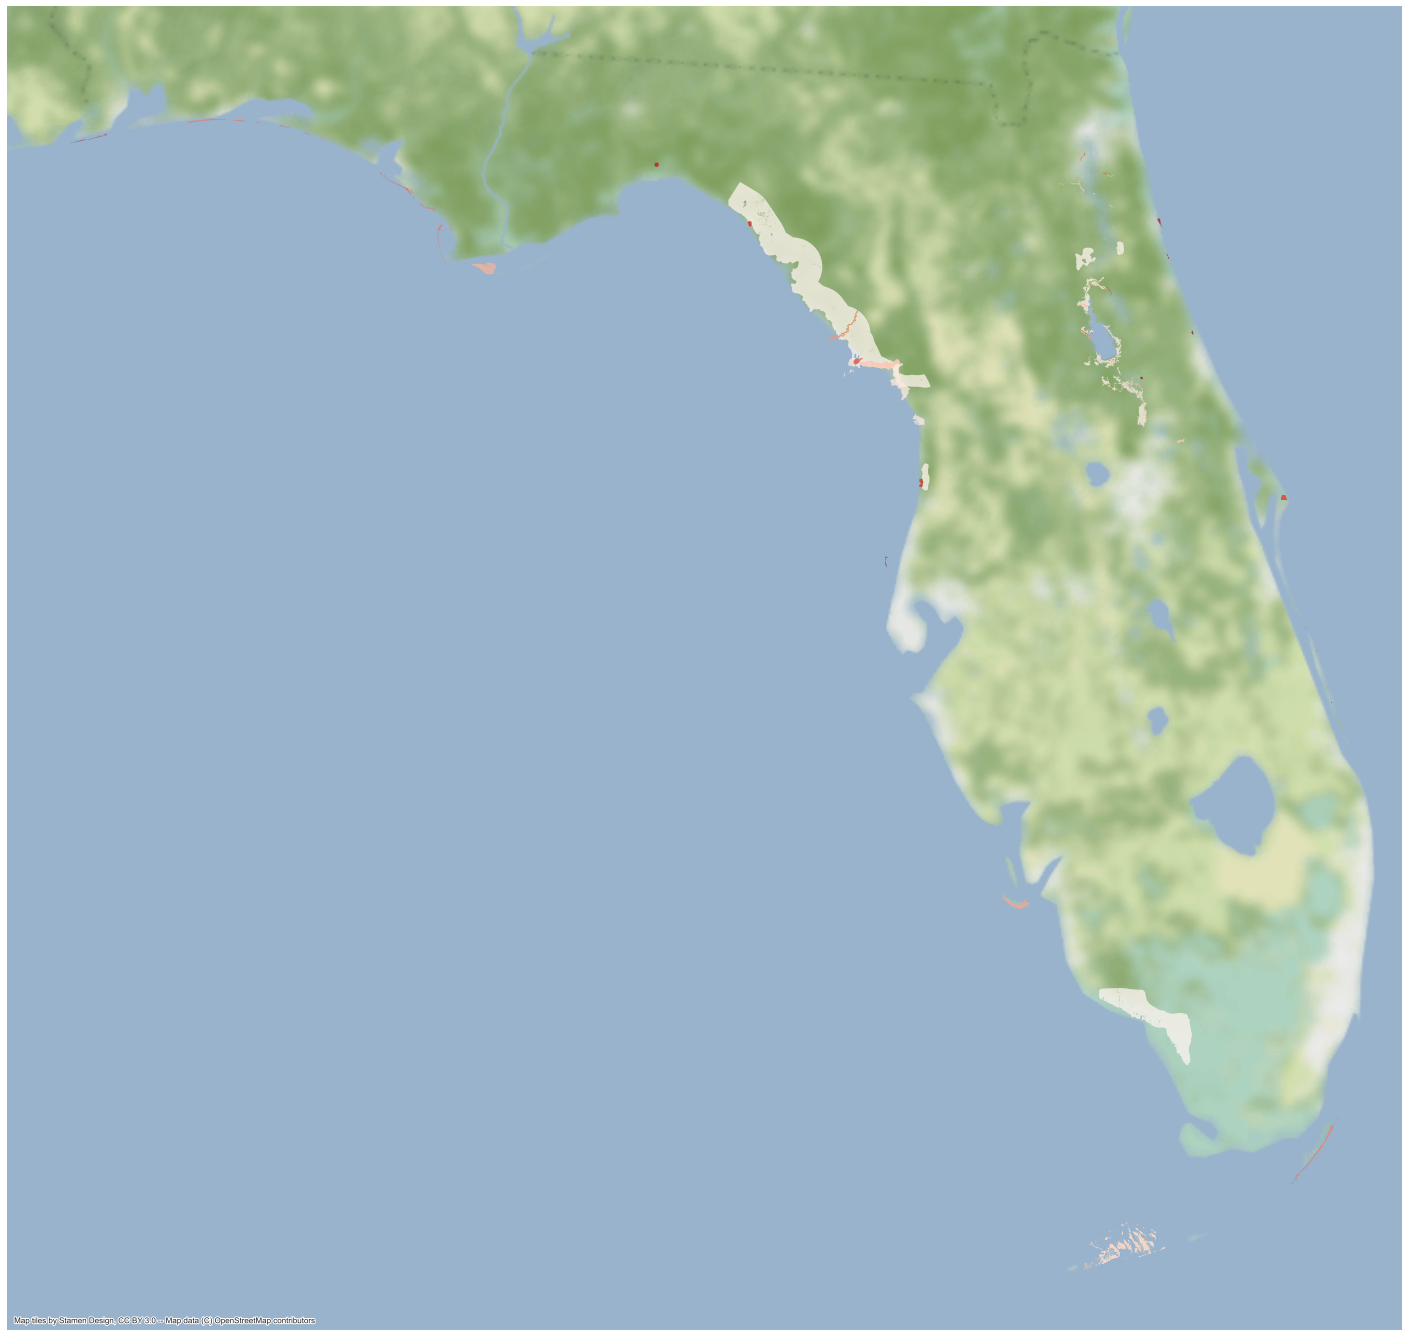

In [103]:
f, ax = plt.subplots(1, figsize=(25, 25))
mammalHabitats.plot(
    column='OBJECTID', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=mammalHabitats.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [104]:
mammalCentroid = mammalHabitats.centroid
mammalCentroid = mammalCentroid.reset_index(drop=True)

mammalCentroid = mammalCentroid.to_crs(epsg=3857)

mammalCentroid.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [105]:
distance = hexcentroid.geometry.apply(lambda x: mammalCentroid.distance(x).min())

In [106]:
distance

0      118142.107993
1       21064.224233
2       43333.136642
3      100498.436779
4       96270.978172
           ...      
640     46406.969981
641     58122.291239
642     86185.729875
643     98549.522765
644     37006.088188
Length: 645, dtype: float64

In [107]:
pythons_hex['distanceToMammalHabitats'] = distance 

In [108]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Union  NAME_Volusia  NAME_Wakulla  NAME_Walton  \
0    ...         0.0           0.0           0.0          0.0   
1    ...         0.0           0.0           0.0          0.0   
2    ...         0.0           0.0           0.0          0.0   
3    ...         0.0           0.0           0.0          0.0   
4    ...         0.0           0.0           0.0          0.0   
..   ...         ...           ...           ...          ...   
640  ...         0.0           0.0           0.0          0.0   
641  ...         0.0           0.0           1.0          0.0   
642  ...         0.0           0.0           0.0          0.0   
643  ...         0.0           0.0           0.0          0.0   
644  ...         0.0           0.0           0.0          0.0   

     NAME_Washington distanceToBirdSanctuaries  eagleNestsPerHex  \
0                0.0              24590.999913                 2   
1                0.0              20792.596119                 0   
2                0.0              54501.551173                 0   
3                0.0              11530.446650                 0   
4                0.0              11968.838333                 3   
..               ...                       ...               ...   
640              0.0               7851.180500                 7   
641              0.0              38092.289337                 1   
642              0.0              20772.138403                27   
643              0.0              41317.206195                 1   
644              0.0                214.656868                 6   

     distanceToEagleNests  distanceToBirdNests2000  distanceToMammalHabitats  
0             4422.448039            108520.434520             118142.107993  
1            10673.143969             10950.561499              21064.224233  
2            16996.059482             20379.310294              43333.136642  
3            10354.216996             99854.201794             100498.436779  
4             2206.060865             19083.982586              96270.978172  
..                    ...                      ...                       ...  
640           4208.080581

# Bird Habitat Areas 2003 

In [109]:
birdHabitats = gpd.read_file('raw_data/ESI_Bird_Habitat_Areas_2003.geojson')
birdHabitats = birdHabitats.to_crs(epsg=3857)
birdHabitats

OBJECTID  RARNUM  BIOGWIS_RA  SPECIES_ID  SEASON_ID     EL_RAR  EL_SPE  \
0            1    1633        1633        1002          1  BIRD_1633  B01002   
1            2    1634        1634         152          1  BIRD_1634  B00152   
2            3    1641        1641          60          1  BIRD_1641  B00060   
3            4    1641        1641          63          1  BIRD_1641  B00063   
4            5    1641        1641          66          1  BIRD_1641  B00066   
...        ...     ...         ...         ...        ...        ...     ...   
1230      1231    1836        1836         121          2  BIRD_1836  B00121   
1231      1232    1836        1836         163          2  BIRD_1836  B00163   
1232      1233    1838        1838           8          2  BIRD_1838  B00008   
1233      1234    1838        1838          90          2  BIRD_1838  B00090   
1234      1235    1838        1838         121          2  BIRD_1838  B00121   

     EL_SPE_SEA  GEO_SRC  SEASON_SRC  ... ACTIVE_DEC    SHAPE_LENG  \
0      B0100201      173          37  ...              4172.769019   
1      B0015201      173          37  ...             10330.690269   
2      B0006001      173          37  ...             13138.886986   
3      B0006301      173          37  ...             13138.886986   
4      B0006601      173          37  ...             13138.886986   
...         ...      ...         ...  ...        ...           ...   
1230   B0012102      164          37  ...              1653.152855   
1231   B0016302      164          37  ...    Nesting   1653.152855   
1232   B0000802      164          37  ...               710.951645   
1233   B0009002      164          37  ...    Nesting    710.951645   
1234   B0012102      164          37  ...               710.951645   

                                               ESI_INFO created_user  \
0     Shorebirds; Status:  ; Present: Jan Feb Mar Ap...         None   
1     American oystercatcher; Status:  ; Present: Ja...         None   
2     Red knot; Status:  ; Present: Jan Feb Mar Apr ...         None   
3     Dunlin; Status:  ; Present: Jan Feb Mar Apr Ma...         None   
4     Western sandpiper; Status:  ; Present: Jan Feb...         None   
...                                                 ...          ...   
1230  Anhinga; Status:  ; Present: Jan Feb Mar Apr M...         None   
1231  Reddish egret; Status:  ; Present: Jan Feb Mar...         None   
1232  Double-crested cormorant; Status:  ; Present: ...         None   
1233  Black-crowned night-heron; Status:  ; Present:...         None   
1234  Anhinga; Status:  ; Present: Jan Feb Mar Apr M...         None   

     created_date last_edited_user last_edited_date     Shapearea  \
0            None             None             None  1.311812e+06   
1            None             None             None  1.577585e+06   
2            None             None             None  1.677014e+07   
3            None             None             None  1.677014e+07   
4            None             None             None  1.677014e+07   
...           ...              ...              ...           ...   
1230         None             None             None  2.424266e+05   
1231         None             None             None  2.424266e+05   
1232         None             None             None  5.295776e+04   
1233         None             None             None  5.295776e+04   
1234         None             None             None  5.295776e+04   

          Shapelen                                           geometry  
0      4648.109661  POLYGON ((-9098089.505 2987875.942, -9098090.6...  
1     11504.434373  MULTIPOLYGON (((-9092526.689 2984601.498, -909...  
2     14627.345786  POLYGON ((-9089261.413 2977958.953, -9089261.8...  
3     14627.345786  POLYGON ((-9089261.413 2977958.953, -9089261.8...  
4     14627.345786  POLYGON ((-9089261.413 2977958.953, -9089261.8...  
...            ...                                                ...  
1230  

In [110]:
birdhabitatcentroid = birdHabitats.centroid
birdhabitatcentroid = birdhabitatcentroid.reset_index(drop=True)

birdhabitatcentroid = birdhabitatcentroid.to_crs(epsg=3857)

birdhabitatcentroid.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [111]:
distance = hexcentroid.geometry.apply(lambda x: birdhabitatcentroid.distance(x).min())

In [112]:
distance

0      115805.490571
1       20085.326833
2       27745.102145
3      104319.869981
4       25210.039502
           ...      
640     13721.909515
641     41754.982915
642     65549.975584
643     19919.716293
644      4274.479389
Length: 645, dtype: float64

In [113]:
pythons_hex['distance2003BirdHabitats'] = distance 

In [114]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Volusia  NAME_Wakulla  NAME_Walton  NAME_Washington  \
0    ...           0.0           0.0          0.0              0.0   
1    ...           0.0           0.0          0.0              0.0   
2    ...           0.0           0.0          0.0              0.0   
3    ...           0.0           0.0          0.0              0.0   
4    ...           0.0           0.0          0.0              0.0   
..   ...           ...           ...          ...              ...   
640  ...           0.0           0.0          0.0              0.0   
641  ...           0.0           1.0          0.0              0.0   
642  ...           0.0           0.0          0.0              0.0   
643  ...           0.0           0.0          0.0              0.0   
644  ...           0.0           0.0          0.0              0.0   

     distanceToBirdSanctuaries eagleNestsPerHex  distanceToEagleNests  \
0                 24590.999913                2           4422.448039   
1                 20792.596119                0          10673.143969   
2                 54501.551173                0          16996.059482   
3                 11530.446650                0          10354.216996   
4                 11968.838333                3           2206.060865   
..                         ...              ...                   ...   
640                7851.180500                7           4208.080581   
641               38092.289337                1           7548.353942   
642               20772.138403               27           2663.122245   
643               41317.206195                1           8347.737149   
644                 214.656868                6           1762.690341   

     distanceToBirdNests2000  distanceToMammalHabitats  \
0              108520.434520             118142.107993   
1               10950.561499              21064.224233   
2               20379.310294              43333.136642   
3               99854.201794             100498.436779   
4               19083.982586              96270.978172   
..                       ...                       ...   
640              8758.388839              46406.9699

# Shorebird Habitats

In [115]:
shorebirds = pd.read_csv('raw_data/Florida_Shorebird_Database.csv', low_memory=False)

In [116]:
shorebirds

X          Y  OBJECTID RecordStatus  \
0     -85.735346  30.177044     80801     Approved   
1     -85.735346  30.177044     80802     Approved   
2     -85.735346  30.177044     80803     Approved   
3     -85.735346  30.177044     80804     Approved   
4     -85.735346  30.177044     80805     Approved   
...          ...        ...       ...          ...   
80559 -86.309995  30.366284    161360     Approved   
80560 -86.309995  30.366284    161361     Approved   
80561 -86.309995  30.366284    161362     Approved   
80562 -86.309995  30.366284    161363     Approved   
80563 -86.309995  30.366284    161364     Approved   

                    LocationVisitID        LocationID  \
0      P9003.2014.T0004.20180322.01  P9003.2014.T0004   
1      P9003.2014.T0004.20180427.01  P9003.2014.T0004   
2      P9003.2014.T0004.20180427.01  P9003.2014.T0004   
3      P9003.2014.T0004.20180521.01  P9003.2014.T0004   
4      P9003.2014.T0004.20180521.01  P9003.2014.T0004   
...                             ...               ...   
80559  S0305.2011.T0001.20110531.01  S0305.2011.T0001   
80560  S0305.2011.T0001.20110627.01  S0305.2011.T0001   
80561  S0305.2011.T0001.20110708.01  S0305.2011.T0001   
80562  S0305.2011.T0001.20110718.01  S0305.2011.T0001   
80563  S0305.2011.T0001.20110802.01  S0305.2011.T0001   

                        SiteVisitID            SiteID  \
0      P9003.2018.C0001.20180322.01  P9003.2018.C0001   
1      P9003.2018.C0001.20180427.01  P9003.2018.C0001   
2      P9003.2018.C0001.20180427.01  P9003.2018.C0001   
3      P9003.2018.C0001.20180521.01  P9003.2018.C0001   
4      P9003.2018.C0001.20180521.01  P9003.2018.C0001   
...                             ...               ...   
80559  S0305.2011.C0001.20110531.01  S0305.2011.C0001   
80560  S0305.2011.C0001.20110627.01  S0305.2011.C0001   
80561  S0305.2011.C0001.20110708.01  S0305.2011.C0001   
80562  S0305.2011.C0001.20110718.01  S0305.2011.C0001   
80563  S0305.2011.C0001.20110802.01  S0305.2011.C0001   

                              SpCountID NatalNestSiteID  ... SiteCounty  \
0      P9003.2018.C0001.20180322.01.C01             NaN  ...        Bay   
1      P9003.2018.C0001.20180427.01.C01             NaN  ...        Bay   
2      P9003.2018.C0001.20180427.01.C02             NaN  ...        Bay   
3      P9003.2018.C0001.20180521.01.C01             NaN  ...        Bay   
4      P9003.2018.C0001.20180521.01.C02             NaN  ...        Bay   
...                                 ...             ...  ...        ...   
80559  S0305.2011.C0001.20110531.01.C01             NaN  ...     Walton   
80560  S0305.2011.C0001.20110627.01.C01             NaN  ...     Walton   
80561  S0305.2011.C0001.20110708.01.C01             NaN  ...     Walton   
80562  S0305.2011.C0001.20110718.01.C01             NaN  ...     Walton   
80563  S0305.2011.C0001.20110802.01.C01             NaN  ...     Walton   

      Renest OriginalNestID  Duration AdditionalAdultsAMOY  \
0        NaN            NaN       NaN                  NaN   
1        NaN            NaN       NaN                  NaN   
2        NaN            NaN       NaN                  NaN   
3        NaN            NaN       NaN                  NaN   
4        NaN            NaN       NaN                  NaN   
...      ...            ...       ...                  ...   
80559    NaN            NaN       NaN                  NaN   
80560    NaN            NaN       NaN                  NaN   
80561    NaN            NaN       NaN                  NaN   
80562    NaN            NaN       NaN                  NaN   
80563    NaN            NaN       NaN                  NaN   

      AdditionalAdultsSNPL AdditionalAdultsWIPL  VantagePoint FeatheredChick  \
0                      NaN                  NaN           NaN            NaN   
1                      NaN                  NaN           NaN            0.0   
2                      NaN                  NaN           NaN            0.0   
3                      NaN    

In [117]:
geoShoreBirds = gpd.GeoDataFrame(shorebirds, geometry=gpd.points_from_xy(shorebirds.X, shorebirds.Y))
geoShoreBirds = geoShoreBirds.set_crs(epsg=3857, inplace=True)
geoShoreBirds

X          Y  OBJECTID RecordStatus  \
0     -85.735346  30.177044     80801     Approved   
1     -85.735346  30.177044     80802     Approved   
2     -85.735346  30.177044     80803     Approved   
3     -85.735346  30.177044     80804     Approved   
4     -85.735346  30.177044     80805     Approved   
...          ...        ...       ...          ...   
80559 -86.309995  30.366284    161360     Approved   
80560 -86.309995  30.366284    161361     Approved   
80561 -86.309995  30.366284    161362     Approved   
80562 -86.309995  30.366284    161363     Approved   
80563 -86.309995  30.366284    161364     Approved   

                    LocationVisitID        LocationID  \
0      P9003.2014.T0004.20180322.01  P9003.2014.T0004   
1      P9003.2014.T0004.20180427.01  P9003.2014.T0004   
2      P9003.2014.T0004.20180427.01  P9003.2014.T0004   
3      P9003.2014.T0004.20180521.01  P9003.2014.T0004   
4      P9003.2014.T0004.20180521.01  P9003.2014.T0004   
...                             ...               ...   
80559  S0305.2011.T0001.20110531.01  S0305.2011.T0001   
80560  S0305.2011.T0001.20110627.01  S0305.2011.T0001   
80561  S0305.2011.T0001.20110708.01  S0305.2011.T0001   
80562  S0305.2011.T0001.20110718.01  S0305.2011.T0001   
80563  S0305.2011.T0001.20110802.01  S0305.2011.T0001   

                        SiteVisitID            SiteID  \
0      P9003.2018.C0001.20180322.01  P9003.2018.C0001   
1      P9003.2018.C0001.20180427.01  P9003.2018.C0001   
2      P9003.2018.C0001.20180427.01  P9003.2018.C0001   
3      P9003.2018.C0001.20180521.01  P9003.2018.C0001   
4      P9003.2018.C0001.20180521.01  P9003.2018.C0001   
...                             ...               ...   
80559  S0305.2011.C0001.20110531.01  S0305.2011.C0001   
80560  S0305.2011.C0001.20110627.01  S0305.2011.C0001   
80561  S0305.2011.C0001.20110708.01  S0305.2011.C0001   
80562  S0305.2011.C0001.20110718.01  S0305.2011.C0001   
80563  S0305.2011.C0001.20110802.01  S0305.2011.C0001   

                              SpCountID NatalNestSiteID  ... Renest  \
0      P9003.2018.C0001.20180322.01.C01             NaN  ...    NaN   
1      P9003.2018.C0001.20180427.01.C01             NaN  ...    NaN   
2      P9003.2018.C0001.20180427.01.C02             NaN  ...    NaN   
3      P9003.2018.C0001.20180521.01.C01             NaN  ...    NaN   
4      P9003.2018.C0001.20180521.01.C02             NaN  ...    NaN   
...                                 ...             ...  ...    ...   
80559  S0305.2011.C0001.20110531.01.C01             NaN  ...    NaN   
80560  S0305.2011.C0001.20110627.01.C01             NaN  ...    NaN   
80561  S0305.2011.C0001.20110708.01.C01             NaN  ...    NaN   
80562  S0305.2011.C0001.20110718.01.C01             NaN  ...    NaN   
80563  S0305.2011.C0001.20110802.01.C01             NaN  ...    NaN   

      OriginalNestID Duration  AdditionalAdultsAMOY AdditionalAdultsSNPL  \
0                NaN      NaN                   NaN                  NaN   
1                NaN      NaN                   NaN                  NaN   
2                NaN      NaN                   NaN                  NaN   
3                NaN      NaN                   NaN                  NaN   
4                NaN      NaN                   NaN                  NaN   
...              ...      ...                   ...                  ...   
80559            NaN      NaN                   NaN                  NaN   
80560            NaN      NaN                   NaN                  NaN   
80561            NaN      NaN                   NaN                  NaN   
80562            NaN      NaN                   NaN                  NaN   
80563            NaN      NaN                   NaN                  NaN   

      AdditionalAdultsWIPL VantagePoint  FeatheredChick DogUnlshd  \
0                      NaN          NaN             NaN       NaN   
1                      NaN          NaN             0.0       NaN   
2                      

C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


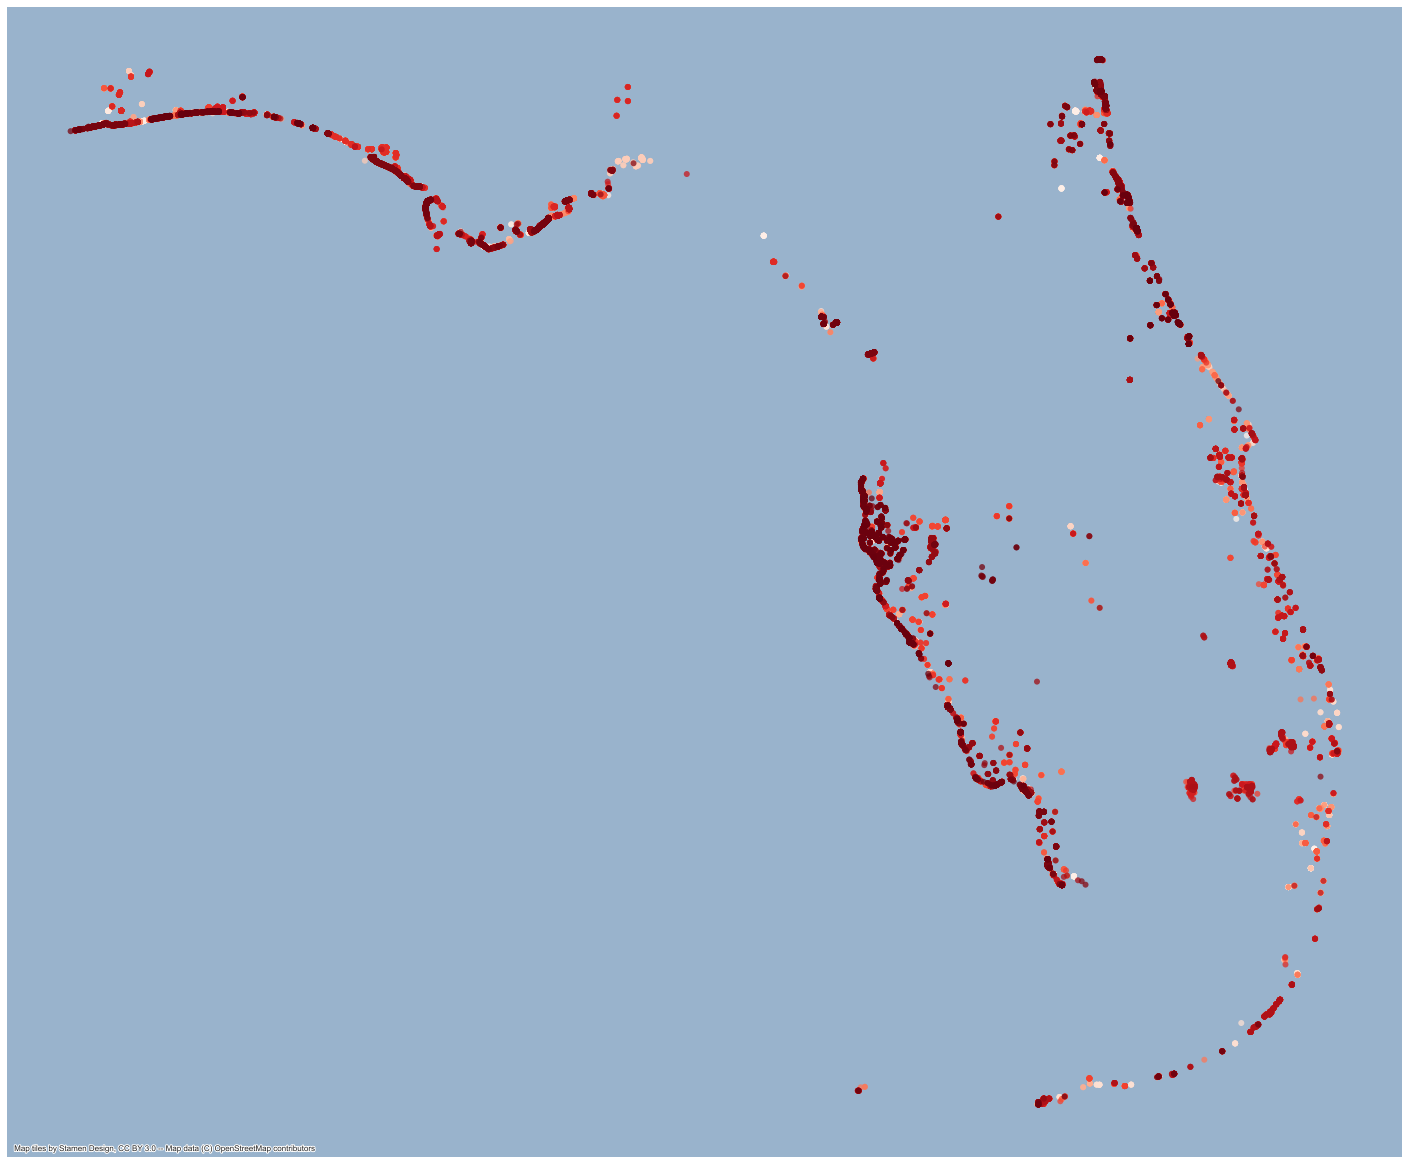

In [118]:
f, ax = plt.subplots(1, figsize=(25, 25))
geoShoreBirds.plot(
    column='OBJECTID', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=geoShoreBirds.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [119]:
geoShoreBirds.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [120]:
hexcentroid.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [121]:
distance = hexcentroid.geometry.apply(lambda x: geoShoreBirds.distance(x).min())

In [122]:
distance.sort_values(ascending=False)

247    1.038584e+07
418    1.037039e+07
38     1.036734e+07
510    1.036433e+07
622    1.036135e+07
           ...     
126    9.416347e+06
546    9.415017e+06
595    9.413719e+06
187    9.412453e+06
493    9.402199e+06
Length: 645, dtype: float64

In [123]:
pythons_hex['distanceToShoreBirds'] = distance 

# Traffic

In [124]:
traffic = gpd.read_file('raw_data/Annual_Average_Daily_Traffic_Historical_TDA.shp')
traffic = traffic.to_crs(epsg=3857)
traffic

OBJECTID  YEAR_ DISTRICT  COSITE   ROADWAY             DESC_FRM  \
0             1   2016        5  797044  79130000                  N/A   
1             2   2016        3  570008  57509500               CR-393   
2             3   2016        6  878604  87053000              W 2 AVE   
3             4   2016        5  798174  79570000                SR 44   
4             5   2016        2  729141  72000080  I-295 END OF BRIDGE   
...         ...    ...      ...     ...       ...                  ...   
98892     98893   2020        6  900623  90060000     CALOOSA COVE ENT   
98893     98894   2020        6  908110  90000022             EATON ST   
98894     98895   2020        5  757089  75515000  OSCEOLA COUNTY LINE   
98895     98896   2020        2  319116  31561000               CR 341   
98896     98897   2020        6  900109  90020000                  N/A   

                  DESC_TO   AADT AADTFLG KFLG  ... MNG_DIST BEGIN_POST  \
0                     N/A   6700       C    F  ...        5      4.209   
1             MILLSIDE RD    250       C    F  ...        3      0.000   
2      SR 5/US-1/BISCAYNE   7400       F    F  ...        6      8.680   
3           US 17 / SR 15   2600       S    F  ...        5      0.000   
4           SAN JOSE BLVD   7700       S    F  ...        2      0.000   
...                   ...    ...     ...  ...  ...      ...        ...   
98892                 N/A  13600       C    F  ...        6      0.000   
98893         SOUTHARD ST   3700       C    F  ...        6      0.000   
98894      75471128 EB ON  77000       C    F  ...        5      0.000   
98895        US-129/SR-49    850       R    F  ...        2      0.000   
98896    Bridge No-900110  14200       C    F  ...        6     23.254   

      END_POST KFCTR K100FCTR DFCTR  TFCTR  Shape_Leng    Shape__Len  \
0        5.211   9.0      0.0  61.4    2.3   1611.2782   1611.278104   
1        1.700   9.5      0.0  52.1    3.7   2761.8307   2761.830729   
2        9.298   9.0      0.0  56.1    4.3    995.7005    995.700423   
3        6.613   9.0      0.0  61.4    5.3  10595.7154  10595.715402   
4        2.760   9.0      0.0  56.2    1.5   4451.2149   4451.214958   
...        ...   ...      ...   ...    ...         ...           ...   
98892    6.652   9.0      0.0  54.1   17.9  10705.1802  10705.180143   
98893    0.172   9.0      0.0  54.1    9.5    274.2249    274.224875   
98894    5.040   9.0      0.0  53.0    2.4   8103.4100   8103.409958   
98895    2.513   9.5      0.0  54.2    5.8   4044.6470   4044.647010   
98896   24.985   9.0      0.0  54.1    8.9   2780.9087   2780.908773   

                                                geometry  
0      LINESTRING (-9001421.940 3373152.631, -9001528...  
1      LINESTRING (-9618706.473 3621697.015, -9619332...  
2      LINESTRING (-8927510.424 2971121.452, -8927350...  
3      LINESTRING (-9055507.758 3379025.770, -9055508...  
4      LINESTRING (-9087556.752 3527263.896, -9087526...  
...                                                  ...  
98892  LINESTRING (-8987719.705 2857432.033, -8987384...  
98893  LINESTRING (-9105264.966 2821782.349, -9105360...  
98894  LINESTRING (-9063584.179 3292909.491, -9063583...  
98895  LINESTRING (-9229311.602 3473591.010, -9227449...  
98896  LINESTRING (-9061360.242 2834499.569, -9061232...  

[98897 rows x 25 columns]

In [125]:
groupedTraffic = traffic.groupby(['COSITE'])['AADT'].agg('mean').reset_index()

In [126]:
groupedTraffic

COSITE     AADT
0      010001  29600.0
1      010002  15040.0
2      010004  25800.0
3      010007  34600.0
4      010008  11760.0
...       ...      ...
18834  979208   1540.0
18835  979209   4510.0
18836  979210   2258.0
18837  979211   2020.0
18838  979913  49164.2

[18839 rows x 2 columns]

In [127]:
averageAADT = traffic.merge(groupedTraffic, on='COSITE', how="outer")

In [128]:
averageAADT

OBJECTID  YEAR_ DISTRICT  COSITE   ROADWAY         DESC_FRM  \
0             1   2016        5  797044  79130000              N/A   
1         20280   2017        5  797044  79130000              N/A   
2         56604   2018        5  797044  79130000              N/A   
3         58970   2019        5  797044  79130000              N/A   
4         82173   2020        5  797044  79130000              N/A   
...         ...    ...      ...     ...       ...              ...   
98892     98611   2020        5  758397  75820600        SEIDEL RD   
98893     98720   2020        5  758398  75500380   AEROSPACE PKWY   
98894     98773   2020        5  758399  75500381   INNOVATION WAY   
98895     98782   2020        5  758396  75820511        SEIDEL RD   
98896     98794   2020        5  758396  75820500  WEST CUL-DE-SAC   

                   DESC_TO  AADT_x AADTFLG KFLG  ... BEGIN_POST END_POST  \
0                      N/A    6700       C    F  ...      4.209    5.211   
1                      N/A    6900       F    F  ...      4.209    5.211   
2                      N/A    7100       S    F  ...      4.238    5.240   
3                      N/A    8200       C    F  ...      4.238    5.240   
4                      N/A    8000       F    F  ...      4.238    5.240   
...                    ...     ...     ...  ...  ...        ...      ...   
98892            SEIDEL RD     600       C    F  ...      0.000    0.284   
98893        MONUMENT PKWY    9800       C    F  ...      0.000    1.330   
98894          END OF ROAD    3300       C    F  ...      0.000    1.630   
98895  LAKE HUCKLEBERRY LN     140       C    F  ...      0.000    0.019   
98896      EAST CUL-DE-SAC     140       C    F  ...      0.000    0.340   

      KFCTR K100FCTR DFCTR TFCTR  Shape_Leng   Shape__Len  \
0       9.0      0.0  61.4   2.3   1611.2782  1611.278104   
1       9.0      0.0  60.9   2.3   1611.2782  1611.278104   
2       9.0      0.0  60.0   2.3   1610.7719  1610.771944   
3       9.0      0.0  59.0   5.2   1610.7719  1610.771944   
4       9.0      0.0  58.7   5.2   1610.7719  1610.771944   
...     ...      ...   ...   ...         ...          ...   
98892   9.0      0.0  53.0   5.5    457.5074   457.507398   
98893   9.5      0.0  53.0   6.4   2152.7556  2152.755618   
98894   9.5      0.0  53.0   6.4   2632.5458  2632.545750   
98895   9.0      0.0  53.0   5.5     29.9958    29.995676   
98896   9.0      0.0  53.0   5.5    547.5631   547.563065   

                                                geometry  AADT_y  
0      LINESTRING (-9001421.940 3373152.631, -9001528...  7380.0  
1      LINESTRING (-9001421.940 3373152.631, -9001528...  7380.0  
2      LINESTRING (-9001452.140 3373197.573, -9001528...  7380.0  
3      LINESTRING (-9001452.140 3373197.573, -9001528...  7380.0  
4      LINESTRING (-9001452.140 3373197.573, -9001528...  7380.0  
...                                                  ...     ...  
98892  LINESTRING (-9084250.242 3304086.487, -9084222...   600.0  
98893  LINESTRING (-9035873.628 3304929.656, -9035854...  9800.0  
98894  LINESTRING (-9035886.693 3304916.154, -9035863...  3300.0  
98895  LINESTRING (-9084794.001 3303455.470, -9084802...   140.0  
98896  LINESTRING (-9084920.533 3303459.293, -9084895...   140.0  

[98897 rows x 26 columns]

In [129]:
averageAADT = averageAADT.drop_duplicates(subset=['COSITE'])

In [130]:
averageAADT

OBJECTID  YEAR_ DISTRICT  COSITE   ROADWAY             DESC_FRM  \
0             1   2016        5  797044  79130000                  N/A   
5             2   2016        3  570008  57509500               CR-393   
15            3   2016        6  878604  87053000              W 2 AVE   
23            4   2016        5  798174  79570000                SR 44   
28            5   2016        2  729141  72000080  I-295 END OF BRIDGE   
...         ...    ...      ...     ...       ...                  ...   
98891     98481   2020        6  876474  87200144             NW 14 ST   
98892     98611   2020        5  758397  75820600            SEIDEL RD   
98893     98720   2020        5  758398  75500380       AEROSPACE PKWY   
98894     98773   2020        5  758399  75500381       INNOVATION WAY   
98895     98782   2020        5  758396  75820511            SEIDEL RD   

                   DESC_TO  AADT_x AADTFLG KFLG  ... BEGIN_POST END_POST  \
0                      N/A    6700       C    F  ...      4.209    5.211   
5              MILLSIDE RD     250       C    F  ...      0.000    1.700   
15      SR 5/US-1/BISCAYNE    7400       F    F  ...      8.680    9.298   
23           US 17 / SR 15    2600       S    F  ...      0.000    6.613   
28           SAN JOSE BLVD    7700       S    F  ...      0.000    2.760   
...                    ...     ...     ...  ...  ...        ...      ...   
98891        RAMP 87200142   16500       C    F  ...      0.000    0.121   
98892            SEIDEL RD     600       C    F  ...      0.000    0.284   
98893        MONUMENT PKWY    9800       C    F  ...      0.000    1.330   
98894          END OF ROAD    3300       C    F  ...      0.000    1.630   
98895  LAKE HUCKLEBERRY LN     140       C    F  ...      0.000    0.019   

      KFCTR K100FCTR DFCTR TFCTR  Shape_Leng    Shape__Len  \
0       9.0      0.0  61.4   2.3   1611.2782   1611.278104   
5       9.5      0.0  52.1   3.7   2761.8307   2761.830729   
15      9.0      0.0  56.1   4.3    995.7005    995.700423   
23      9.0      0.0  61.4   5.3  10595.7154  10595.715402   
28      9.0      0.0  56.2   1.5   4451.2149   4451.214958   
...     ...      ...   ...   ...         ...           ...   
98891   8.0      0.0  99.9  15.0    194.4468    194.446778   
98892   9.0      0.0  53.0   5.5    457.5074    457.507398   
98893   9.5      0.0  53.0   6.4   2152.7556   2152.755618   
98894   9.5      0.0  53.0   6.4   2632.5458   2632.545750   
98895   9.0      0.0  53.0   5.5     29.9958     29.995676   

                                                geometry   AADT_y  
0      LINESTRING (-9001421.940 3373152.631, -9001528...   7380.0  
5      LINESTRING (-9618706.473 3621697.015, -9619332...    300.0  
15     LINESTRING (-8927510.424 2971121.452, -8927350...   7050.0  
23     LINESTRING (-9055507.758 3379025.770, -9055508...   2480.0  
28     LINESTRING (-9087556.752 3527263.896, -9087526...   8200.0  
...                                                  ...      ...  
98891  LINESTRING (-8934639.022 2972606.097, -8934667...  16500.0  
98892  LINESTRING (-9084250.242 3304086.487, -9084222...    600.0  
98893  LINESTRING (-9035873.628 3304929.656, -9035854...   9800.0  
98894  LINESTRING (-9035886.693 3304916.154, -9035863...   3300.0  
98895  LINESTRING (-9084794.001 3303455.470, -9084802...    140.0  

[18839 rows x 26 columns]

In [131]:
averageAADT.sort_values(by='COSITE', ascending=True)

OBJECTID  YEAR_ DISTRICT  COSITE   ROADWAY             DESC_FRM  \
40971      7959   2016        1  010001  01050000    CR-775/PLACIDA RD   
40671      7896   2016        1  010002  01060000      ROTUNDA BLVD  W   
36633      7115   2016        1  010004  01050000    TOLEDO BLADE BLVD   
62427     12244   2016        1  010007  01010000          MURDOCK CIR   
42313      8236   2016        1  010008  01040201  CR 764/WASH LOOP RD   
...         ...    ...      ...     ...       ...                  ...   
54120     10522   2016        5  979208  92472008  CR 522/OSCEOLA PKWY   
58304     11370   2016        5  979209  92472009  SR 417 SB; MP.2.588   
50352      9817   2016        5  979210  92472010  CR 522/OSCEOLA PKWY   
54989     10697   2016        5  979211  92472011  CR 522/OSCEOLA PKWY   
53400     10381   2016        4  979913  94470000                  N/A   

                   DESC_TO  AADT_x AADTFLG KFLG  ... BEGIN_POST END_POST  \
40971          SAN CASA DR   28500       C    F  ...      2.237    3.799   
40671   S MCCALL RD/SR 776   14200       S    F  ...      4.990    9.230   
36633          US-41/SR-45   25000       C    F  ...     16.449   17.549   
62427        VETERANS BLVD   38000       C    F  ...     21.548   21.899   
42313   WASH LOOP RD/CR764   10700       F    F  ...      0.000    1.673   
...                    ...     ...     ...  ...  ...        ...      ...   
54120  SR 417 SB; MP.2.083    1300       C    F  ...      0.000    0.229   
58304  CR 522/OSCEOLA PKWY    3250       C    F  ...      0.000    0.282   
50352  SR 417 NB; MP.2.696    1630       C    F  ...      0.000    0.606   
54989   RAMP 010; MP 0.350    1500       C    F  ...      0.000    0.143   
53400                  N/A   48633       C    A  ...      0.258    5.166   

      KFCTR K100FCTR DFCTR TFCTR  Shape_Leng   Shape__Len  \
40971   9.0      0.0  52.0   3.5   2514.5889  2514.588965   
40671   9.0      0.0  52.8   4.7   6873.3468  6873.346849   
36633   9.0      0.0  52.0   6.7   1770.7852  1770.785195   
62427   9.0      0.0  56.9   3.6    564.0566   564.056691   
42313   9.0      0.0  52.4  13.2   2692.7701  2692.770186   
...     ...      ...   ...   ...         ...          ...   
54120   9.0      0.0  99.9  14.7    373.4572   373.457257   
58304   9.0      0.0  99.9  14.7    455.5943   455.594294   
50352   9.0      0.0  99.9  14.7    989.7038   989.703814   
54989   9.0      0.0  99.9  14.7    232.1043   232.104299   
53400  10.5      0.0  57.7  13.8   7898.1939  7898.193879   

                                                geometry   AADT_y  
40971  LINESTRING (-9165731.928 3115778.348, -9165714...  29600.0  
40671  LINESTRING (-9162610.792 3109458.349, -9162609...  15040.0  
36633  LINESTRING (-9146310.987 3124358.872, -9146074...  25800.0  
62427  LINESTRING (-9143902.307 3124801.020, -9144445...  34600.0  
42313  LINESTRING (-9123824.385 3119854.700, -9123784...  11760.0  
...                                                  ...      ...  
54120  LINESTRING (-9074584.762 3292179.197, -9074581...   1540.0  
58304  LINESTRING (-9074157.367 3292541.012, -9074383...   4510.0  
50352  LINESTRING (-9074339.496 3291999.283, -9074332...   2258.0  
54989  LINESTRING (-9074253.847 3292008.812, -9074265...   2020.0  
53400  LINESTRING (-8942689.109 3149666.811, -8942784...  49164.2  

[18839 rows x 26 columns]

In [132]:
averageAADT.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [133]:
distance = hexcentroid.geometry.apply(lambda x: averageAADT.distance(x).min())

In [134]:
distance

0      1244.231330
1      3701.808616
2      8464.237570
3       170.538573
4       377.257030
          ...     
640     167.630957
641    3048.894593
642    1339.827433
643     582.750356
644    1709.525363
Length: 645, dtype: float64

In [135]:
pythons_hex['distanceToRoad'] = distance

In [136]:
pythons_hex.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [137]:
pythons_hex.sort_values(by='pythonsPerHex', ascending=False)

hex_id                                           geometry  \
361  8544127bfffffff  POLYGON ((-8992507.664 2970226.717, -8985432.5...   
506  8544124ffffffff  POLYGON ((-8980471.229 2956881.151, -8973407.3...   
557  85441247fffffff  POLYGON ((-8997086.009 2951935.157, -8990018.4...   
370  8544124bfffffff  POLYGON ((-8968476.701 2943560.217, -8961424.0...   
194  8544123bfffffff  POLYGON ((-9037991.037 2973644.524, -9030897.7...   
..               ...                                                ...   
233  85441b63fffffff  POLYGON ((-9236669.071 3403189.109, -9229291.4...   
234  8544ad9bfffffff  POLYGON ((-9098197.207 3110020.758, -9091013.7...   
235  8544ad93fffffff  POLYGON ((-9115206.155 3105007.839, -9108019.6...   
236  8544e097fffffff  POLYGON ((-9496002.883 3508299.987, -9488508.1...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
361            512   25.0    70.0      12.0      18.0     37.0  86.0  50.0   
506            338   52.0    32.0      31.0       5.0     24.0  22.0  38.0   
557            306   10.0    52.0      15.0       2.0     15.0  60.0  35.0   
370            287    6.0    90.0       5.0       6.0     22.0  46.0  13.0   
194            287    7.0    72.0      10.0       2.0      8.0  98.0   9.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
233              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
234              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
235              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
236              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Walton  NAME_Washington  distanceToBirdSanctuaries  \
361  ...          0.0              0.0               39187.824272   
506  ...          0.0              0.0               24060.565813   
557  ...          0.0              0.0               36185.449796   
370  ...          0.0              0.0                7137.237771   
194  ...          0.0              0.0               82448.399831   
..   ...          ...              ...                        ...   
233  ...          0.0              0.0               57516.992554   
234  ...          0.0              0.0               26492.746469   
235  ...          0.0              0.0               10673.221515   
236  ...          0.0              0.0               34954.626632   
644  ...          0.0              0.0                 214.656868   

     eagleNestsPerHex  distanceToEagleNests distanceToBirdNests2000  \
361                 0          27898.493260            43019.023682   
506                 0          37356.450101            46612.962459   
557                 0          25679.020476            33895.303194   
370                 0          32175.078777            29845.944544   
194                 1           5809.148628             6250.009525   
..                ...                   ...                     ...   
233                 3           7351.907892             8311.790579   
234                 2            343.384682            27491.077014   
235                 4           6141.438781            11100.549684   
236                 0          12855.583522            25032.896698   
644                 6           1762.690341             2815.448791   

     distanceToMammalHabitats  distance2003BirdHabitats  distanceToShoreBirds  \
361              95075.536676              20829.410747          9.475942e+06   
506              77496.921836              38484.385802          9.460303e+06   
557              82799.172356              37210.884443          9.474550e+06   
370              60205.326795              39431.470230          9.444719e+06   
194             120762.392204              23229.580530          9.520254e+06   
..      

In [138]:
traffic_hex = gpd.sjoin(averageAADT, pythons_hex, op='within', how='left')

In [139]:
traffic_hex

OBJECTID  YEAR_ DISTRICT  COSITE   ROADWAY             DESC_FRM  \
0             1   2016        5  797044  79130000                  N/A   
5             2   2016        3  570008  57509500               CR-393   
15            3   2016        6  878604  87053000              W 2 AVE   
23            4   2016        5  798174  79570000                SR 44   
28            5   2016        2  729141  72000080  I-295 END OF BRIDGE   
...         ...    ...      ...     ...       ...                  ...   
98891     98481   2020        6  876474  87200144             NW 14 ST   
98892     98611   2020        5  758397  75820600            SEIDEL RD   
98893     98720   2020        5  758398  75500380       AEROSPACE PKWY   
98894     98773   2020        5  758399  75500381       INNOVATION WAY   
98895     98782   2020        5  758396  75820511            SEIDEL RD   

                   DESC_TO  AADT_x AADTFLG KFLG  ... NAME_Walton  \
0                      N/A    6700       C    F  ...         0.0   
5              MILLSIDE RD     250       C    F  ...         NaN   
15      SR 5/US-1/BISCAYNE    7400       F    F  ...         0.0   
23           US 17 / SR 15    2600       S    F  ...         NaN   
28           SAN JOSE BLVD    7700       S    F  ...         0.0   
...                    ...     ...     ...  ...  ...         ...   
98891        RAMP 87200142   16500       C    F  ...         0.0   
98892            SEIDEL RD     600       C    F  ...         0.0   
98893        MONUMENT PKWY    9800       C    F  ...         0.0   
98894          END OF ROAD    3300       C    F  ...         0.0   
98895  LAKE HUCKLEBERRY LN     140       C    F  ...         0.0   

      NAME_Washington distanceToBirdSanctuaries eagleNestsPerHex  \
0                 0.0              38992.914731             11.0   
5                 NaN                       NaN              NaN   
15                0.0               3431.457284              0.0   
23                NaN                       NaN              NaN   
28                0.0               9540.958332              3.0   
...               ...                       ...              ...   
98891             0.0              10434.503260              1.0   
98892             0.0              10709.977462              3.0   
98893             0.0              15011.054569              3.0   
98894             0.0              15011.054569              3.0   
98895             0.0              10709.977462              3.0   

      distanceToEagleNests distanceToBirdNests2000  distanceToMammalHabitats  \
0               371.368301              340.064840              50083.328685   
5                      NaN                     NaN                       NaN   
15            19641.823218              594.520183              73830.446111   
23                     NaN                     NaN                       NaN   
28             6308.020155             5806.777227              51069.618040   
...                    ...                     ...                       ...   
98891          2703.120765             6406.819435              65200.338894   
98892          4523.999063            61899.689053              96707.861715   
98893          1720.310124            31980.260694              69749.773865   
98894          1720.310124            31980.260694              69749.773865   
98895          4523.999063            61899.689053              96707.861715   

       distance2003BirdHabitats  distanceToShoreBirds  distanceToRoad  
0                   6535.495051          9.617363e+06      549.618812  
5                           NaN                   NaN             NaN  
15                  2130.063419          9.402199e+06     1760.284897  
23                          NaN                   NaN             NaN  
28                 12021.633465          9.742256e+06       98.199949  
...                         ...                   ...             ...  
98891              

In [140]:
groupedAADT = traffic_hex.groupby(['hex_id'])['AADT_x'].agg('sum').reset_index()

In [141]:
groupedAADT

hex_id   AADT_x
0    8544122ffffffff     3850
1    85441233fffffff     3100
2    8544126ffffffff     4750
3    8544130bfffffff   590675
4    8544130ffffffff  2167239
..               ...      ...
476  8544f6b3fffffff    45950
477  8544f6b7fffffff    12800
478  8544f6bbfffffff     4400
479  8544f6d3fffffff   445371
480  8544f6d7fffffff   660004

[481 rows x 2 columns]

In [142]:
pythons_hex = pythons_hex.merge(groupedAADT, on='hex_id', how="outer")

pythons_hex.fillna(0, inplace=True)


In [143]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  NAME_Washington  distanceToBirdSanctuaries  eagleNestsPerHex  \
0    ...              0.0               24590.999913                 2   
1    ...              0.0               20792.596119                 0   
2    ...              0.0               54501.551173                 0   
3    ...              0.0               11530.446650                 0   
4    ...              0.0               11968.838333                 3   
..   ...              ...                        ...               ...   
640  ...              0.0                7851.180500                 7   
641  ...              0.0               38092.289337                 1   
642  ...              0.0               20772.138403                27   
643  ...              0.0               41317.206195                 1   
644  ...              0.0                 214.656868                 6   

     distanceToEagleNests  distanceToBirdNests2000 distanceToMammalHabitats  \
0             4422.448039            108520.434520            118142.107993   
1            10673.143969             10950.561499             21064.224233   
2            16996.059482             20379.310294             43333.136642   
3            10354.216996             99854.201794            100498.436779   
4             2206.060865             19083.982586             96270.978172   
..                    ...                      ...                      ...   
640           4208.080581              8758.388839             46406.969981   
641           7548.353942             47066.555264             58122.291239   
642           2663.122245             58371.293434             86185.729875   
643           8347.737149              7743.226128             98549.522765   
644           1762.690341              2815.448791             37006.088188   

     distance2003BirdHabitats  distanceToShoreBirds  distanceToRoad     AADT_x  
0               115805.490571          9.867494e+06     1244.231330     6700.0  
1                20085.326833          9.686498e+06     3701.808616    92450.0  
2                27745.102145          9.974212e+06     8464.237570        0.0  
3             

# Snowy Polover Nests 

In [144]:
plover = gpd.read_file('raw_data/Snowy_Plover_Nests.geojson')
plover = plover.to_crs(epsg=3857)
plover

OBJECTID SITENUMBER  TERRITORY NEST  NESTYEAR last_edited_date  \
0           1  CayoCosta          2    A      2002             None   
1           2   SanibelC          3    B      2002             None   
2           3   SanibelC          5    B      2002             None   
3           4   SanibelC         14    B      2002             None   
4           5   SanibelE         24    B      2002             None   
..        ...        ...        ...  ...       ...              ...   
521       522   SanibelC         23    A      2002             None   
522       523   SanibelE         24    A      2002             None   
523       524   SanibelE         25    A      2002             None   
524       525   SanibelE         26    A      2002             None   
525       526   SanibelC         22    A      2002             None   

                             geometry  
0    POINT (-9154356.332 3078292.662)  
1    POINT (-9145404.481 3055897.534)  
2    POINT (-9145007.406 3055586.680)  
3    POINT (-9144892.411 3055526.623)  
4    POINT (-9135283.654 3051877.726)  
..                                ...  
521  POINT (-9144213.365 3055020.943)  
522  POINT (-9135285.546 3051896.370)  
523  POINT (-9132458.030 3053454.413)  
524  POINT (-9131487.658 3054044.953)  
525  POINT (-9144636.377 3055300.700)  

[526 rows x 7 columns]

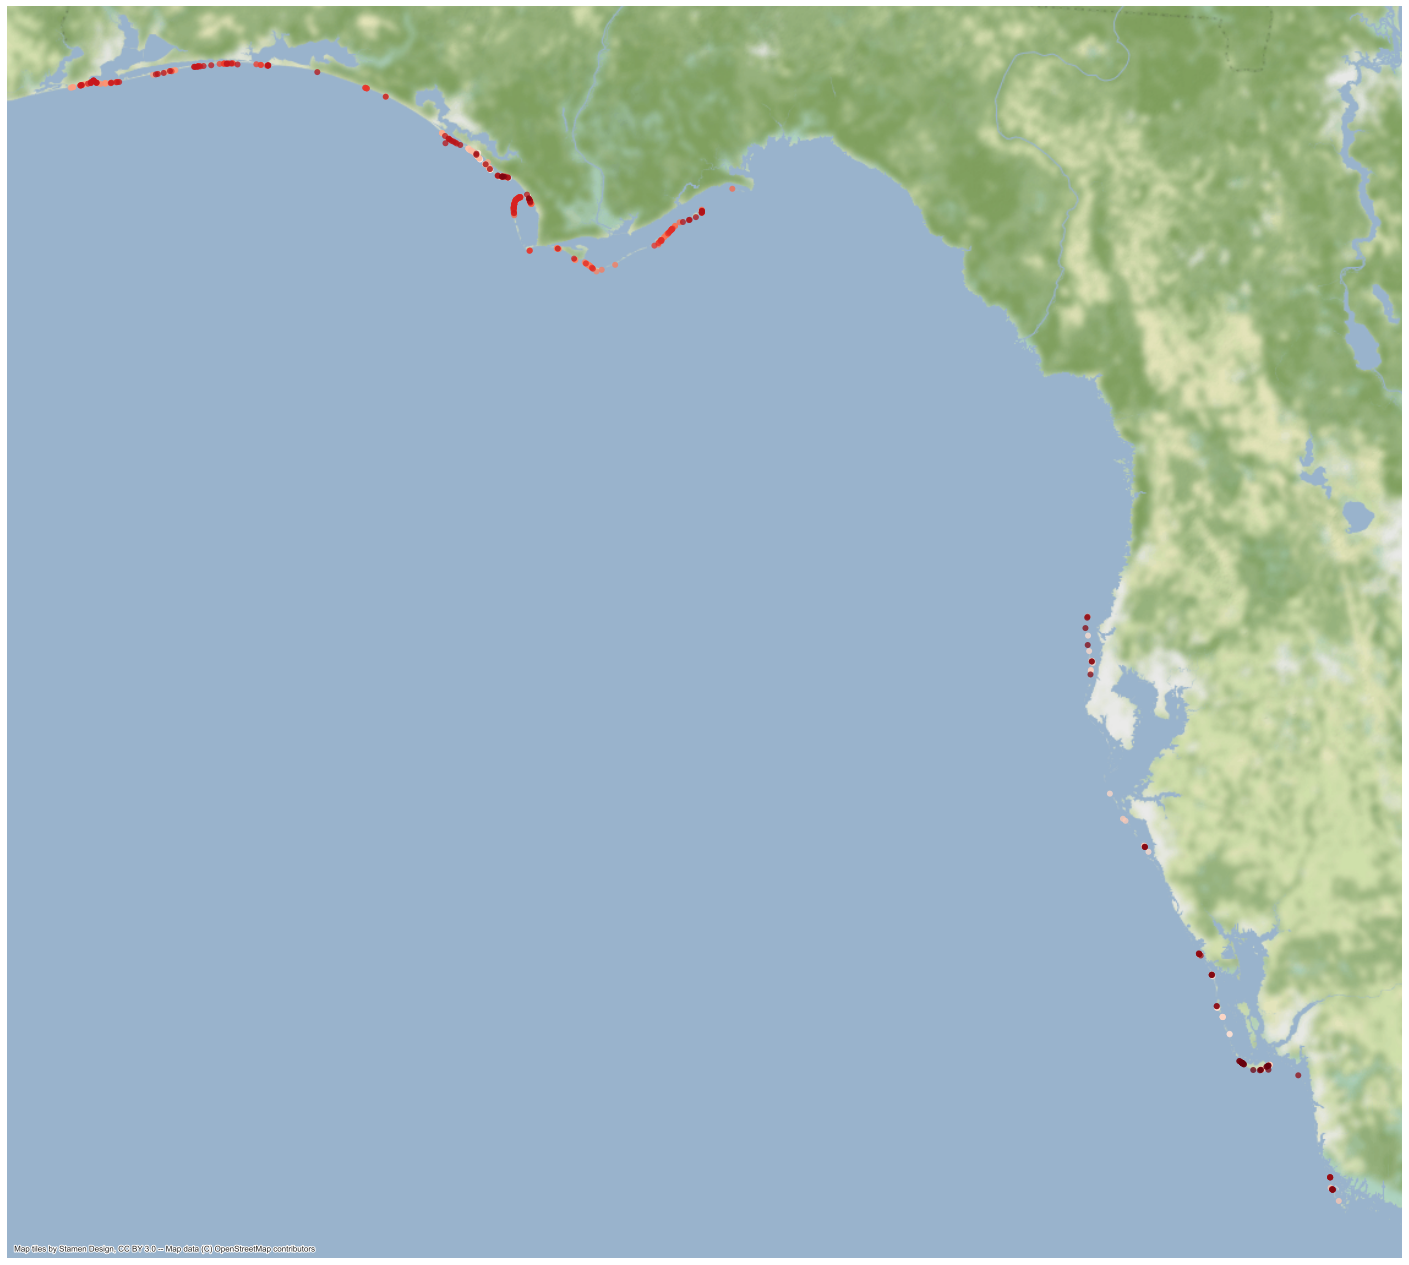

In [145]:
f, ax = plt.subplots(1, figsize=(25, 25))
plover.plot(
    column='OBJECTID', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=plover.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [146]:
distance = hexcentroid.geometry.apply(lambda x: plover.distance(x).min())

In [147]:
pythons_hex['distanceToPloverNests'] = distance

In [148]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToBirdSanctuaries  eagleNestsPerHex  distanceToEagleNests  \
0    ...               24590.999913                 2           4422.448039   
1    ...               20792.596119                 0          10673.143969   
2    ...               54501.551173                 0          16996.059482   
3    ...               11530.446650                 0          10354.216996   
4    ...               11968.838333                 3           2206.060865   
..   ...                        ...               ...                   ...   
640  ...                7851.180500                 7           4208.080581   
641  ...               38092.289337                 1           7548.353942   
642  ...               20772.138403                27           2663.122245   
643  ...               41317.206195                 1           8347.737149   
644  ...                 214.656868                 6           1762.690341   

     distanceToBirdNests2000  distanceToMammalHabitats  \
0              108520.434520             118142.107993   
1               10950.561499              21064.224233   
2               20379.310294              43333.136642   
3               99854.201794             100498.436779   
4               19083.982586              96270.978172   
..                       ...                       ...   
640              8758.388839              46406.969981   
641             47066.555264              58122.291239   
642             58371.293434              86185.729875   
643              7743.226128              98549.522765   
644              2815.448791              37006.088188   

    distance2003BirdHabitats  distanceToShoreBirds  distanceToRoad     AADT_x  \
0              115805.490571          9.867494e+06     1244.231330     6700.0   
1               20085.326833          9.686498e+06     3701.808616    92450.0   
2               27745.102145          9.974212e+06     8464.237570        0.0   
3              104319.869981          9.882297e+06      170.538573   106222.0   
4               25210.039502          9.433277e+06      377.257030  4482817.0   
..                       ...                

In [149]:
plover_hex = gpd.sjoin(plover, pythons_hex, op='within', how='left')

grouped = plover_hex.groupby(['hex_id'])['OBJECTID'].agg('count').reset_index()

grouped = grouped.rename(columns={"OBJECTID": "ploverNestsPerHex"})

pythons_hex = pythons_hex.merge(grouped, on='hex_id', how="outer")

pythons_hex.fillna(0, inplace=True)

pythons_hex['ploverNestsPerHex'] = pythons_hex['ploverNestsPerHex'].astype(int)

pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  eagleNestsPerHex  distanceToEagleNests  distanceToBirdNests2000  \
0    ...                 2           4422.448039            108520.434520   
1    ...                 0          10673.143969             10950.561499   
2    ...                 0          16996.059482             20379.310294   
3    ...                 0          10354.216996             99854.201794   
4    ...                 3           2206.060865             19083.982586   
..   ...               ...                   ...                      ...   
640  ...                 7           4208.080581              8758.388839   
641  ...                 1           7548.353942             47066.555264   
642  ...                27           2663.122245             58371.293434   
643  ...                 1           8347.737149              7743.226128   
644  ...                 6           1762.690341              2815.448791   

     distanceToMammalHabitats  distance2003BirdHabitats distanceToShoreBirds  \
0               118142.107993             115805.490571         9.867494e+06   
1                21064.224233              20085.326833         9.686498e+06   
2                43333.136642              27745.102145         9.974212e+06   
3               100498.436779             104319.869981         9.882297e+06   
4                96270.978172              25210.039502         9.433277e+06   
..                        ...                       ...                  ...   
640              46406.969981              13721.909515         9.739793e+06   
641              58122.291239              41754.982915         1.006966e+07   
642              86185.729875              65549.975584         9.621406e+06   
643              98549.522765              19919.716293         9.764511e+06   
644              37006.088188               4274.479389         9.662762e+06   

     distanceToRoad     AADT_x  distanceToPloverNests  ploverNestsPerHex  
0       1244.231330     6700.0          199899.566556                  0  
1       3701.808616    92450.0          240445.368092                  0  
2       8464.237570        0.0           82465.646418            

# Wading Bird Colonies 

In [150]:
wading = gpd.read_file('raw_data/South_Florida_Wading_Bird_Colonies.geojson')
wading = wading.to_crs(epsg=3857)
wading

FID  REPORTING_YEAR                             ID           Region  \
0      1            2015                    Peanut Pond          Corbett   
1      2            2015                        Trail 7          Corbett   
2      3            2015              Barron Collier 29        Corkscrew   
3      4            2015            Caloosahatchee East        Corkscrew   
4      5            2015                Corkscrew Swamp        Corkscrew   
..   ...             ...                            ...              ...   
573  574            2017                Moonshine Bay 3  Lake Okeechobee   
574  575            2017                  Rabbit Island        Kissimmee   
575  576            2017  Bumble Bee Island (Istokpoga)        Kissimmee   
576  577            2017      Pool E Spoil Island South        Kissimmee   
577  578            2017                Lemkin Creek SW        Kissimmee   

      Latitude  Longitude  ANHI  BAEA  BCNH  BRPE  ...  TRHE  WHIB  WOST  \
0    26.841950 -80.322510     2     0     0     0  ...     0     0     0   
1    26.843470 -80.356480     0     0     0     0  ...     0     0     0   
2    26.273050 -81.343883     0     0     0     0  ...     0     0   141   
3    26.696583 -81.794950     0     0     0     0  ...     0     0     0   
4    26.375033 -81.616417     0     0     0     0  ...     0     0     0   
..         ...        ...   ...   ...   ...   ...  ...   ...   ...   ...   
573  26.928040 -81.034230     0     0     0     0  ...    50   450     0   
574  27.938777 -81.254189     0     0     0     0  ...     0     0     0   
575  27.340000 -81.285000     0     0     0     0  ...     0   818     0   
576  27.259000 -80.998000     0     0     0     0  ...     0     0     0   
577  27.206000 -80.890000     0     0     0     0  ...     0     0     0   

     YCNH  UnidWhite  UnidDark  Total  GWHE  SNHE  \
0       0         59         2    515     0     0   
1       0          5         2     22     0     0   
2       0         66         0    228     0     0   
3       0          4         0     11     0     0   
4       0          0         0      0     0     0   
..    ...        ...       ...    ...   ...   ...   
573     0          0         0   1076     0   100   
574     0          0         0      0     0     0   
575     0          4         0    987     0     0   
576     0          0         0      0     0     0   
577     0          0         0      0     0     0   

                             geometry  
0    POINT (-8941460.913 3103739.329)  
1    POINT (-8945242.436 3103928.968)  
2    POINT (-9055159.635 3032938.847)  
3    POINT (-9105372.183 3085614.679)  
4    POINT (-9085497.981 3045605.022)  
..                                ...  
573  POINT (-9020689.221 3114484.171)  
574  POINT (-9045174.944 3241257.160)  
575  POINT (-9048604.809 3166014.855)  
576  POINT (-9016656.115 3155867.810)  
577  POINT (-9004633.610 3149232.386)  

[578 rows x 34 columns]

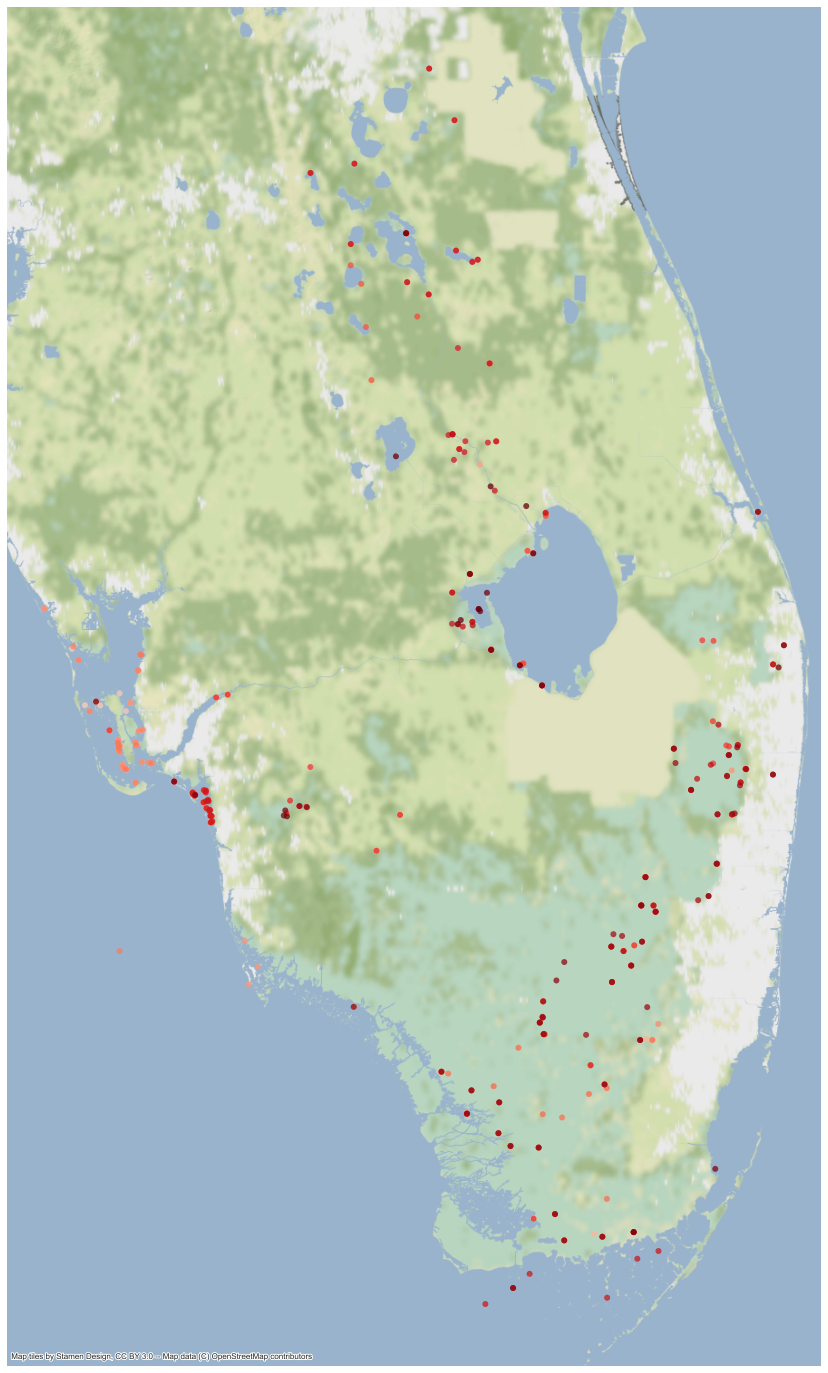

In [151]:
f, ax = plt.subplots(1, figsize=(25, 25))
wading.plot(
    column='FID', 
    cmap='Reds',  
    edgecolor='white', 
    linewidth=0., 
    alpha=0.75,
    ax=ax
)
contextily.add_basemap(
    ax, 
    crs=wading.crs, 
    source=contextily.providers.Stamen.TerrainBackground
)
ax.set_axis_off()

In [152]:
distance = hexcentroid.geometry.apply(lambda x: wading.distance(x).min())

In [153]:
pythons_hex['distanceToWadingBirdColonies'] = distance

In [154]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToEagleNests  distanceToBirdNests2000  \
0    ...           4422.448039            108520.434520   
1    ...          10673.143969             10950.561499   
2    ...          16996.059482             20379.310294   
3    ...          10354.216996             99854.201794   
4    ...           2206.060865             19083.982586   
..   ...                   ...                      ...   
640  ...           4208.080581              8758.388839   
641  ...           7548.353942             47066.555264   
642  ...           2663.122245             58371.293434   
643  ...           8347.737149              7743.226128   
644  ...           1762.690341              2815.448791   

     distanceToMammalHabitats  distance2003BirdHabitats  distanceToShoreBirds  \
0               118142.107993             115805.490571          9.867494e+06   
1                21064.224233              20085.326833          9.686498e+06   
2                43333.136642              27745.102145          9.974212e+06   
3               100498.436779             104319.869981          9.882297e+06   
4                96270.978172              25210.039502          9.433277e+06   
..                        ...                       ...                   ...   
640              46406.969981              13721.909515          9.739793e+06   
641              58122.291239              41754.982915          1.006966e+07   
642              86185.729875              65549.975584          9.621406e+06   
643              98549.522765              19919.716293          9.764511e+06   
644              37006.088188               4274.479389          9.662762e+06   

    distanceToRoad     AADT_x  distanceToPloverNests  ploverNestsPerHex  \
0      1244.231330     6700.0          199899.566556                  0   
1      3701.808616    92450.0          240445.368092                  0   
2      8464.237570        0.0           82465.646418                  0   
3       170.538573   106222.0          181506.244963                  0   
4       377.257030  4482817.0          151504.746084                  0   
..             ...        ...               

# Urban Boundaries  

In [155]:
urban = gpd.read_file('raw_data/Urban_Boundaries.shp')
urban = urban.to_crs(epsg=3857)
urban

OBJECTID   Shape_Leng  Population  HPMS_NUM  \
0          1  1405.872597     5502379      1370   
1          2    21.411603       32095      1070   
2          3    11.140999        7540       164   
3          4    10.912486        8965      1298   
4          5    23.611930       18121      1063   
..       ...          ...         ...       ...   
72        73    31.105403       10962      9903   
73        74    20.538399        5817      9907   
74        75   179.150803      143280      1675   
75        76   474.043992      340067      1715   
76        77   240.853421      191917       670   

                                NAME     Shape_Le_1    Shape__Are  \
0                              Miami  698777.735716  3.641208e+09   
1                           Key West  140084.349163  5.545602e+07   
2                       Big Pine Key   81526.614950  2.885517e+07   
3                           Marathon   90176.961662  2.826332e+07   
4                          Key Largo  171293.140527  6.115486e+07   
..                               ...            ...           ...   
72                     Jupiter Farms   69226.884182  8.056295e+07   
73             Panama City NorthEast   40507.283486  5.319442e+07   
74                       Panama City  171824.538200  4.640003e+08   
75                         Pensacola  286290.705079  1.227773e+09   
76  Fort Walton Beach-Navarre-Wright  223755.706166  6.238100e+08   

       Shape__Len                                           geometry  
0   698777.735716  MULTIPOLYGON (((-8956511.947 2942650.112, -895...  
1   140084.349163  POLYGON ((-9105806.504 2824192.580, -9105793.6...  
2    81526.614950  POLYGON ((-9056803.148 2838398.561, -9056751.2...  
3    90176.973088  POLYGON ((-9028924.063 2837477.725, -9028977.8...  
4   171293.140527  POLYGON ((-8948729.746 2898495.180, -8948684.3...  
..            ...                                                ...  
72   69226.884182  POLYGON ((-8932668.843 3118097.282, -8932120.1...  
73   40507.283486  POLYGON ((-9518593.014 3534501.312, -9518591.5...  
74  171824.538200  POLYGON ((-9556241.852 3533114.888, -9556241.8...  
75  286290.705079  POLYGON ((-9693501.450 3594312.910, -9691587.1...  
76  223755.706166  POLYGON ((-9693281.450 3554918.327, -9693274.7...  

[77 rows x 9 columns]

In [156]:
distance = hexcentroid.geometry.apply(lambda x: urban.distance(x).min())

In [157]:
pythons_hex['distanceToUrbanBoundary'] = distance

In [158]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToBirdNests2000  distanceToMammalHabitats  \
0    ...            108520.434520             118142.107993   
1    ...             10950.561499              21064.224233   
2    ...             20379.310294              43333.136642   
3    ...             99854.201794             100498.436779   
4    ...             19083.982586              96270.978172   
..   ...                      ...                       ...   
640  ...              8758.388839              46406.969981   
641  ...             47066.555264              58122.291239   
642  ...             58371.293434              86185.729875   
643  ...              7743.226128              98549.522765   
644  ...              2815.448791              37006.088188   

     distance2003BirdHabitats  distanceToShoreBirds  distanceToRoad  \
0               115805.490571          9.867494e+06     1244.231330   
1                20085.326833          9.686498e+06     3701.808616   
2                27745.102145          9.974212e+06     8464.237570   
3               104319.869981          9.882297e+06      170.538573   
4                25210.039502          9.433277e+06      377.257030   
..                        ...                   ...             ...   
640              13721.909515          9.739793e+06      167.630957   
641              41754.982915          1.006966e+07     3048.894593   
642              65549.975584          9.621406e+06     1339.827433   
643              19919.716293          9.764511e+06      582.750356   
644               4274.479389          9.662762e+06     1709.525363   

        AADT_x  distanceToPloverNests  ploverNestsPerHex  \
0       6700.0          199899.566556                  0   
1      92450.0          240445.368092                  0   
2          0.0           82465.646418                  0   
3     106222.0          181506.244963                  0   
4    4482817.0          151504.746084                  0   
..         ...                    ...                ...   
640  5521304.0           39172.264291                  0   
641        0.0           55963.715249                  0   
642   422000.0          17

In [159]:
urbanCentroid = urban.centroid

In [160]:
urbanCentroid = urbanCentroid.reset_index(drop=True)

In [161]:
distance = hexcentroid.geometry.apply(lambda x: urbanCentroid.distance(x).min())

In [162]:
distance

0      22810.153240
1      38128.541709
2      28316.807497
3      12867.785549
4      30174.173658
           ...     
640     4970.008645
641    38629.422714
642    15886.979851
643     3087.064003
644    39753.274786
Length: 645, dtype: float64

In [163]:
pythons_hex['distanceToUrbanCenter'] = distance

In [164]:
pythons_hex

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToMammalHabitats  distance2003BirdHabitats  \
0    ...             118142.107993             115805.490571   
1    ...              21064.224233              20085.326833   
2    ...              43333.136642              27745.102145   
3    ...             100498.436779             104319.869981   
4    ...              96270.978172              25210.039502   
..   ...                       ...                       ...   
640  ...              46406.969981              13721.909515   
641  ...              58122.291239              41754.982915   
642  ...              86185.729875              65549.975584   
643  ...              98549.522765              19919.716293   
644  ...              37006.088188               4274.479389   

     distanceToShoreBirds  distanceToRoad     AADT_x distanceToPloverNests  \
0            9.867494e+06     1244.231330     6700.0         199899.566556   
1            9.686498e+06     3701.808616    92450.0         240445.368092   
2            9.974212e+06     8464.237570        0.0          82465.646418   
3            9.882297e+06      170.538573   106222.0         181506.244963   
4            9.433277e+06      377.257030  4482817.0         151504.746084   
..                    ...             ...        ...                   ...   
640          9.739793e+06      167.630957  5521304.0          39172.264291   
641          1.006966e+07     3048.894593        0.0          55963.715249   
642          9.621406e+06     1339.827433   422000.0         173400.491444   
643          9.764511e+06      582.750356   202150.0         327746.064175   
644          9.662762e+06     1709.525363     4900.0           3336.015917   

     ploverNestsPerHex  distanceToWadingBirdColonies  distanceToUrbanBoundary  \
0                    0                 303663.941864             15428.814174   
1                    0                 152405.867937              4264.882971   
2                    0                 369052.713326             19578.403119   
3                    0                 310050.460132              9505.775034   
4                    0                  20831.252067             

In [165]:
WIP2 = pythons_hex

In [166]:
WIP2 

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToMammalHabitats  distance2003BirdHabitats  \
0    ...             118142.107993             115805.490571   
1    ...              21064.224233              20085.326833   
2    ...              43333.136642              27745.102145   
3    ...             100498.436779             104319.869981   
4    ...              96270.978172              25210.039502   
..   ...                       ...                       ...   
640  ...              46406.969981              13721.909515   
641  ...              58122.291239              41754.982915   
642  ...              86185.729875              65549.975584   
643  ...              98549.522765              19919.716293   
644  ...              37006.088188               4274.479389   

     distanceToShoreBirds  distanceToRoad     AADT_x distanceToPloverNests  \
0            9.867494e+06     1244.231330     6700.0         199899.566556   
1            9.686498e+06     3701.808616    92450.0         240445.368092   
2            9.974212e+06     8464.237570        0.0          82465.646418   
3            9.882297e+06      170.538573   106222.0         181506.244963   
4            9.433277e+06      377.257030  4482817.0         151504.746084   
..                    ...             ...        ...                   ...   
640          9.739793e+06      167.630957  5521304.0          39172.264291   
641          1.006966e+07     3048.894593        0.0          55963.715249   
642          9.621406e+06     1339.827433   422000.0         173400.491444   
643          9.764511e+06      582.750356   202150.0         327746.064175   
644          9.662762e+06     1709.525363     4900.0           3336.015917   

     ploverNestsPerHex  distanceToWadingBirdColonies  distanceToUrbanBoundary  \
0                    0                 303663.941864             15428.814174   
1                    0                 152405.867937              4264.882971   
2                    0                 369052.713326             19578.403119   
3                    0                 310050.460132              9505.775034   
4                    0                  20831.252067             

# Lakes 

In [167]:
lakes = gpd.read_file('raw_data/Florida_Lakes.geojson')
lakes = lakes.to_crs(epsg=3857)
lakes

OBJECTID     PERIMETER            NAME     COUNTY     SHAPEAREA  \
0            1  11082.251506   Lake Maitland     ORANGE  1.818000e+06   
1            2   2834.074075      Black Lake   ESCAMBIA  3.137978e+04   
2            3  18768.273070    Lake Jackson  HIGHLANDS  1.360118e+07   
3            4    493.278959   Halfmoon Lake   ESCAMBIA  6.337482e+03   
4            5   5662.687648   Crescent Lake   ESCAMBIA  3.382422e+05   
...        ...           ...             ...        ...           ...   
4238      4239   1278.886808      Smith Lake       CLAY  1.445732e+04   
4239      4240    327.551059      Smith Lake       CLAY  5.250288e+03   
4240      4241    495.775911      Smith Lake       CLAY  1.166739e+04   
4241      4242   1919.732769  Tigerhead Lake     MARION  1.123865e+05   
4242      4243   1771.596606      Twin Lakes     PUTNAM  1.843445e+05   

          SHAPELEN                                           geometry  
0     11082.250892  POLYGON ((-9055633.251 3327818.262, -9055640.1...  
1      2834.074076  POLYGON ((-9731582.400 3566804.381, -9731624.1...  
2     18768.273762  POLYGON ((-9068242.289 3181653.643, -9068233.8...  
3       493.278856  POLYGON ((-9719650.114 3599073.688, -9719648.8...  
4      5662.688705  POLYGON ((-9715510.940 3564005.775, -9715454.4...  
...            ...                                                ...  
4238   1278.886364  POLYGON ((-9122921.833 3476593.064, -9122874.0...  
4239    327.551438  POLYGON ((-9122203.777 3478201.340, -9122167.2...  
4240    495.775838  POLYGON ((-9121988.241 3478410.252, -9121963.6...  
4241   1919.733059  POLYGON ((-9114256.015 3371622.719, -9114245.1...  
4242   1771.596553  POLYGON ((-9111442.823 3455213.425, -9111460.4...  

[4243 rows x 7 columns]

In [168]:
lakesCentroid = lakes.centroid

In [169]:
lakesCentroid = lakesCentroid.reset_index(drop=True)

In [170]:
distance = hexcentroid.geometry.apply(lambda x: lakes.distance(x).min())

In [171]:
distance 

0       1348.061880
1       3284.474317
2      16025.938128
3        102.605429
4       8312.658607
           ...     
640     1483.133664
641     6483.228229
642     3903.376418
643    24616.510617
644    13921.320296
Length: 645, dtype: float64

In [172]:
WIP2['distanceToLakeArea'] = distance

In [173]:
distance = hexcentroid.geometry.apply(lambda x: lakesCentroid.distance(x).min())

In [174]:
WIP2['distanceToLakeCenter'] = distance

In [175]:
WIP2

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToShoreBirds  distanceToRoad     AADT_x  \
0    ...          9.867494e+06     1244.231330     6700.0   
1    ...          9.686498e+06     3701.808616    92450.0   
2    ...          9.974212e+06     8464.237570        0.0   
3    ...          9.882297e+06      170.538573   106222.0   
4    ...          9.433277e+06      377.257030  4482817.0   
..   ...                   ...             ...        ...   
640  ...          9.739793e+06      167.630957  5521304.0   
641  ...          1.006966e+07     3048.894593        0.0   
642  ...          9.621406e+06     1339.827433   422000.0   
643  ...          9.764511e+06      582.750356   202150.0   
644  ...          9.662762e+06     1709.525363     4900.0   

     distanceToPloverNests  ploverNestsPerHex distanceToWadingBirdColonies  \
0            199899.566556                  0                303663.941864   
1            240445.368092                  0                152405.867937   
2             82465.646418                  0                369052.713326   
3            181506.244963                  0                310050.460132   
4            151504.746084                  0                 20831.252067   
..                     ...                ...                          ...   
640           39172.264291                  0                102911.017737   
641           55963.715249                  0                447130.014420   
642          173400.491444                  0                 18635.397949   
643          327746.064175                  0                288546.769468   
644            3336.015917                  9                  5754.106547   

     distanceToUrbanBoundary  distanceToUrbanCenter  distanceToLakeArea  \
0               15428.814174           22810.153240         1348.061880   
1                4264.882971           38128.541709         3284.474317   
2               19578.403119           28316.807497        16025.938128   
3                9505.775034           12867.785549          102.605429   
4                   0.000000           30174.173658         8312.658607   
..                       ...                    ...     

# Springs 

In [176]:
springs = gpd.read_file('raw_data/Florida_Springs_(2016).geojson')
springs = springs.to_crs(epsg=3857)
springs

OBJECTID BEST_LOCATION  SPRING_KEY       RESOURCE_  \
0            1   CONDITIONAL          96  SPRING_GENERAL   
1            2   CONDITIONAL         102  SPRING_GENERAL   
2            3   CONDITIONAL         103  SPRING_GENERAL   
3            4   CONDITIONAL         104  SPRING_GENERAL   
4            5   CONDITIONAL         107  SPRING_GENERAL   
...        ...           ...         ...             ...   
1087      1088           YES        2288  SPRING_GENERAL   
1088      1089           YES        2293     SPRING_BOIL   
1089      1090           YES        2307     SPRING_VENT   
1090      1091           YES        2312     SPRING_VENT   
1091      1092           YES        3400  SPRING_GENERAL   

     SURFACE_WATER_MEASURE                              SPRING_NAME  \
0                      YES                           BELCHER SPRING   
1                      YES                    BELTONS HEAD SPRING 1   
2                      YES                    BELTONS HEAD SPRING 2   
3                      YES          BELTONS MILLPOND HEAD SPRING 2A   
4                      YES           BELTONS MILLPOND HEAD SPRING 4   
...                    ...                                      ...   
1087                   YES                 WALKER SPRING (SUWANNEE)   
1088                   YES                      WARM MINERAL SPRING   
1089                   YES  WASHINGTON BLUE SPRING (CHOCTAWHATCHEE)   
1090                   YES     WASHINGTON BLUE SPRING (ECONFINA) #1   
1091                   YES     WASHINGTON BLUE SPRING (ECONFINA) #2   

                                    STATION_NAME  \
0                                 BELCHER SPRING   
1                 BELTONS MILLPOND HEAD SPRING 1   
2                 BELTONS MILLPOND HEAD SPRING 2   
3                BELTONS MILLPOND HEAD SPRING 2A   
4     BELTONS MILLPOND HEAD SPRING 4 (BLUE HOLE)   
...                                          ...   
1087                               WALKER SPRING   
1088                         WARM MINERAL SPRING   
1089     WASHINGTON BLUE SPRING (CHOCTAWHATCHEE)   
1090          WASHINGTON BLUE SPRINGS (ECONFINA)   
1091                     ECONFINA BLUE SPRING #2   

                         STATION_ALIAS       STATION_ID          DATA_SOURCE  \
0                                       284801082351701      SWFWMD - DEWITT   
1                                       284526082034401      SWFWMD - DEWITT   
2                                       284527082034301      SWFWMD - DEWITT   
3                                       284528082034801      SWFWMD - DEWITT   
4                                       284530082034701      SWFWMD - DEWITT   
...                                ...              ...                  ...   
1087                                    300759083075000                 USGS   
1088  WARM SALT; SALT; BIG SALT SPRING      DEP FGS-443              DEP FGS   
1089          BLUE SPRINGS (WA-HOLMES)      DEP FGS-444              DEP FGS   
1090         BLUE SPRING (WA-ECONFINA)      DEP FGS-445              DEP FGS   
1091                                                     DEP FGS BULLETIN 66   

      ... FGS_MAGNITUDE       SPRING_CLUSTER         DMS_LAT         DMS_LON  \
0     ...             2      HOMOSASSA GROUP    28 47 48.287    82 35 10.628   
1     ...             2  PANASOFFKEE CLUSTER    28 45 26.559    82 03 44.596   
2     ...             2  PANASOFFKEE CLUSTER    28 45 27.491    82 03 43.572   
3     ...             2  PANASOFFKEE CLUSTER    28 45 28.393    82 03 48.282   
4     ...             2  PANASOFFKEE CLUSTER    28 45 30.366    82 03 47.498   
...   ...           ...                  ...             ...             ...   
1087  ...       Unknown                             30 07 59        83 07 50   
1088  ...             3     SARASOTA CLUSTER    27 03 35.645   82 15 35.8339   
1089  ...             2                       30 30 47.73215  85 50 49.86766   
1090  ...             2                       

In [177]:
distance = hexcentroid.geometry.apply(lambda x: springs.distance(x).min())

In [178]:
WIP2['distanceToSprings'] = distance

# Rivers 

In [179]:
rivers = gpd.read_file('raw_data/Major_Rivers_(lines).geojson')
rivers = rivers.to_crs(epsg=3857)
rivers

FID  OBJECTID       LENGTH                  NAME   TYPE    SHAPE_Leng  \
0        1         1  44418.34680   Choctawatchee River  RIVER  44418.346927   
1        2         2   5168.94812         Perdido River  RIVER   5168.948202   
2        3         3  12839.67342      Blackwater River  RIVER  12839.675452   
3        4         4  46268.17725   Choctawatchee River  RIVER  46268.176399   
4        5         5   1859.92887         Perdido River  RIVER   1859.928820   
...    ...       ...          ...                   ...    ...           ...   
1019  1020      1020   1316.07794  Caloosahatchee River  RIVER   1316.077808   
1020  1021      1021    672.72582  Caloosahatchee River  RIVER    672.726163   
1021  1022      1022   1123.71259  Caloosahatchee River  RIVER   1123.712748   
1022  1023      1023    759.19807  Caloosahatchee River  RIVER    759.197875   
1023  1024      1024   5530.95226  Caloosahatchee River  RIVER   5530.951927   

      Shape__Length                                           geometry  
0      51843.708207  LINESTRING (-9554619.677 3632031.218, -9554651...  
1       6020.310186  LINESTRING (-9741371.521 3597451.329, -9741367...  
2      14974.890881  LINESTRING (-9661615.558 3597006.429, -9661594...  
3      54004.489116  LINESTRING (-9554297.447 3598934.560, -9554365...  
4       2166.900006  LINESTRING (-9737758.929 3595069.768, -9737726...  
...             ...                                                ...  
1019    1475.848316  LINESTRING (-9104222.599 3086107.986, -9103717...  
1020     754.614443  LINESTRING (-9104637.686 3085960.565, -9104644...  
1021    1259.842702  LINESTRING (-9105903.837 3085789.643, -9105581...  
1022     851.111340  LINESTRING (-9106821.243 3085664.003, -9106514...  
1023    6201.935077  LINESTRING (-9106425.660 3085437.527, -9106391...  

[1024 rows x 8 columns]

In [180]:
distance = hexcentroid.geometry.apply(lambda x: rivers.distance(x).min())

In [181]:
WIP2['distanceToRivers'] = distance

In [182]:
WIP2

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...     AADT_x  distanceToPloverNests  ploverNestsPerHex  \
0    ...     6700.0          199899.566556                  0   
1    ...    92450.0          240445.368092                  0   
2    ...        0.0           82465.646418                  0   
3    ...   106222.0          181506.244963                  0   
4    ...  4482817.0          151504.746084                  0   
..   ...        ...                    ...                ...   
640  ...  5521304.0           39172.264291                  0   
641  ...        0.0           55963.715249                  0   
642  ...   422000.0          173400.491444                  0   
643  ...   202150.0          327746.064175                  0   
644  ...     4900.0            3336.015917                  9   

     distanceToWadingBirdColonies  distanceToUrbanBoundary  \
0                   303663.941864             15428.814174   
1                   152405.867937              4264.882971   
2                   369052.713326             19578.403119   
3                   310050.460132              9505.775034   
4                    20831.252067                 0.000000   
..                            ...                      ...   
640                 102911.017737                 0.000000   
641                 447130.014420             34496.831468   
642                  18635.397949                 0.000000   
643                 288546.769468                 0.000000   
644                   5754.106547              1137.269792   

    distanceToUrbanCenter  distanceToLakeArea  distanceToLakeCenter  \
0            22810.153240         1348.061880           2043.356496   
1            38128.541709         3284.474317           3387.496200   
2            28316.807497        16025.938128          16221.837532   
3            12867.785549          102.605429            291.509570   
4            30174.173658         8312.658607           8736.418572   
..                    ...                 ...                   ...   
640           4970.008645         1483.133664           1681.262402   
641          38629.422714         6483.228229           6590.918541   
642        

# Flowing Water Resources

In [183]:
waterFlow = gpd.read_file('raw_data/WMS_Flowing_Waters_Resource.geojson')
waterFlow = waterFlow.to_crs(epsg=3857)
waterFlow

OBJECTID      GNIS_NAME  LENGTH_KM RESOURCE_             STREAMCODE  \
0             1           None   1.495815    Stream       1-03110103000047   
1             2           None   0.435522    Stream       2-03110103000225   
2             3           None   0.203906    Stream       3-03110103000225   
3             4           None   1.355171    Stream       4-03110103000231   
4             5           None   3.658605    Stream       5-03110103000232   
...         ...            ...        ...       ...                    ...   
23989     23990           None   0.973811    Stream  113901-03080101017081   
23990     23991    Beale Creek   0.326385    Stream  113908-03140305000753   
23991     23992           None   3.446806    Stream  113915-03110103000142   
23992     23993  Aucilla River   0.269855     River  113411-03110103000137   
23993     23994  Aucilla River   0.812635     River  113413-03110103000137   

      REPORTING_UNITS     SHAPELEN  \
0              Zone 1  1495.815429   
1              Zone 1   435.521710   
2              Zone 1   203.905647   
3              Zone 1  1355.171145   
4              Zone 1  3658.604814   
...               ...          ...   
23989          Zone 3   973.810736   
23990          Zone 1   326.385198   
23991          Zone 2  3446.805705   
23992          Zone 2   269.854506   
23993          Zone 2   812.634820   

                                                geometry  
0      LINESTRING (-9329824.226 3586639.805, -9329805...  
1      LINESTRING (-9327741.949 3574295.779, -9327748...  
2      LINESTRING (-9327669.455 3574675.457, -9327671...  
3      LINESTRING (-9328693.205 3578422.011, -9328693...  
4      LINESTRING (-9328329.009 3581782.904, -9328328...  
...                                                  ...  
23989  LINESTRING (-9063835.190 3329560.030, -9063905...  
23990  LINESTRING (-9706352.143 3586836.405, -9706359...  
23991  LINESTRING (-9313772.528 3547917.891, -9313794...  
23992  LINESTRING (-9347572.571 3522490.780, -9347580...  
23993  LINESTRING (-9346759.619 3522907.750, -9346769...  

[23994 rows x 8 columns]

In [184]:
distance = hexcentroid.geometry.apply(lambda x: waterFlow.distance(x).min())

In [185]:
WIP2['distanceToFlowingWater'] = distance

In [186]:
WIP2

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToPloverNests  ploverNestsPerHex  \
0    ...          199899.566556                  0   
1    ...          240445.368092                  0   
2    ...           82465.646418                  0   
3    ...          181506.244963                  0   
4    ...          151504.746084                  0   
..   ...                    ...                ...   
640  ...           39172.264291                  0   
641  ...           55963.715249                  0   
642  ...          173400.491444                  0   
643  ...          327746.064175                  0   
644  ...            3336.015917                  9   

     distanceToWadingBirdColonies  distanceToUrbanBoundary  \
0                   303663.941864             15428.814174   
1                   152405.867937              4264.882971   
2                   369052.713326             19578.403119   
3                   310050.460132              9505.775034   
4                    20831.252067                 0.000000   
..                            ...                      ...   
640                 102911.017737                 0.000000   
641                 447130.014420             34496.831468   
642                  18635.397949                 0.000000   
643                 288546.769468                 0.000000   
644                   5754.106547              1137.269792   

     distanceToUrbanCenter distanceToLakeArea  distanceToLakeCenter  \
0             22810.153240        1348.061880           2043.356496   
1             38128.541709        3284.474317           3387.496200   
2             28316.807497       16025.938128          16221.837532   
3             12867.785549         102.605429            291.509570   
4             30174.173658        8312.658607           8736.418572   
..                     ...                ...                   ...   
640            4970.008645        1483.133664           1681.262402   
641           38629.422714        6483.228229           6590.918541   
642           15886.979851        3903.376418           5160.055075   
643            3087.064003       24616.510617          24920.802459   
6

# Wading Bird Rookeries

In [187]:
rookeries = gpd.read_file('raw_data/Wading_Bird_Rookeries__-_1999.geojson')
rookeries = rookeries.to_crs(epsg=3857)
rookeries

OBJECTID ATLASNUM                      DATE_ OBSMODE   COUNTY TOWNSHIP  \
0         1140   611124  1999-05-05T04:00:00+00:00  Aerial   Sumter      19S   
1         1141   611126  1999-05-05T04:00:00+00:00  Aerial   Citrus      20S   
2         1142   611127  1999-03-16T04:00:00+00:00  Aerial   Citrus      20S   
3         1143   611128  1999-04-28T04:00:00+00:00  Aerial   Citrus      20S   
4         1144   611129  1999-03-16T04:00:00+00:00  Aerial   Sumter      20S   
...        ...      ...                        ...     ...      ...      ...   
1134      2274   616117  1999-05-06T04:00:00+00:00  Aerial     Polk      29S   
1135      2275   616119  1999-03-25T04:00:00+00:00  Aerial  Brevard      29S   
1136      2276   616122  1999-05-05T04:00:00+00:00  Ground  Osceola      29S   
1137      2277   616132  1999-04-29T04:00:00+00:00  Aerial     Polk      31S   
1138      2278   616139  1999-04-29T04:00:00+00:00  Aerial   Hardee      33S   

     RANGE SECTION  GAZPAGE  ERA  ... WOST SMWT LGWT SMDK LGDK    LONGDEC  \
0      23E      21       78   80  ...    0    0    0    0    0 -82.016667   
1      20E      01       77   80  ...    0    0    0    0    0 -82.266667   
2      20E      12       77   80  ...    0    0    0    0    0 -82.266667   
3      20E      13       77   80  ...    0    0    0    0    0 -82.266667   
4      22E      22       78   80  ...    0    0    0    0    0 -82.100000   
...    ...     ...      ...  ...  ...  ...  ...  ...  ...  ...        ...   
1134   25E      09       93   80  ...   20    0    0    0    0 -81.813833   
1135   38E      16       96   80  ...    0    0    0    0    0 -80.533333   
1136   31E      31       94   80  ...    0    0    0    0    0 -81.255000   
1137   24E      20       92   80  ...    0    0    0    0    0 -81.925000   
1138   23E      03       92   80  ...    0    1    0    0    0 -81.997167   

         LATDEC           last_edited_date  \
0     28.816667  2019-06-25T21:52:55+00:00   
1     28.783333  2019-06-25T21:52:55+00:00   
2     28.758333  2019-06-25T21:52:55+00:00   
3     28.750000  2019-06-25T21:52:55+00:00   
4     28.733333  2019-06-25T21:52:55+00:00   
...         ...                        ...   
1134  27.969833  2019-06-25T21:52:55+00:00   
1135  27.966667  2019-06-25T21:52:55+00:00   
1136  27.915000  2019-06-25T21:52:55+00:00   
1137  27.770000  2019-06-25T21:52:55+00:00   
1138  27.635333  2019-06-25T21:52:55+00:00   

                                                Present  \
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
...                                                 ...   
1134     Anhinga, Great Egret, Cattle Egret, Wood Stork   
1135  Brown Pelican, Double Crested Cormorant, Great...   
1136  Anhinga, Snowy Egret, Little Blue Heron, Trico...   
1137  Double Crested Cormorant, Great Egret, Black C...   
1138  Anhinga, Great Blue Heron, Great Egret, Little...   

                              geometry  
0     POINT (-9130053.965 3352333.167)  
1     POINT (-9157883.849 3348098.652)  
2     POINT (-9157883.840 3344923.727)  
3     POINT (-9157883.847 3343865.638)  
4     POINT (-9139330.552 3341749.565)  
...                                ...  
1134  POINT (-9107474.575 3245171.604)  
1135  POINT (-8964929.924 3244772.569)  
1136  POINT (-9045265.550 3238262.104)  
1137  POINT (-9119849.628 3220007.524)  
1138  POINT (-9127883.230 3203075.574)  

[1139 rows x 48 columns]

In [188]:
distance = hexcentroid.geometry.apply(lambda x: rookeries.distance(x).min())

In [189]:
WIP2['distanceTo1999WadingBirdRookeries'] = distance

# Stormwater Activity Sites

In [190]:
stormWater = gpd.read_file('raw_data/NPDES_Stormwater_Facilities_and_Activities.geojson')
stormWater = stormWater.to_crs(epsg=3857)
stormWater

LOCATIONAL_ID FACILITY_ID                        FACILITY_NAME  \
0               2397   FLR04E034                      Destin, City Of   
1               1172   FLR05A775           Metalplate Galvanizing Inc   
2              84414   FLR20AL48  Mandarin Water Reclamation Facility   
3               1282   FLR05F520        Affordable Auto & Truck Parts   
4             111965   FLR20DR28          John Prince Park Campground   
...              ...         ...                                  ...   
22602         122593   FLR10UZ29                     Chautauqua Solar   
22603         123092   FLR20FG86      Monarch Acres at Lakewood Ranch   
22604         123083   FLR20FG83              Hyundai Saint Augustine   
22605         123074   FLR20FG77  Cross Bridge Church of the Nazarene   
22606         123240   FLR10VB37           Aurora St. Leon Apartments   

                      ISSUE_DATE            EXPIRATION_DATE FACILITY_STATUS  \
0      2018-09-12T00:00:00+00:00  2023-09-11T00:00:00+00:00               A   
1      2020-10-11T00:00:00+00:00  2025-10-10T00:00:00+00:00               A   
2      2015-12-12T00:00:00+00:00  2020-12-11T00:00:00+00:00               A   
3      2019-02-08T00:00:00+00:00  2024-02-07T00:00:00+00:00               A   
4      2020-06-12T00:00:00+00:00  2025-06-11T00:00:00+00:00               A   
...                          ...                        ...             ...   
22602  2022-02-21T00:00:00+00:00  2027-02-20T00:00:00+00:00               A   
22603  2022-03-26T00:00:00+00:00  2027-03-25T00:00:00+00:00               A   
22604  2022-03-24T00:00:00+00:00  2027-03-23T00:00:00+00:00               A   
22605  2022-03-07T00:00:00+00:00  2027-03-06T00:00:00+00:00               A   
22606  2022-03-31T00:00:00+00:00  2027-03-30T00:00:00+00:00               A   

      FACILITY_TYPE_CODE                                PERMIT_TYPE  COUNTY  \
0                    MS2                              MS2, > 10-50K      46   
1                    MSP    Stormwater - Multisector Generic Permit      16   
2                    CGD      Construction Generic Dewatering Small      16   
3                    MSP    Stormwater - Multisector Generic Permit      53   
4                    CGD      Construction Generic Dewatering Large      50   
...                  ...                                        ...     ...   
22602                CGP  Stormwater - Large Construction (>= 5 AC)      66   
22603                CGD      Construction Generic Dewatering Large      41   
22604                CGD      Construction Generic Dewatering Small      55   
22605                CGD      Construction Generic Dewatering Small       5   
22606                CGP  Stormwater - Large Construction (>= 5 AC)      42   

      COUNTY_NAME  ... DCD_DATUM_ID         DETERMINATION_DATE  \
0        Okaloosa  ...        NAD83  2018-01-26T00:00:00+00:00   
1           Duval  ...        NAD83  2020-11-09T00:00:00+00:00   
2           Duval  ...        WGS84  2016-12-05T13:15:56+00:00   
3            Polk  ...        NAD83  2019-01-18T00:00:00+00:00   
4      Palm Beach  ...        WGS84  2020-06-09T15:27:42+00:00   
...           ...  ...          ...                        ...   
22602      Walton  ...        WGS84  2022-02-18T17:55:33+00:00   
22603     Manatee  ...        NAD83  2022-03-21T00:00:00+00:00   
22604   St. Johns  ...        WGS84  2022-03-21T13:40:28+00:00   
22605     Brevard  ...        NAD83  2022-03-21T00:00:00+00:00   
22606      Marion  ...        WGS84  2022-03-28T17:00:50+00:00   

           COLLECTOR_USERNAME          VERIFICATION_DATE  \
0                  ROBINSON_C                       None   
1                 JEANLOUIS_K  2020-11-09T00:00:00+00:00   
2      INOI_AUTOMATIC_PROCESS                       None   
3                     BARAL_K  2019-01-18T00:00:00+00:00   
4      INOI_AUTOMATIC_PROCESS                       None   
...                       ...                        ...   
22602  INOI_AUTOMAT

In [191]:
distance = hexcentroid.geometry.apply(lambda x: stormWater.distance(x).min())

In [192]:
WIP2['distanceToStormwaterActivitySites'] = distance

# Waterbodies 

In [193]:
waterbodies = gpd.read_file('raw_data/AHED_Waterbodies.geojson')
waterbodies = waterbodies.to_crs(epsg=3857)
waterbodies

OBJECTID             EXPERT  SOURCEID   HYDROID          NAME  \
0              1               None     142.0       NaN  GATOR SLOUGH   
1              2  Maryam Mashayekhi      23.0  103710.0          None   
2              3  Maryam Mashayekhi      23.0  103711.0          None   
3              4  Maryam Mashayekhi      23.0  103712.0          None   
4              5  Maryam Mashayekhi      23.0  103713.0          None   
...          ...                ...       ...       ...           ...   
123669    123670               None       NaN  837905.0          None   
123670    123671               None       NaN  837906.0          None   
123671    123672               None       NaN  837907.0          None   
123672    123673               None       NaN  837908.0          None   
123673    123674               None       NaN  837909.0          None   

        AREAACRES  WATERBODYTYPE  JUNCTIONID NHD_GNIS_NAME  NHD_FCODE  \
0        2.022228              1         NaN          None        NaN   
1       22.882541              2     55562.0                  43613.0   
2        8.888585              2         0.0                  43613.0   
3        6.147786              2         0.0                  43613.0   
4        2.094284              2         0.0                  43613.0   
...           ...            ...         ...           ...        ...   
123669   0.134449              2         NaN          None        NaN   
123670   1.715012              2         NaN          None        NaN   
123671   3.381274              2         NaN          None        NaN   
123672  12.699066              2         NaN          None        NaN   
123673  10.017734              3         NaN          None        NaN   

        NHD_SOURCE_FC HYDRO_ORDER ALIAS SEG_NAME  QCSTATUS FUNC_LOC   WOD  \
0                 NaN        None  None     None         0     None  None   
1                 2.0        None  None     None         0     None  None   
2                 2.0        None  None     None         0     None  None   
3                 2.0        None  None     None         0     None  None   
4                 2.0        None  None     None         0     None  None   
...               ...         ...   ...      ...       ...      ...   ...   
123669            NaN        None  None     None         0     None  None   
123670            NaN        None  None     None         0     None  None   
123671            NaN        None  None     None         0     None  None   
123672            NaN        None  None     None         0     None  None   
123673            NaN        None  None     None         0     None  None   

        SHAPE_Length    SHAPE_Area  \
0           0.012666  7.425008e-07   
1           0.012704  8.441653e-06   
2           0.007158  3.278605e-06   
3           0.007454  2.267611e-06   
4           0.003515  7.723597e-07   
...              ...           ...   
123669      0.001013  4.948802e-08   
123670      0.003349  6.312581e-07   
123671      0.006139  1.244606e-06   
123672      0.013685  4.674297e-06   
123673      0.008321  3.687265e-06   

                                                 geometry  
0       MULTIPOLYGON (((-9118157.754 3091780.385, -911...  
1       MULTIPOLYGON (((-9020949.904 3158151.268, -902...  
2       MULTIPOLYGON (((-9019466.124 3155970.078, -901...  
3       MULTIPOLYGON (((-9019514.170 3155810.890, -901...  
4       MULTIPOLYGON (((-9049148.140 3153931.098, -904...  
...                                                   ...  
123669  MULTIPOLYGON (((-8925248.644 3128358.893, -892...  
123670  MULTIPOLYGON (((-8925189.046 3128297.930, -892...  
123671  MULTIPOLYGON (((-8924446.475 3128696.901, -892...  
123672  MULTIPOLYGON (((-8924995.190 3128857.744, -892...  
123673  MULTIPOLYGON (((-8924360.803 3128300.074, -892...  

[123674 rows x 20 columns]

In [194]:
waterbodyCentroids = waterbodies.centroid

waterbodyCentroids = waterbodyCentroids.reset_index(drop=True)

In [195]:
distance = hexcentroid.geometry.apply(lambda x: waterbodyCentroids.distance(x).min())

In [196]:
WIP2['distanceToWaterBodies'] = distance

# Submerged Lands 

In [197]:
submergedLand = gpd.read_file('raw_data/ERP_Applications_-_Submerged_Lands.geojson')
submergedLand = submergedLand.to_crs(epsg=3857)
submergedLand

OBJECTID       APP_NO      OLD_AREA    PERMIT_NO  \
0          1     061005-3  4.014124e+05   36-05693-P   
1          2     000831-2  3.229440e+03   22-00311-P   
2          3    050111-18  4.221834e+03   11-00672-L   
3          4     040812-1  1.031234e+04   50-05848-L   
4          5    030225-18  2.027188e+06   50-05398-L   
5          6    060601-20  1.585375e+05   50-07213-P   
6          7    080806-18  4.379209e+04   11-02878-P   
7          8    040607-12  3.024753e+04   36-02988-L   
8          9    030922-14  2.441856e+05   50-05903-L   
9         10    050830-30  1.000000e+04   43-02009-L   
10        11     041117-7  4.564249e+04   13-02435-L   
11        12    030520-25  6.510155e+04   43-01405-L   
12        13     100628-5           NaN   56-03088-P   
13        14     070619-2  9.548678e+06         None   
14        15    080312-17  5.973935e+04   11-01536-S   
15        16    120119-11           NaN   44-00309-L   
16        17    110112-19           NaN   28-00634-L   
17        18    050222-32  3.154132e+04         None   
18        19     020918-5  1.645347e+07   47-00588-L   
19        20    060818-24  6.409422e+03   06-04642-L   
20        21    131022-23           NaN   06-03760-L   
21        22    130107-17           NaN   44-00310-L   
22        23    131118-16           NaN   50-05849-L   
23        24    140408-12           NaN   43-01407-L   
24        25    140627-21           NaN   50-05850-L   
25        26    141202-22           NaN   50-05774-P   
26        27    041001-12           NaN   13-02013-L   
27        28    150107-13           NaN   50-09026-P   
28        29     150413-3           NaN   47-01167-L   
29        30     010403-7           NaN   22-00336-L   
30        31     000601-8           NaN   22-00311-L   
31        32    020313-23           NaN   11-01899-P   
32        33     010406-8           NaN   56-01687-L   
33        34     000817-3           NaN   50-04651-P   
34        35    160520-16           NaN   13-03491-P   
35        36    161117-18           NaN   13-02015-L   
36        37    160602-13           NaN   13-02014-L   
37        38    170322-14           NaN   06-03761-L   
38        39  190510-1410           NaN  44-101690-P   
39        40  190718-1627           NaN  13-103090-P   
40        41    140804-13           NaN  06-104467-P   
41        42  200318-3043           NaN         None   

                                         PROJECT_NAME   APP_STATUS ACTIVE_MOD  \
0                             OASIS AT FORT MYERS THE     COMPLETE       None   
1                                   CHAPMAN BOAT RAMP     COMPLETE       None   
2                       KEY MARCO CDD IRRIGATION LINE     COMPLETE          Y   
3           LOXAHATCHEE RIVER ROAD BRIDGE REPLACEMENT     COMPLETE          Y   
4   TURNPIKE BRIDGE DECK REPLACEMENT AT LOXAHATCHE...     COMPLETE          Y   
5                       JACKSONVILLE LANDCO SSL LEASE     COMPLETE       None   
6    CR 901 BRIDGE REPLACEMENT OVER COCOHATCHEE CANAL     COMPLETE          Y   
7   SR 45/US 41 NORTH OF BONITA BEACH RD TO OLD US 41     COMPLETE          Y   
8                             THE MOORINGS AT LANTANA     COMPLETE          Y   
9      MAPP ROAD BRIDGE REPLACEMENT AT DANFORTH CREEK     COMPLETE          Y   
10  NW 17TH AVENUE BRIDGE OVER MIAMI RIVER PHASE 1...     COMPLETE          Y   
11     ST LUCIE INLET STATE PARK WATER MAIN EXTENSION     COMPLETE          Y   
12  JUANITA AVENUE BRIDGE REPLACEMENT OVER TAYLOR ...     COMPLETE          Y   
13                    HORIZON (SMITH RANCH AND GROVE)    WITHDRAWN       None   
14                VANDERBILT DRIVE PEDESTRIAN BRIDGES     COMPLETE       None   
15  NORTH ROOSEVELT BOULEVARD ROADWAY IMPROVEMENT ...     COMPLETE          Y   
16  S R 700 (U S 98) KISSIMMEE RIVER BRIDGE REHABI...     COMPLETE          Y   
17         SR 5 (BRICKELL AVENUE) BRIDGE IMPROVEMENTS     COMPLETE       None   
18                LAKE OKEECHOBEE SCENIC TRAIL (LOST)   

In [198]:
distance = hexcentroid.geometry.apply(lambda x: submergedLand.distance(x).min())

In [199]:
WIP2['distanceToSubmergedLand'] = distance

In [200]:
WIP2

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToUrbanCenter  distanceToLakeArea  distanceToLakeCenter  \
0    ...           22810.153240         1348.061880           2043.356496   
1    ...           38128.541709         3284.474317           3387.496200   
2    ...           28316.807497        16025.938128          16221.837532   
3    ...           12867.785549          102.605429            291.509570   
4    ...           30174.173658         8312.658607           8736.418572   
..   ...                    ...                 ...                   ...   
640  ...            4970.008645         1483.133664           1681.262402   
641  ...           38629.422714         6483.228229           6590.918541   
642  ...           15886.979851         3903.376418           5160.055075   
643  ...            3087.064003        24616.510617          24920.802459   
644  ...           39753.274786        13921.320296          14235.530514   

     distanceToSprings  distanceToRivers distanceToFlowingWater  \
0          3733.101329       2221.342133             715.261659   
1         27915.260605      31179.419923            6364.902143   
2          9692.913956       4979.974117            4932.213645   
3          5433.950500       4994.767200             363.836381   
4        188511.972569       8890.619617            1642.741552   
..                 ...               ...                    ...   
640        2702.256322       2808.612335            1535.276885   
641       31128.582605       3631.978306             718.464015   
642        8825.955000      19219.099030            5303.355399   
643       37902.585437       2486.668597             748.296959   
644       43493.152258      29617.212753           17872.677931   

     distanceTo1999WadingBirdRookeries  distanceToStormwaterActivitySites  \
0                          3762.446376                        4957.991899   
1                         14063.033356                        4221.809761   
2                         14342.982645                       16052.170558   
3                          5143.819862                        3091.697710   
4                         10621.939093                       

# Census Data 

In [201]:
import cenpy

In [202]:
available = cenpy.explorer.available()

available.head()

c_isTimeseries temporal spatial c_isAggregate           publisher  \
ABSCB2017             NaN      NaN     NaN          True  U.S. Census Bureau   
ABSCB2018             NaN      NaN     NaN          True  U.S. Census Bureau   
ABSCB2019             NaN      NaN     NaN          True  U.S. Census Bureau   
ABSCBO2017            NaN      NaN     NaN          True  U.S. Census Bureau   
ABSCBO2018            NaN      NaN     NaN          True  U.S. Census Bureau   

                                    references programCode  \
ABSCB2017   https://www.census.gov/developers/     006:007   
ABSCB2018   https://www.census.gov/developers/     006:007   
ABSCB2019   https://www.census.gov/developers/     006:007   
ABSCBO2017  https://www.census.gov/developers/     006:007   
ABSCBO2018  https://www.census.gov/developers/     006:007   

                         modified  \
ABSCB2017   2020-04-30 00:00:00.0   
ABSCB2018   2020-10-26 00:00:00.0   
ABSCB2019   2021-08-17 00:00:00.0   
ABSCBO2017  2020-04-30 00:00:00.0   
ABSCBO2018  2020-10-26 00:00:00.0   

                                                      license    keyword  ...  \
ABSCB2017   https://creativecommons.org/publicdomain/zero/...  (census,)  ...   
ABSCB2018   https://creativecommons.org/publicdomain/zero/...  (census,)  ...   
ABSCB2019   https://creativecommons.org/publicdomain/zero/...  (census,)  ...   
ABSCBO2017  https://creativecommons.org/publicdomain/zero/...  (census,)  ...   
ABSCBO2018  https://creativecommons.org/publicdomain/zero/...  (census,)  ...   

                                                  description bureauCode  \
ABSCB2017   The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2018   The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2019   The Annual Business Survey (ABS) provides info...     006:07   
ABSCBO2017  The Annual Business Survey (ABS) provides info...     006:07   
ABSCBO2018  The Annual Business Survey (ABS) provides info...     006:07   

           accessLevel                                              title  \
ABSCB2017       public  Economic Surveys: Annual Business Survey: Annu...   
ABSCB2018       public  Economic Surveys: Annual Business Survey: Annu...   
ABSCB2019       public  Economic Surveys: Annual Business Survey: Annu...   
ABSCBO2017      public  Economic Surveys: Annual Business Survey: Annu...   
ABSCBO2018      public  Economic Surveys: Annual Business Survey: Annu...   

           c_isAvailable c_isCube c_isMicrodata  \
ABSCB2017           True      NaN           NaN   
ABSCB2018           True      NaN           NaN   
ABSCB2019           True      NaN           NaN   
ABSCBO2017          True      NaN           NaN   
ABSCBO2018          True      NaN           NaN   

                          c_documentationLink  c_dataset vintage  
ABSCB2017   https://www.census.gov/developer/   (abscb,)  2017.0  
ABSCB2018   https://www.census.gov/developer/   (abscb,)  2018.0  
ABSCB2019   https://www.census.gov/developer/   (abscb,)  2019.0  
ABSCBO2017  https://www.census.gov/developer/  (abscbo,)  2017.0  
ABSCBO2018  https://www.census.gov/developer/  (abscbo,)  2018.0  

[5 rows x 23 columns]

In [203]:
# Return a dataframe of all datasets that start with "ACS"
# Axis=0 means to filter the index labels!
acs = available.filter(regex="^ACS", axis=0)

acs

c_isTimeseries   temporal        spatial c_isAggregate  \
ACSCD1132011            NaN  2011/2011  United States          True   
ACSCD1152015            NaN  2015/2015  United States          True   
ACSCP1Y2010             NaN        NaN  United States          True   
ACSCP1Y2011             NaN        NaN  United States          True   
ACSCP1Y2012             NaN        NaN            NaN          True   
...                     ...        ...            ...           ...   
ACSST5Y2016             NaN        NaN            NaN          True   
ACSST5Y2017             NaN        NaN            NaN          True   
ACSST5Y2018             NaN        NaN            NaN          True   
ACSST5Y2019             NaN        NaN            NaN          True   
ACSST5Y2020             NaN        NaN            NaN          True   

                       publisher                          references  \
ACSCD1132011  U.S. Census Bureau   http://www.census.gov/developers/   
ACSCD1152015  U.S. Census Bureau   http://www.census.gov/developers/   
ACSCP1Y2010   U.S. Census Bureau  https://www.census.gov/developers/   
ACSCP1Y2011   U.S. Census Bureau  https://www.census.gov/developers/   
ACSCP1Y2012   U.S. Census Bureau  https://www.census.gov/developers/   
...                          ...                                 ...   
ACSST5Y2016   U.S. Census Bureau  https://www.census.gov/developers/   
ACSST5Y2017   U.S. Census Bureau  https://www.census.gov/developers/   
ACSST5Y2018   U.S. Census Bureau  https://www.census.gov/developers/   
ACSST5Y2019   U.S. Census Bureau  https://www.census.gov/developers/   
ACSST5Y2020   U.S. Census Bureau  https://www.census.gov/developers/   

             programCode               modified  \
ACSCD1132011     006:004             2014-10-06   
ACSCD1152015     006:004             2017-02-10   
ACSCP1Y2010      006:004  2018-09-18 00:00:00.0   
ACSCP1Y2011      006:004  2018-09-18 00:00:00.0   
ACSCP1Y2012      006:004  2018-07-05 00:00:00.0   
...                  ...                    ...   
ACSST5Y2016      006:004  2018-06-29 00:00:00.0   
ACSST5Y2017      006:004  2018-10-19 00:00:00.0   
ACSST5Y2018      006:004  2019-10-22 15:36:29.0   
ACSST5Y2019      006:004  2020-04-03 00:00:00.0   
ACSST5Y2020      006:004  2021-07-13 00:00:00.0   

                                                        license    keyword  \
ACSCD1132011  http://creativecommons.org/publicdomain/zero/1.0/  (census,)   
ACSCD1152015  http://creativecommons.org/publicdomain/zero/1.0/  (census,)   
ACSCP1Y2010   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSCP1Y2011   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSCP1Y2012   https://creativecommons.org/publicdomain/zero/...  (census,)   
...                                                         ...        ...   
ACSST5Y2016   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSST5Y2017   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSST5Y2018   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSST5Y2019   https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSST5Y2020   https://creativecommons.org/publicdomain/zero/...  (census,)   

              ...                                        description  \
ACSCD1132011  ...  The American Community Survey (ACS) is a natio...   
ACSCD1152015  ...  The American Community Survey (ACS) is an ongo...   
ACSCP1Y2010   ...  The American Community Survey (ACS) is an ongo...   
ACSCP1Y2011   ...  The American Community Survey (ACS) is an ongo...   
ACSCP1Y2012   ...  The American Community Survey (ACS) is an ongo...   
...           ...                                                ...   
ACSST5Y2016   ...  The American Community Survey (ACS) is an ongo...   
ACSST5Y2017   ...  The American Community Survey (ACS) is an ongo...   
ACSST5Y2018   ...  The American Community Survey (ACS) is an ongo...   
ACSST5Y2019   ...  The Am

In [204]:
# Return a dataframe of all datasets that start with "ACSDT5Y"
available.filter(regex="^ACSDT5Y", axis=0)

c_isTimeseries temporal        spatial c_isAggregate  \
ACSDT5Y2009                NaN      NaN            NaN          True   
ACSDT5Y2010                NaN      NaN  United States          True   
ACSDT5Y2011                NaN      NaN            NaN          True   
ACSDT5Y2012                NaN      NaN            NaN          True   
ACSDT5Y2013                NaN      NaN            NaN          True   
ACSDT5Y2014                NaN      NaN            NaN          True   
ACSDT5Y2015                NaN      NaN            NaN          True   
ACSDT5Y2016                NaN      NaN            NaN          True   
ACSDT5Y2017                NaN      NaN            NaN          True   
ACSDT5Y2018                NaN      NaN            NaN          True   
ACSDT5Y2019                NaN      NaN            NaN          True   
ACSDT5Y2020                NaN      NaN            NaN          True   
ACSDT5YAIAN2010            NaN      NaN            NaN          True   
ACSDT5YAIAN2015            NaN      NaN            NaN          True   
ACSDT5YSPT2010             NaN      NaN            NaN          True   
ACSDT5YSPT2015             NaN      NaN            NaN          True   

                          publisher                          references  \
ACSDT5Y2009      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2010      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2011      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2012      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2013      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2014      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2015      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2016      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2017      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2018      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2019      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5Y2020      U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5YAIAN2010  U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5YAIAN2015  U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5YSPT2010   U.S. Census Bureau  https://www.census.gov/developers/   
ACSDT5YSPT2015   U.S. Census Bureau  https://www.census.gov/developers/   

                programCode               modified  \
ACSDT5Y2009         006:004  2019-08-27 13:11:18.0   
ACSDT5Y2010         006:004  2018-07-04 00:00:00.0   
ACSDT5Y2011         006:004  2018-07-04 00:00:00.0   
ACSDT5Y2012         006:004  2018-07-04 00:00:00.0   
ACSDT5Y2013         006:004  2018-07-04 00:00:00.0   
ACSDT5Y2014         006:004  2018-07-04 00:00:00.0   
ACSDT5Y2015         006:004  2018-07-05 00:00:00.0   
ACSDT5Y2016         006:004  2018-07-05 00:00:00.0   
ACSDT5Y2017         006:004  2018-08-21 07:11:43.0   
ACSDT5Y2018         006:004  2019-10-22 16:28:02.0   
ACSDT5Y2019         006:004  2020-04-03 00:00:00.0   
ACSDT5Y2020         006:004  2021-07-13 00:00:00.0   
ACSDT5YAIAN2010     006:004  2019-10-24 07:18:57.0   
ACSDT5YAIAN2015     006:004  2020-02-13 00:00:00.0   
ACSDT5YSPT2010      006:004  2019-10-11 14:16:00.0   
ACSDT5YSPT2015      006:004  2020-02-18 00:00:00.0   

                                                           license    keyword  \
ACSDT5Y2009      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2010      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2011      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2012      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2013      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2014      https://creativecommons.org/publicdomain/zero/...  (census,)   
ACSDT5Y2015      https://crea

### grab 2016 information

In [205]:
cenpy.explorer.explain("ACSDT5Y2016")

{'ACS 5-Year Detailed Tables': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (116th Congress), all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [206]:
acs = cenpy.remote.APIConnection("ACSDT5Y2016")

In [207]:
len(acs.variables)

22858

In [208]:
acs.variables.head(n=10)

label  \
for                                 Census API FIPS 'for' clause   
in                                   Census API FIPS 'in' clause   
ucgid                 Uniform Census Geography Identifier clause   
B99104_007E    Estimate!!Total!!Not living with own grandchil...   
B24022_060E    Estimate!!Total!!Female!!Service occupations!!...   
B11011_007E     Estimate!!Total!!Family households!!Other family   
B19001B_014E               Estimate!!Total!!$100,000 to $124,999   
B24032_049E    Estimate!!Female!!Educational services, and he...   
B11011_006E    Estimate!!Total!!Family households!!Married-co...   
B07007PR_019E  Estimate!!Total!!Moved from different municipi...   

                                                         concept  \
for                           Census API Geography Specification   
in                            Census API Geography Specification   
ucgid                         Census API Geography Specification   
B99104_007E    ALLOCATION OF LENGTH OF TIME GRANDPARENT RESPO...   
B24022_060E    SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...   
B11011_007E                 HOUSEHOLD TYPE BY UNITS IN STRUCTURE   
B19001B_014E   HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 201...   
B24032_049E    SEX BY INDUSTRY AND MEDIAN EARNINGS IN THE PAS...   
B11011_006E                 HOUSEHOLD TYPE BY UNITS IN STRUCTURE   
B07007PR_019E  GEOGRAPHICAL MOBILITY IN THE PAST YEAR BY CITI...   

              predicateType     group limit predicateOnly  \
for                fips-for       N/A     0          True   
in                  fips-in       N/A     0          True   
ucgid                 ucgid       N/A     0          True   
B99104_007E             int    B99104     0           NaN   
B24022_060E             int    B24022     0           NaN   
B11011_007E             int    B11011     0           NaN   
B19001B_014E            int   B19001B     0           NaN   
B24032_049E             int    B24032     0           NaN   
B11011_006E             int    B11011     0           NaN   
B07007PR_019E           int  B07007PR     0           NaN   

              hasGeoCollectionSupport  \
for                               NaN   
in                                NaN   
ucgid                            True   
B99104_007E                       NaN   
B24022_060E                       NaN   
B11011_007E                       NaN   
B19001B_014E                      NaN   
B24032_049E                       NaN   
B11011_006E                       NaN   
B07007PR_019E                     NaN   

                                                attributes required values  
for                                                    NaN      NaN    NaN  
in                                                     NaN      NaN    NaN  
ucgid                                                  NaN      NaN    NaN  
B99104_007E                                   B99104_007EA      NaN    NaN  
B24022_060E          B24022_060EA,B24022_060M,B24022_060MA      NaN    NaN  
B11011_007E          B11011_007EA,B11011_007M,B11011_007MA      NaN    NaN  
B19001B_014E      B19001B_014EA,B19001B_014M,B19001B_014MA      NaN    NaN  
B24032_049E          B24032_049EA,B24032_049M,B24032_049MA      NaN    NaN  
B11011_006E          B11011_006EA,B11011_006M,B11011_006MA      NaN    NaN  
B07007PR_019E  B07007PR_019EA,B07007PR_019M,B07007PR_019MA      NaN    NaN

In [209]:
acs.varslike("MEDIAN INCOME", by='concept').sort_index()

label  \
B06011PR_001E  Estimate!!Median income in the past 12 months!...   
B06011PR_002E  Estimate!!Median income in the past 12 months!...   
B06011PR_003E  Estimate!!Median income in the past 12 months!...   
B06011PR_004E  Estimate!!Median income in the past 12 months!...   
B06011PR_005E  Estimate!!Median income in the past 12 months!...   
B06011_001E    Estimate!!Median income in the past 12 months!...   
B06011_002E    Estimate!!Median income in the past 12 months!...   
B06011_003E    Estimate!!Median income in the past 12 months!...   
B06011_004E    Estimate!!Median income in the past 12 months!...   
B06011_005E    Estimate!!Median income in the past 12 months!...   
B07011PR_001E  Estimate!!Median income in the past 12 months!...   
B07011PR_002E  Estimate!!Median income in the past 12 months!...   
B07011PR_003E  Estimate!!Median income in the past 12 months!...   
B07011PR_004E  Estimate!!Median income in the past 12 months!...   
B07011PR_005E  Estimate!!Median income in the past 12 months!...   
B07011PR_006E  Estimate!!Median income in the past 12 months!...   
B07011_001E    Estimate!!Median income in the past 12 months!...   
B07011_002E    Estimate!!Median income in the past 12 months!...   
B07011_003E    Estimate!!Median income in the past 12 months!...   
B07011_004E    Estimate!!Median income in the past 12 months!...   
B07011_005E    Estimate!!Median income in the past 12 months!...   
B07011_006E    Estimate!!Median income in the past 12 months!...   
B07411PR_001E  Estimate!!Median income in the past 12 months!...   
B07411PR_002E  Estimate!!Median income in the past 12 months!...   
B07411PR_003E  Estimate!!Median income in the past 12 months!...   
B07411PR_004E  Estimate!!Median income in the past 12 months!...   
B07411PR_005E  Estimate!!Median income in the past 12 months!...   
B07411_001E    Estimate!!Median income in the past 12 months!...   
B07411_002E    Estimate!!Median income in the past 12 months!...   
B07411_003E    Estimate!!Median income in the past 12 months!...   
B07411_004E    Estimate!!Median income in the past 12 months!...   
B07411_005E    Estimate!!Median income in the past 12 months!...   
B19326_001E    Estimate!!Median income in the past 12 months ...   
B19326_002E    Estimate!!Median income in the past 12 months ...   
B19326_003E    Estimate!!Median income in the past 12 months ...   
B19326_004E    Estimate!!Median income in the past 12 months ...   
B19326_005E    Estimate!!Median income in the past 12 months ...   
B19326_006E    Estimate!!Median income in the past 12 months ...   
B19326_007E    Estimate!!Median income in the past 12 months ...   
B21004_001E                                      Estimate!!Total   
B21004_002E                             Estimate!!Total!!Veteran   
B21004_003E                       Estimate!!Total!!Veteran!!Male   
B21004_004E                     Estimate!!Total!!Veteran!!Female   
B21004_005E                          Estimate!!Total!!Nonveteran   
B21004_006E                    Estimate!!Total!!Nonveteran!!Male   
B21004_007E                  Estimate!!Total!!Nonveteran!!Female   
GEO_ID                                                 Geography   

                                                         concept  \
B06011PR_001E  MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011PR_002E  MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011PR_003E  MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011PR_004E  MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011PR_005E  MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011_001E    MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011_002E    MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011_003E    MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011_004E    MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B06011_005E    MEDIAN INCOME IN THE PAST 12 MONTHS (IN 2016 I...   
B07011PR_001E  MEDIAN INCOME IN THE PAST 12 MO

In [210]:
acs.varslike("POPULATION", by='concept').sort_index()

label  \
B00001_001E                                      Estimate!!Total   
B01003_001E                                      Estimate!!Total   
B05006PR_001E                                    Estimate!!Total   
B05006PR_002E                            Estimate!!Total!!Europe   
B05006PR_003E           Estimate!!Total!!Europe!!Northern Europe   
...                                                          ...   
C24070_081E    Estimate!!Total!!Self-employed in own not inco...   
C24070_082E    Estimate!!Total!!Self-employed in own not inco...   
C24070_083E    Estimate!!Total!!Self-employed in own not inco...   
C24070_084E    Estimate!!Total!!Self-employed in own not inco...   
GEO_ID                                                 Geography   

                                                         concept  \
B00001_001E            UNWEIGHTED SAMPLE COUNT OF THE POPULATION   
B01003_001E                                     TOTAL POPULATION   
B05006PR_001E  PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION...   
B05006PR_002E  PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION...   
B05006PR_003E  PLACE OF BIRTH FOR THE FOREIGN-BORN POPULATION...   
...                                                          ...   
C24070_081E    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...   
C24070_082E    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...   
C24070_083E    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...   
C24070_084E    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...   
GEO_ID         HEALTH INSURANCE COVERAGE STATUS BY AGE (WHITE...   

              predicateType  \
B00001_001E             int   
B01003_001E             int   
B05006PR_001E           int   
B05006PR_002E           int   
B05006PR_003E           int   
...                     ...   
C24070_081E             int   
C24070_082E             int   
C24070_083E             int   
C24070_084E             int   
GEO_ID               string   

                                                           group limit  \
B00001_001E                                               B00001     0   
B01003_001E                                               B01003     0   
B05006PR_001E                                           B05006PR     0   
B05006PR_002E                                           B05006PR     0   
B05006PR_003E                                           B05006PR     0   
...                                                          ...   ...   
C24070_081E                                               C24070     0   
C24070_082E                                               C24070     0   
C24070_083E                                               C24070     0   
C24070_084E                                               C24070     0   
GEO_ID         B18104,B17015,B18105,B17016,B18106,B17017,B181...     0   

              predicateOnly hasGeoCollectionSupport  \
B00001_001E             NaN                     NaN   
B01003_001E             NaN                     NaN   
B05006PR_001E           NaN                     NaN   
B05006PR_002E           NaN                     NaN   
B05006PR_003E           NaN                     NaN   
...                     ...                     ...   
C24070_081E             NaN                     NaN   
C24070_082E             NaN                     NaN   
C24070_083E             NaN                     NaN   
C24070_084E             NaN                     NaN   
GEO_ID                  NaN                     NaN   

                                                attributes required values  
B00001_001E                                   B00001_001EA      NaN    NaN  
B01003_001E          B01003_001EA,B01003_001M,B01003_001MA      NaN    NaN  
B05006PR_001E  B05006PR_001EA,B05006PR_001M,B05006PR_001MA      NaN    NaN  
B05006PR_002E  B05006PR_002EA,B05006PR_002M,B05006PR_002MA      NaN    NaN  
B05006PR_003E  B05006PR_003EA,B05006PR_003M,B05006PR_003MA      NaN    NaN  
...                                     

In [211]:
variables = [
    "NAME",
    "B06011_001E", #median income
    "B01003_001E", #population
]

In [212]:
acs.geographies['fips']

name geoLevelDisplay referenceDate requires  \
0                             us             010    2016-01-01      NaN   
1                         region             020    2016-01-01      NaN   
2                       division             030    2016-01-01      NaN   
3                          state             040    2016-01-01      NaN   
4                         county             050    2016-01-01  [state]   
..                           ...             ...           ...      ...   
82     public use microdata area             795    2016-01-01  [state]   
83      zip code tabulation area             860    2016-01-01  [state]   
84  school district (elementary)             950    2016-01-01  [state]   
85   school district (secondary)             960    2016-01-01  [state]   
86     school district (unified)             970    2016-01-01  [state]   

   wildcard optionalWithWCFor  
0       NaN               NaN  
1       NaN               NaN  
2       NaN               NaN  
3       NaN               NaN  
4   [state]             state  
..      ...               ...  
82  [state]             state  
83  [state]             state  
84      NaN               NaN  
85      NaN               NaN  
86      NaN               NaN  

[87 rows x 6 columns]

In [213]:
counties = cenpy.explorer.fips_table("COUNTY")
counties

0   1    2                  3   4
0     AL   1    1     Autauga County  H1
1     AL   1    3     Baldwin County  H1
2     AL   1    5     Barbour County  H1
3     AL   1    7        Bibb County  H1
4     AL   1    9      Blount County  H1
...   ..  ..  ...                ...  ..
3230  PR  72  153    Yauco Municipio  H1
3231  UM  74  300     Midway Islands  H4
3232  VI  78   10   St. Croix Island  H4
3233  VI  78   20    St. John Island  H4
3234  VI  78   30  St. Thomas Island  H4

[3235 rows x 5 columns]

In [214]:
# Trim to just Miami
# Search for rows where name contains "Miami"
fl_counties = counties.loc[ counties[0].str.contains("FL") ]

In [215]:
len(fl_counties)

67

In [216]:
county_codes = list(fl_counties[2])

In [217]:
county_codes

[1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 27,
 29,
 31,
 33,
 35,
 37,
 39,
 41,
 43,
 45,
 47,
 49,
 51,
 53,
 55,
 57,
 59,
 61,
 63,
 65,
 67,
 69,
 71,
 73,
 75,
 77,
 79,
 81,
 83,
 85,
 86,
 87,
 89,
 91,
 93,
 95,
 97,
 99,
 101,
 103,
 105,
 107,
 109,
 111,
 113,
 115,
 117,
 119,
 121,
 123,
 125,
 127,
 129,
 131,
 133]

In [218]:
len(county_codes)

67

In [219]:
fl_state_code = "12"

In [220]:
fl_county_codes = county_codes

In [221]:
florida_data = acs.query(
    cols=variables,
    geo_unit="county",
    geo_filter={"state": fl_state_code},
)

In [222]:
for variable in variables:
    
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        florida_data[variable] = florida_data[variable].astype(float)

In [223]:
florida_data

NAME  B06011_001E  B01003_001E state county
0          Duval County, Florida      27114.0     900890.0    12    031
1       Bradford County, Florida      24978.0      26919.0    12    007
2           Clay County, Florida      29234.0     200346.0    12    019
3      Lafayette County, Florida      21140.0       8742.0    12    067
4         Nassau County, Florida      27905.0      77187.0    12    089
..                           ...          ...          ...   ...    ...
62      Hernando County, Florida      22162.0     176797.0    12    053
63  Hillsborough County, Florida      27061.0    1323059.0    12    057
64      Okaloosa County, Florida      28530.0     195798.0    12    091
65        Taylor County, Florida      18440.0      22582.0    12    123
66       Wakulla County, Florida      30008.0      31314.0    12    129

[67 rows x 5 columns]

In [224]:
counties = gpd.read_file('raw_data/geojson-fl-counties-fips.json')
counties = counties.to_crs(epsg=3857)
counties

id          GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry  
0   POLYGON ((-9162896.196 3370605.662, -9175731.3...  
1   MULTIPOLYGON (((-8933453.813 2917801.817, -893...  
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  
3   POLYGON ((-8981018.516 3149230.884, -8981101.6...  
4   POLYGON ((-9123098.699 3370562.659, -9123030.7...  
..                                                ...  
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  
63  POLYGON ((-8975836.816 3331831.968, -8974220.0...  
64  POLYGON ((-9173299.559 3417748.262, -9173237.4...  
65  POLYGON ((-9079636.564 3062798.487, -9047131.8...  
66  POLYGON ((-9675811.326 3551286.199, -9702093.8...  

[67 rows x 8 columns]

In [225]:
counties['areakm2'] = (counties["CENSUSAREA"]) * 2.58999

In [226]:
counties

id          GEO_ID STATE COUNTY       NAME    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry      areakm2  
0   POLYGON ((-9162896.196 3370605.662, -9175731.3...  4103.958295  
1   MULTIPOLYGON (((-8933453.813 2917801.817, -893...  2546.690547  
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  2339.872076  
3   POLYGON ((-8981018.516 3149230.884, -8981101.6...  1481.282621  
4   POLYGON ((-9123098.699 3370562.659, -9123030.7...  1416.551001  
..                                                ...          ...  
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  1549.060069  
63  POLYGON ((-8975836.816 3331831.968, -8974220.0...  2630.559603  
64  POLYGON ((-9173299.559 3417748.262, -9173237.4...  2896.142358  
65  POLYGON ((-9079636.564 3062798.487, -9047131.8...  5175.639177  
66  POLYGON ((-9675811.326 3551286.199, -9702093.8...  1700.227425  

[67 rows x 9 columns]

In [227]:
florida_data = florida_data.rename(columns={"county": "COUNTY"})

In [228]:
florida_data

NAME  B06011_001E  B01003_001E state COUNTY
0          Duval County, Florida      27114.0     900890.0    12    031
1       Bradford County, Florida      24978.0      26919.0    12    007
2           Clay County, Florida      29234.0     200346.0    12    019
3      Lafayette County, Florida      21140.0       8742.0    12    067
4         Nassau County, Florida      27905.0      77187.0    12    089
..                           ...          ...          ...   ...    ...
62      Hernando County, Florida      22162.0     176797.0    12    053
63  Hillsborough County, Florida      27061.0    1323059.0    12    057
64      Okaloosa County, Florida      28530.0     195798.0    12    091
65        Taylor County, Florida      18440.0      22582.0    12    123
66       Wakulla County, Florida      30008.0      31314.0    12    129

[67 rows x 5 columns]

In [229]:
# Check column data types for census data
print("Column data types for census data:\n{}".format(florida_data.dtypes))

# Check column data types for census shapefile
print("\nColumn data types for census shapefile:\n{}".format(counties.dtypes))

# Source: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dtypes.html

Column data types for census data:
NAME            object
B06011_001E    float64
B01003_001E    float64
state           object
COUNTY          object
dtype: object

Column data types for census shapefile:
id              object
GEO_ID          object
STATE           object
COUNTY          object
NAME            object
LSAD            object
CENSUSAREA     float64
geometry      geometry
areakm2        float64
dtype: object


In [230]:
# Join the attributes of the dataframes together
# Source: https://geopandas.org/docs/user_guide/mergingdata.html
florida_merge = counties.merge(florida_data, on = "COUNTY")

In [231]:
florida_merge

id          GEO_ID STATE COUNTY     NAME_x    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry      areakm2  \
0   POLYGON ((-9162896.196 3370605.662, -9175731.3...  4103.958295   
1   MULTIPOLYGON (((-8933453.813 2917801.817, -893...  2546.690547   
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  2339.872076   
3   POLYGON ((-8981018.516 3149230.884, -8981101.6...  1481.282621   
4   POLYGON ((-9123098.699 3370562.659, -9123030.7...  1416.551001   
..                                                ...          ...   
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  1549.060069   
63  POLYGON ((-8975836.816 3331831.968, -8974220.0...  2630.559603   
64  POLYGON ((-9173299.559 3417748.262, -9173237.4...  2896.142358   
65  POLYGON ((-9079636.564 3062798.487, -9047131.8...  5175.639177   
66  POLYGON ((-9675811.326 3551286.199, -9702093.8...  1700.227425   

                       NAME_y  B06011_001E  B01003_001E state  
0      Marion County, Florida      21813.0     340341.0    12  
1      Monroe County, Florida      29678.0      77150.0    12  
2      Orange County, Florida      25399.0    1256055.0    12  
3   St. Lucie County, Florida      23428.0     293136.0    12  
4      Sumter County, Florida      24818.0     113589.0    12  
..                        ...          ...          ...   ...  
62  Jefferson County, Florida      25852.0      14082.0    12  
63    Brevard County, Florida      25488.0     560683.0    12  
64       Levy County, Florida      19974.0      39707.0    12  
65    Collier County, Florida      27370.0     348236.0    12  
66   Escambia County, Florida      24332.0     309574.0    12  

[67 rows x 13 columns]

In [232]:
florida_merge.sort_values(by='B01003_001E', ascending=True)

id          GEO_ID STATE COUNTY        NAME_x    LSAD  CENSUSAREA  \
56  12077  0500000US12077    12    077       Liberty  County     835.562   
55  12067  0500000US12067    12    067     Lafayette  County     543.411   
60  12037  0500000US12037    12    037      Franklin  County     534.725   
36  12043  0500000US12043    12    043        Glades  County     806.009   
62  12065  0500000US12065    12    065     Jefferson  County     598.095   
..    ...             ...   ...    ...           ...     ...         ...   
2   12095  0500000US12095    12    095        Orange  County     903.429   
61  12057  0500000US12057    12    057  Hillsborough  County    1020.214   
16  12099  0500000US12099    12    099    Palm Beach  County    1969.763   
27  12011  0500000US12011    12    011       Broward  County    1209.785   
57  12086  0500000US12086    12    086    Miami-Dade  County    1897.716   

                                             geometry      areakm2  \
56  POLYGON ((-9411445.123 3504967.726, -9463005.6...  2164.097224   
55  POLYGON ((-9280400.932 3537071.098, -9267332.2...  1407.429056   
60  MULTIPOLYGON (((-9437355.625 3465993.760, -943...  1384.932403   
36  POLYGON ((-9010554.249 3149808.040, -9002537.3...  2087.555250   
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  1549.060069   
..                                                ...          ...   
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  2339.872076   
61  POLYGON ((-9199884.435 3270840.703, -9139981.7...  2642.344058   
16  POLYGON ((-8918559.376 3039742.938, -8919065.5...  5101.666472   
27  POLYGON ((-8936591.130 2995485.650, -8938419.3...  3133.331052   
57  POLYGON ((-8954594.386 2993738.974, -8941928.6...  4915.065463   

                          NAME_y  B06011_001E  B01003_001E state  
56       Liberty County, Florida      22541.0       8285.0    12  
55     Lafayette County, Florida      21140.0       8742.0    12  
60      Franklin County, Florida      23345.0      11705.0    12  
36        Glades County, Florida      19366.0      13420.0    12  
62     Jefferson County, Florida      25852.0      14082.0    12  
..                           ...          ...          ...   ...  
2         Orange County, Florida      25399.0    1256055.0    12  
61  Hillsborough County, Florida      27061.0    1323059.0    12  
16    Palm Beach County, Florida      27299.0    1398757.0    12  
27       Broward County, Florida      26904.0    1863780.0    12  
57    Miami-Dade County, Florida      21525.0    2664418.0    12  

[67 rows x 13 columns]

In [233]:
#252.9033645 km2 is average area of a hex 

In [234]:
florida_merge["hexPerCounty"] = (florida_merge["areakm2"]) / 252.9033645

In [235]:
florida_merge

id          GEO_ID STATE COUNTY     NAME_x    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry      areakm2  \
0   POLYGON ((-9162896.196 3370605.662, -9175731.3...  4103.958295   
1   MULTIPOLYGON (((-8933453.813 2917801.817, -893...  2546.690547   
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  2339.872076   
3   POLYGON ((-8981018.516 3149230.884, -8981101.6...  1481.282621   
4   POLYGON ((-9123098.699 3370562.659, -9123030.7...  1416.551001   
..                                                ...          ...   
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  1549.060069   
63  POLYGON ((-8975836.816 3331831.968, -8974220.0...  2630.559603   
64  POLYGON ((-9173299.559 3417748.262, -9173237.4...  2896.142358   
65  POLYGON ((-9079636.564 3062798.487, -9047131.8...  5175.639177   
66  POLYGON ((-9675811.326 3551286.199, -9702093.8...  1700.227425   

                       NAME_y  B06011_001E  B01003_001E state  hexPerCounty  
0      Marion County, Florida      21813.0     340341.0    12     16.227377  
1      Monroe County, Florida      29678.0      77150.0    12     10.069817  
2      Orange County, Florida      25399.0    1256055.0    12      9.252040  
3   St. Lucie County, Florida      23428.0     293136.0    12      5.857109  
4      Sumter County, Florida      24818.0     113589.0    12      5.601155  
..                        ...          ...          ...   ...           ...  
62  Jefferson County, Florida      25852.0      14082.0    12      6.125107  
63    Brevard County, Florida      25488.0     560683.0    12     10.401442  
64       Levy County, Florida      19974.0      39707.0    12     11.451577  
65    Collier County, Florida      27370.0     348236.0    12     20.464889  
66   Escambia County, Florida      24332.0     309574.0    12      6.722834  

[67 rows x 14 columns]

In [236]:
florida_merge["INCOME_Hex"] = (florida_merge["B06011_001E"]) / florida_merge["hexPerCounty"]

In [237]:
florida_merge["POP_Hex"] = (florida_merge["B01003_001E"]) / florida_merge["hexPerCounty"]

In [238]:
florida_merge

id          GEO_ID STATE COUNTY     NAME_x    LSAD  CENSUSAREA  \
0   12083  0500000US12083    12    083     Marion  County    1584.546   
1   12087  0500000US12087    12    087     Monroe  County     983.282   
2   12095  0500000US12095    12    095     Orange  County     903.429   
3   12111  0500000US12111    12    111  St. Lucie  County     571.926   
4   12119  0500000US12119    12    119     Sumter  County     546.933   
..    ...             ...   ...    ...        ...     ...         ...   
62  12065  0500000US12065    12    065  Jefferson  County     598.095   
63  12009  0500000US12009    12    009    Brevard  County    1015.664   
64  12075  0500000US12075    12    075       Levy  County    1118.206   
65  12021  0500000US12021    12    021    Collier  County    1998.324   
66  12033  0500000US12033    12    033   Escambia  County     656.461   

                                             geometry      areakm2  \
0   POLYGON ((-9162896.196 3370605.662, -9175731.3...  4103.958295   
1   MULTIPOLYGON (((-8933453.813 2917801.817, -893...  2546.690547   
2   POLYGON ((-9090059.074 3318890.502, -9090139.6...  2339.872076   
3   POLYGON ((-8981018.516 3149230.884, -8981101.6...  1481.282621   
4   POLYGON ((-9123098.699 3370562.659, -9123030.7...  1416.551001   
..                                                ...          ...   
62  POLYGON ((-9351659.989 3590237.516, -9337514.1...  1549.060069   
63  POLYGON ((-8975836.816 3331831.968, -8974220.0...  2630.559603   
64  POLYGON ((-9173299.559 3417748.262, -9173237.4...  2896.142358   
65  POLYGON ((-9079636.564 3062798.487, -9047131.8...  5175.639177   
66  POLYGON ((-9675811.326 3551286.199, -9702093.8...  1700.227425   

                       NAME_y  B06011_001E  B01003_001E state  hexPerCounty  \
0      Marion County, Florida      21813.0     340341.0    12     16.227377   
1      Monroe County, Florida      29678.0      77150.0    12     10.069817   
2      Orange County, Florida      25399.0    1256055.0    12      9.252040   
3   St. Lucie County, Florida      23428.0     293136.0    12      5.857109   
4      Sumter County, Florida      24818.0     113589.0    12      5.601155   
..                        ...          ...          ...   ...           ...   
62  Jefferson County, Florida      25852.0      14082.0    12      6.125107   
63    Brevard County, Florida      25488.0     560683.0    12     10.401442   
64       Levy County, Florida      19974.0      39707.0    12     11.451577   
65    Collier County, Florida      27370.0     348236.0    12     20.464889   
66   Escambia County, Florida      24332.0     309574.0    12      6.722834   

     INCOME_Hex        POP_Hex  
0   1344.209832   20973.259911  
1   2947.223431    7661.509795  
2   2745.232366  135759.787381  
3   3999.925430   50047.897422  
4   4430.871672   20279.566536  
..          ...            ...  
62  4220.661232    2299.062025  
63  2450.429538   53904.354395  
64  1744.213916    3467.382695  
65  1337.412607   17016.266597  
66  3619.306790   46048.137439  

[67 rows x 16 columns]

In [239]:
county_hex = county_hex.to_crs(epsg=3857)

In [240]:
tracts_joined = gpd.sjoin(county_hex, florida_merge, op='intersects', how='inner')

In [241]:
tracts_joined

geometry  \
hex_id                                                               
8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
8544f1d3fffffff  POLYGON ((-9182354.849 3561205.447, -9174910.3...   
8544f57bfffffff  POLYGON ((-9191597.813 3522882.760, -9184170.7...   
8544f557fffffff  POLYGON ((-9200800.646 3484604.516, -9193390.9...   
...                                                            ...   
8544e183fffffff  POLYGON ((-9575321.914 3613514.313, -9567757.7...   
8544e1d7fffffff  POLYGON ((-9542920.185 3604616.228, -9535366.2...   
8544e19bfffffff  POLYGON ((-9561258.949 3599199.380, -9553704.6...   
8544e1c3fffffff  POLYGON ((-9524601.384 3609997.899, -9517047.9...   
8544e567fffffff  POLYGON ((-9565563.450 3579464.593, -9558018.7...   

                 index_right     id          GEO_ID STATE COUNTY    NAME_x  \
hex_id                                                                       
8544f563fffffff            8  12023  0500000US12023    12    023  Columbia   
8544f577fffffff            8  12023  0500000US12023    12    023  Columbia   
8544f1d3fffffff            8  12023  0500000US12023    12    023  Columbia   
8544f57bfffffff            8  12023  0500000US12023    12    023  Columbia   
8544f557fffffff            8  12023  0500000US12023    12    023  Columbia   
...                      ...    ...             ...   ...    ...       ...   
8544e183fffffff           11  12059  0500000US12059    12    059    Holmes   
8544e1d7fffffff           11  12059  0500000US12059    12    059    Holmes   
8544e19bfffffff           11  12059  0500000US12059    12    059    Holmes   
8544e1c3fffffff           11  12059  0500000US12059    12    059    Holmes   
8544e567fffffff           11  12059  0500000US12059    12    059    Holmes   

                   LSAD  CENSUSAREA      areakm2                    NAME_y  \
hex_id                                                                       
8544f563fffffff  County     797.574  2065.708684  Columbia County, Florida   
8544f577fffffff  County     797.574  2065.708684  Columbia County, Florida   
8544f1d3fffffff  County     797.574  2065.708684  Columbia County, Florida   
8544f57bfffffff  County     797.574  2065.708684  Columbia County, Florida   
8544f557fffffff  County     797.574  2065.708684  Columbia County, Florida   
...                 ...         ...          ...                       ...   
8544e183fffffff  County     478.777  1240.027642    Holmes County, Florida   
8544e1d7fffffff  County     478.777  1240.027642    Holmes County, Florida   
8544e19bfffffff  County     478.777  1240.027642    Holmes County, Florida   
8544e1c3fffffff  County     478.777  1240.027642    Holmes County, Florida   
8544e567fffffff  County     478.777  1240.027642    Holmes County, Florida   

                 B06011_001E  B01003_001E state  hexPerCounty   INCOME_Hex  \
hex_id                                                                       
8544f563fffffff      22678.0      68198.0    12      8.167976  2776.452722   
8544f577fffffff      22678.0      68198.0    12      8.167976  2776.452722   
8544f1d3fffffff      22678.0      68198.0    12      8.167976  2776.452722   
8544f57bfffffff      22678.0      68198.0    12      8.167976  2776.452722   
8544f557fffffff      22678.0      68198.0    12      8.167976  2776.452722   
...                      ...          ...   ...           ...          ...   
8544e183fffffff      19836.0      19569.0    12      4.903168  4045.547831   
8544e1d7fffffff      19836.0      19569.0    12      4.903168  4045.547831   
8544e19bfffffff      19836.0      19569.0    12      4.903168  4045.547831   
8544e1c3fffffff      19836.0      19569.0    12      4.903168  4045.547831   
8544e567fffffff      19836.0      19569.0    12      4.903168  4045.547831   

                    POP_Hex  
hex_id                       
8544f563fffffff  8349.43658  
8544f577ffff

In [242]:
grouped = tracts_joined.groupby(['hex_id'])['INCOME_Hex'].agg('mean').reset_index()

In [243]:
grouped

hex_id   INCOME_Hex
0    85441203fffffff  2947.223431
1    85441207fffffff  2142.318019
2    8544120bfffffff  2947.223431
3    8544120ffffffff  2142.318019
4    8544121bfffffff  2947.223431
..               ...          ...
640  8544f6b3fffffff  3159.558339
641  8544f6b7fffffff  2558.780690
642  8544f6bbfffffff  4844.900766
643  8544f6d3fffffff  2074.993562
644  8544f6d7fffffff  2074.993562

[645 rows x 2 columns]

In [244]:
grouped2 = tracts_joined.groupby(['hex_id'])['POP_Hex'].agg('mean').reset_index()

In [245]:
grouped2

hex_id       POP_Hex
0    85441203fffffff   7661.509795
1    85441207fffffff  12338.888196
2    8544120bfffffff   7661.509795
3    8544120ffffffff  12338.888196
4    8544121bfffffff   7661.509795
..               ...           ...
640  8544f6b3fffffff  25235.185929
641  8544f6b7fffffff   9703.156187
642  8544f6bbfffffff  20700.903067
643  8544f6d3fffffff  45301.498533
644  8544f6d7fffffff  45301.498533

[645 rows x 2 columns]

In [246]:
WIP2 = WIP2.merge(grouped, on='hex_id', how="outer")

In [247]:
WIP2 = WIP2.merge(grouped2, on='hex_id', how="outer")

In [248]:
WIP2

hex_id                                           geometry  \
0    8544f563fffffff  POLYGON ((-9204676.294 3537190.415, -9197237.8...   
1    8544f6abfffffff  POLYGON ((-9049292.486 3437521.217, -9041956.3...   
2    8544e66ffffffff  POLYGON ((-9324708.589 3521656.054, -9317245.3...   
3    8544f577fffffff  POLYGON ((-9222395.320 3532308.955, -9214954.2...   
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
..               ...                                                ...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   
641  8544e0cffffffff  POLYGON ((-9423619.639 3529534.384, -9416128.8...   
642  8544a9c7fffffff  POLYGON ((-9044384.335 3264065.725, -9037140.1...   
643  8544f063fffffff  POLYGON ((-9081330.047 3570431.591, -9073912.9...   
644  85441337fffffff  POLYGON ((-9153796.888 3076237.824, -9146612.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
0                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
1                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
2                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
3                0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   
641              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
642              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
643              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
644              0    0.0     0.0       0.0       0.0      0.0   0.0   0.0   

     ...  distanceToLakeCenter  distanceToSprings  distanceToRivers  \
0    ...           2043.356496        3733.101329       2221.342133   
1    ...           3387.496200       27915.260605      31179.419923   
2    ...          16221.837532        9692.913956       4979.974117   
3    ...            291.509570        5433.950500       4994.767200   
4    ...           8736.418572      188511.972569       8890.619617   
..   ...                   ...                ...               ...   
640  ...           1681.262402        2702.256322       2808.612335   
641  ...           6590.918541       31128.582605       3631.978306   
642  ...           5160.055075        8825.955000      19219.099030   
643  ...          24920.802459       37902.585437       2486.668597   
644  ...          14235.530514       43493.152258      29617.212753   

     distanceToFlowingWater  distanceTo1999WadingBirdRookeries  \
0                715.261659                        3762.446376   
1               6364.902143                       14063.033356   
2               4932.213645                       14342.982645   
3                363.836381                        5143.819862   
4               1642.741552                       10621.939093   
..                      ...                                ...   
640             1535.276885                        5382.659264   
641              718.464015                        4977.849869   
642             5303.355399                        6794.087665   
643              748.296959                        7747.530749   
644            17872.677931                        5908.835859   

    distanceToStormwaterActivitySites  distanceToWaterBodies  \
0                         4957.991899          265373.752497   
1                         4221.809761          130260.492688   
2                        16052.170558          323275.894562   
3                         3091.697710          269681.719945   
4                          516.529971             162.481150   
..                                ...                    ...   
640                        705.639599           93946.218822   
641               

# Drop hexID's with count of 0, since we don't know if actual count of 0's, or snakes that haven't been found yet. Only going to use counts greater than 0, and looking at relationship there. 

In [249]:
WIP2.drop(WIP2.index[WIP2['pythonsPerHex'] == 0], inplace=True)

In [250]:
WIP2

hex_id                                           geometry  \
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
5    8544a197fffffff  POLYGON ((-8956523.944 2930264.040, -8949482.5...   
14   8544120bfffffff  POLYGON ((-9013725.048 2946961.516, -9006653.9...   
17   8544a1a3fffffff  POLYGON ((-8959275.811 2980051.447, -8952208.1...   
23   85441a93fffffff  POLYGON ((-9203667.173 3200736.799, -9196403.8...   
..               ...                                                ...   
618  8544a1affffffff  POLYGON ((-8954661.466 2998315.865, -8947586.3...   
627  85441277fffffff  POLYGON ((-9021276.527 2978634.625, -9014186.6...   
630  85441a83fffffff  POLYGON ((-9199164.486 3219595.051, -9191892.8...   
632  8544aebbfffffff  POLYGON ((-8914791.607 3094569.132, -8907682.8...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   

     pythonsPerHex  April  August  December  February  January  July  June  \
4               15    0.0     1.0       1.0       0.0      0.0   0.0   4.0   
5              189    8.0    30.0      12.0       5.0     12.0  45.0  19.0   
14               1    0.0     0.0       0.0       0.0      0.0   1.0   0.0   
17              93    5.0    16.0      12.0       8.0     16.0  12.0  12.0   
23               1    0.0     0.0       0.0       0.0      0.0   1.0   0.0   
..             ...    ...     ...       ...       ...      ...   ...   ...   
618            225   17.0    50.0      10.0      10.0     24.0  54.0  14.0   
627            120    2.0    44.0       3.0       3.0      6.0  28.0   7.0   
630              1    0.0     1.0       0.0       0.0      0.0   0.0   0.0   
632              1    0.0     0.0       0.0       0.0      0.0   0.0   0.0   
640              2    0.0     0.0       0.0       0.0      0.0   0.0   1.0   

     ...  distanceToLakeCenter  distanceToSprings  distanceToRivers  \
4    ...           8736.418572      188511.972569       8890.619617   
5    ...          15679.289438      189912.433867      42115.455903   
14   ...          14175.056126      130559.441497      40569.507122   
17   ...          21755.636897      173352.737413       6637.972543   
23   ...           6992.063094       30984.466249      22467.652253   
..   ...                   ...                ...               ...   
618  ...          17847.702177      174503.712380       8669.205842   
627  ...          18565.662724      114542.717812      22779.281549   
630  ...           1872.306787       17543.369733      24988.268833   
632  ...           5560.999180      206143.476034       7106.331956   
640  ...           1681.262402        2702.256322       2808.612335   

     distanceToFlowingWater  distanceTo1999WadingBirdRookeries  \
4               1642.741552                       10621.939093   
5               2056.949130                       10272.015058   
14             21816.912430                        7209.922569   
17              3983.897215                        2918.628114   
23              6003.804336                        2760.772916   
..                      ...                                ...   
618              454.098316                        2131.877725   
627            19177.410958                       10375.106220   
630             5156.679827                        9377.871054   
632             5213.905625                       11964.410664   
640             1535.276885                        5382.659264   

    distanceToStormwaterActivitySites  distanceToWaterBodies  \
4                          516.529971             162.481150   
5                         3635.592495            1473.833936   
14                       22397.616876            3077.387761   
17                        6966.954531            5902.682473   
23                        2060.503071          117966.799721   
..                                ...                    ...   
618                       3033.894783            2038.285431   
627               

# Figure out the Pearson's correlation amongst the variables 

In [251]:
from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations


In [252]:
def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) > absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

In [253]:
corrDf = WIP2.corr().abs()

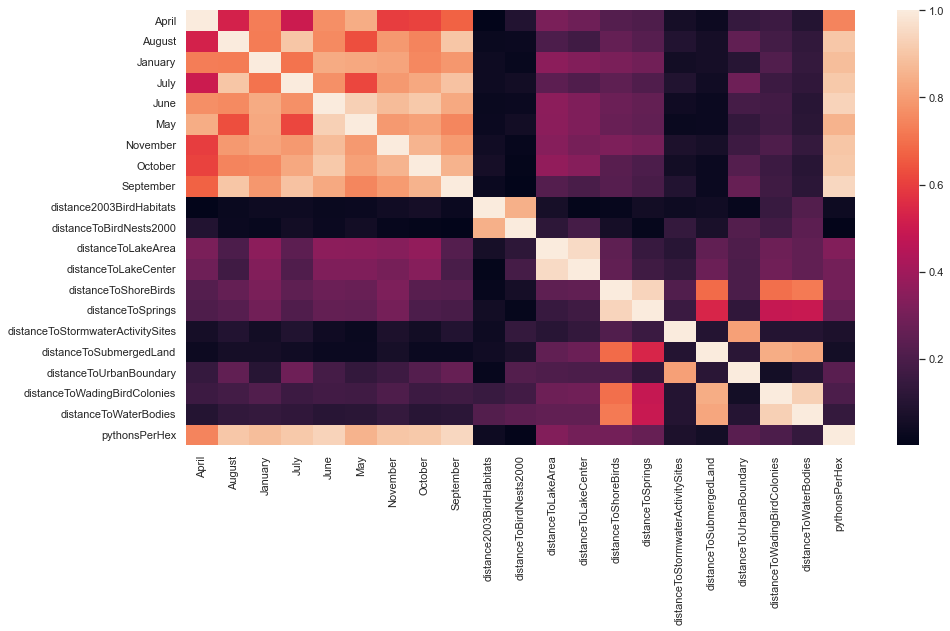

In [254]:
heatmap(absHighPass(corrDf, 0.8),cmap="rocket")
show()

In [255]:
upper_tri = corrDf.where(np.triu(np.ones(corrDf.shape),k=1).astype(bool))
print(upper_tri)

                                   pythonsPerHex     April    August  \
pythonsPerHex                                NaN  0.744693  0.904080   
April                                        NaN       NaN  0.526368   
August                                       NaN       NaN       NaN   
December                                     NaN       NaN       NaN   
February                                     NaN       NaN       NaN   
...                                          ...       ...       ...   
distanceToStormwaterActivitySites            NaN       NaN       NaN   
distanceToWaterBodies                        NaN       NaN       NaN   
distanceToSubmergedLand                      NaN       NaN       NaN   
INCOME_Hex                                   NaN       NaN       NaN   
POP_Hex                                      NaN       NaN       NaN   

                                   December  February   January      July  \
pythonsPerHex                      0.767307  0.621689  0.8

In [256]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print(to_drop)

['August', 'January', 'July', 'June', 'May', 'November', 'October', 'September', 'distance2003BirdHabitats', 'distanceToLakeCenter', 'distanceToSprings', 'distanceToStormwaterActivitySites', 'distanceToWaterBodies', 'distanceToSubmergedLand']


In [257]:
WIP2 = WIP2.drop(to_drop, axis = 1)

In [258]:
WIP2

hex_id                                           geometry  \
4    8544a1abfffffff  POLYGON ((-8942696.862 2984922.218, -8935633.1...   
5    8544a197fffffff  POLYGON ((-8956523.944 2930264.040, -8949482.5...   
14   8544120bfffffff  POLYGON ((-9013725.048 2946961.516, -9006653.9...   
17   8544a1a3fffffff  POLYGON ((-8959275.811 2980051.447, -8952208.1...   
23   85441a93fffffff  POLYGON ((-9203667.173 3200736.799, -9196403.8...   
..               ...                                                ...   
618  8544a1affffffff  POLYGON ((-8954661.466 2998315.865, -8947586.3...   
627  85441277fffffff  POLYGON ((-9021276.527 2978634.625, -9014186.6...   
630  85441a83fffffff  POLYGON ((-9199164.486 3219595.051, -9191892.8...   
632  8544aebbfffffff  POLYGON ((-8914791.607 3094569.132, -8907682.8...   
640  85441a13fffffff  POLYGON ((-9177343.900 3243509.041, -9170066.5...   

     pythonsPerHex  April  December  February  March          NAME  \
4               15    0.0       1.0       0.0    0.0       Broward   
5              189    8.0      12.0       5.0    1.0    Miami-Dade   
14               1    0.0       0.0       0.0    0.0        Monroe   
17              93    5.0      12.0       8.0    0.0    Miami-Dade   
23               1    0.0       0.0       0.0    0.0      Pinellas   
..             ...    ...       ...       ...    ...           ...   
618            225   17.0      10.0      10.0    4.0       Broward   
627            120    2.0       3.0       3.0    1.0       Collier   
630              1    0.0       0.0       0.0    0.0      Pinellas   
632              1    0.0       0.0       0.0    0.0    Palm Beach   
640              2    0.0       0.0       0.0    0.0  Hillsborough   

     NAME_Alachua  NAME_Baker  ...  ploverNestsPerHex  \
4             0.0         0.0  ...                  0   
5             0.0         0.0  ...                  0   
14            0.0         0.0  ...                  0   
17            0.0         0.0  ...                  0   
23            0.0         0.0  ...                  0   
..            ...         ...  ...                ...   
618           0.0         0.0  ...                  0   
627           0.0         0.0  ...                  0   
630           0.0         0.0  ...                  0   
632           0.0         0.0  ...                  0   
640           0.0         0.0  ...                  0   

     distanceToWadingBirdColonies  distanceToUrbanBoundary  \
4                    20831.252067                 0.000000   
5                    22073.970856               880.147971   
14                    4053.883653             52665.797012   
17                    8314.422302              8676.105311   
23                  104626.137275               656.447990   
..                            ...                      ...   
618                   5202.063927              3147.536032   
627                  25872.162190             63550.558881   
630                 120965.621315                 0.000000   
632                   2978.536998                 0.000000   
640                 102911.017737                 0.000000   

     distanceToUrbanCenter  distanceToLakeArea  distanceToRivers  \
4             30174.173658         8312.658607       8890.619617   
5             63973.920112        15646.329371      42115.455903   
14            95353.282176        14027.906025      40569.507122   
17            43816.566450        21559.905391       6637.972543   
23            45634.140531         6385.985668      22467.652253   
..                     ...                 ...               ...   
618           28859.223670        17818.809824       8669.205842   
627           72504.326721        18492.445227      22779.281549   
630           27508.630740         1660.568002      24988.268833   
632           19678.062630         5315.179505       7106.331956   
640            4970.008645         1483.133664       2808.612335   

     distanceToFlowingWat

In [259]:
WIP2.to_file('raw_data/WIP2.geojson', driver="GeoJSON")

C:\Users\gianl\miniconda3\envs\Capstone\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
